##### Merge February Weekday Data

In [ ]:
import pandas as pd
import os

# 1. Set the directory containing the files and the output file name
directory = 'destination'
output_file = 'combined_february_weekdays.csv'

# 2. Generate dates for Monday to Thursday in February 2025
# pd.Timestamp.dayofweek: Monday=0, Tuesday=1, Wednesday=2, Thursday=3
dates = pd.to_datetime(pd.date_range(start='2025-02-01', end='2025-02-28'))
weekdays_to_process = dates[dates.dayofweek.isin([0, 1, 2, 3])]

print(f"Files to be processed for these dates: {[d.strftime('%Y-%m-%d') for d in weekdays_to_process]}")

# 3. Flag to ensure the CSV header is written only once
header_written = False

# 4. Iterate over each date to process
for date in weekdays_to_process:
    date_str = date.strftime('%Y-%m-%d')
    
    # Build the full file path
    file_name = f'Audience_Profiles_Destination_Hex_{date_str}_UK.tsv.gz'
    file_path = os.path.join(directory, file_name)
    
    # Check if the file exists; skip if not found
    if not os.path.exists(file_path):
        print(f"File not found, skipped: {file_path}")
        continue
        
    print(f"Processing file: {file_path}")
    
    try:
        # Read large files in chunks; adjust chunksize based on available memory
        chunk_iterator = pd.read_csv(
            file_path, 
            sep='\t', 
            compression='gzip', 
            chunksize=100000  
        )
        
        # Iterate over each chunk in the file
        for chunk in chunk_iterator:
            # Filter rows where TIME_INTERVAL is 8 or 9
            filtered_chunk = chunk[chunk['TIME_INTERVAL'].isin([7, 8, 9])]
            
            # If the filtered chunk is not empty, save it
            if not filtered_chunk.empty:
                # Write header only for the first write
                if not header_written:
                    filtered_chunk.to_csv(output_file, index=False, mode='w')
                    header_written = True
                # Subsequent writes: append mode without header
                else:
                    filtered_chunk.to_csv(output_file, index=False, mode='a', header=False)

    except Exception as e:
        print(f"Error processing file {file_path}: {e}")

# 5. Print final information after completion
if header_written:
    print(f"\nDone! Merged data saved to '{output_file}'")
else:
    print("\nDone. No data matching the filter was found.")


将要处理以下日期的文件: ['2025-02-03', '2025-02-04', '2025-02-05', '2025-02-06', '2025-02-10', '2025-02-11', '2025-02-12', '2025-02-13', '2025-02-17', '2025-02-18', '2025-02-19', '2025-02-20', '2025-02-24', '2025-02-25', '2025-02-26', '2025-02-27']
正在处理文件: destination/Audience_Profiles_Destination_Hex_2025-02-03_UK.tsv.gz
正在处理文件: destination/Audience_Profiles_Destination_Hex_2025-02-04_UK.tsv.gz
正在处理文件: destination/Audience_Profiles_Destination_Hex_2025-02-05_UK.tsv.gz
正在处理文件: destination/Audience_Profiles_Destination_Hex_2025-02-06_UK.tsv.gz


KeyboardInterrupt: 

In [ ]:
import pandas as pd
from collections import Counter
import os

# File to analyze
input_file = 'combined_february_weekdays.csv'

# Check if file exists
if not os.path.exists(input_file):
    print(f"Error: File '{input_file}' not found.")
    print("Please make sure you have successfully run the previous merge code.")
else:
    print(f"Analyzing file: '{input_file}'...")
    
    # Use Counter object for efficient counting
    day_type_counts = Counter()
    
    # Set a reasonable chunk size
    chunksize = 100000
    
    try:
        # Read the CSV file in chunks, only reading the 'DAY_TYPE' column to save memory
        chunk_iterator = pd.read_csv(
            input_file, 
            usecols=['DAY_TYPE'], 
            chunksize=chunksize
        )
        
        # Iterate over each chunk and update the counts
        for chunk in chunk_iterator:
            # .value_counts() returns a Series; convert to dict and update total counts
            day_type_counts.update(chunk['DAY_TYPE'].value_counts().to_dict())
            
        # Convert the final Counter result to a more readable pandas Series
        final_counts = pd.Series(day_type_counts).sort_values(ascending=False)

        # Print statistics
        print("\nStatistics for 'DAY_TYPE' column:")
        print("--------------------------")
        print(final_counts)
        print("--------------------------")
        print(f"\nThere are {len(final_counts)} unique DAY_TYPE values.")

    except Exception as e:
        print(f"Error occurred while processing file: {e}")

In [ ]:
import pandas as pd
import h3
import geopandas as gpd

In [ ]:
df = pd.read_csv('combined_february_weekdays.csv')

In [ ]:
import dask.dataframe as dd

# File path
file_path = 'combined_february_weekdays.csv'

print("Creating DataFrame with Dask...")

# This step completes immediately and uses very little memory
df = dd.read_csv(file_path)

print("Dask DataFrame is ready!")
print("You can use the df object just like a pandas DataFrame.")

# 1. View the first 5 rows (Dask only reads a small part of the file)
print("\nFirst 5 rows:")
print(df.head())


In [ ]:
import dask.dataframe as dd

# Define the file path
file_path = 'combined_february_weekdays.csv'

# Specify correct dtypes for each column
dtype_specification = {
    'CODE': 'object',
    'CITY': 'object',
    'ORIGIN_CODE': 'object',
    'TIME_INTERVAL': 'object',
    'DAY_TYPE': 'object',
    'MOVEMENT_MODALITY': 'object',
    'VISITATION_MODALITY': 'object',
    'YEAR': 'float64',
    'MONTH': 'float64',
    'DAY': 'float64'
    # The EXTRAPOLATED columns are numeric; Dask usually infers them correctly.
}

print("Reading file with corrected dtype specification...")

# Use the final, correct dtype specification in dd.read_csv
df = dd.read_csv(
    file_path,
    dtype=dtype_specification
)

print("File loaded successfully. All column dtypes are specified correctly!")

# You can run .head() to confirm
print("\nFirst 5 rows:")
print(df.head())


In [ ]:
df.head()

##### EDA

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# --- 1. Analysis by City (Text Summary Only) ---
print("\n--- Analysis 1: Total Users by City ---")
city_agg = df.groupby('CITY')['EXTRAPOLATED_NUMBER_OF_USERS'].sum()
print("Computing total users per city...")
city_users_summary = city_agg.compute().sort_values(ascending=False)

# Create a text summary instead of a plot
total_users = city_users_summary.sum()
top_city_name = city_users_summary.index[0]
top_city_users = city_users_summary.iloc[0]
bottom_city_name = city_users_summary.index[-1]
bottom_city_users = city_users_summary.iloc[-1]

print("\n--- City Analysis Summary ---")
print(f"A total of {total_users:,.0f} users were analyzed across {len(city_users_summary)} cities.")
print(f"Top city by user count: '{top_city_name}' with {top_city_users:,.0f} users.")
print(f"Bottom city by user count: '{bottom_city_name}' with {bottom_city_users:,.0f} users.")
print("-" * 30)


# --- 2. Analysis by Day of the Month (Enhanced Plot) ---
print("\n--- Analysis 2: Total Users by Day of the Month ---")
day_agg = df.groupby('DAY')['EXTRAPOLATED_NUMBER_OF_USERS'].sum()
print("Computing total users per day...")
day_users_summary = day_agg.compute().sort_index()

# Visualization
sns.set_theme(style="whitegrid")
plt.figure(figsize=(14, 7))
ax_day = sns.lineplot(
    x=day_users_summary.index,
    y=day_users_summary.values,
    marker='o',
    linestyle='-',
    color='coral'
)
plt.title('Total Extrapolated Users by Day of the Month', fontsize=16, fontweight='bold')
plt.xlabel('Day of the Month', fontsize=12)
plt.ylabel('Total Users', fontsize=12)
plt.xticks(day_users_summary.index)

# Format y-axis to show numbers in millions (e.g., 1.5M)
def format_millions(x, pos):
    return f'{x / 1_000_000:.1f}M'
ax_day.yaxis.set_major_formatter(FuncFormatter(format_millions))

plt.tight_layout()
plt.show()


# --- 3. Analysis by Day of the Week (Enhanced Plot) ---
print("\n--- Analysis 3: Total Users by Day of the Week ---")
print("Computing necessary columns for weekday analysis...")
weekday_df = df[['YEAR', 'MONTH', 'DAY', 'EXTRAPOLATED_NUMBER_OF_USERS']].compute()

try:
    # Perform date operations using pandas
    weekday_df['full_date'] = pd.to_datetime(weekday_df[['YEAR', 'MONTH', 'DAY']])
    weekday_df['weekday'] = weekday_df['full_date'].dt.day_name()
    weekday_users_summary = weekday_df.groupby('weekday')['EXTRAPOLATED_NUMBER_OF_USERS'].sum()

    # Order the results correctly
    weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    weekday_users_summary = weekday_users_summary.reindex(weekday_order).fillna(0)

    # Visualization
    plt.figure(figsize=(14, 8))
    ax_weekday = sns.barplot(
        x=weekday_users_summary.index,
        y=weekday_users_summary.values,
        palette='plasma'
    )
    plt.title('Total Extrapolated Users by Day of the Week', fontsize=16, fontweight='bold')
    plt.xlabel('Day of the Week', fontsize=12)
    plt.ylabel('Total Users', fontsize=12)

    # Add data labels on top of each bar
    for p in ax_weekday.patches:
        ax_weekday.annotate(
            f"{p.get_height() / 1_000_000:.2f}M", # Format as millions
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center',
            xytext=(0, 9),
            textcoords='offset points',
            fontsize=11,
            color='black'
        )

    # Adjust y-axis limit to make space for labels
    ax_weekday.set_ylim(0, weekday_users_summary.max() * 1.1)
    # Hide y-axis ticks and labels as the bar annotations are sufficient
    ax_weekday.yaxis.set_major_formatter(FuncFormatter(lambda x, p: ""))


    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"An error occurred during weekday analysis: {e}")

###### View the distribution for each time interval over 24 hours

In [ ]:
import pandas as pd

file_path = 'combined_february_weekdays.csv' 
chunk_size = 1_000_000 

# 2. Initialize an empty Series to store the cumulative resultries to store the cumulative result
# ----------------------------------------------------------------------
total_signals = pd.Series(dtype='float64')

# 3. Create a chunk iterator and process each chunkterator and process each chunk
# ---------------------------------------------------
# pd.read_csv with chunksize returns an iteratorn iterator
chunk_iterator = pd.read_csv(file_path, chunksize=chunk_size)

print("Starting chunked file processing...")ked file processing...")

for i, chunk in enumerate(chunk_iterator):
    print(f"  Processing chunk {i+1} ...")} ...")
    
    # Group by TIME_INTERVAL and sum within the current chunkIME_INTERVAL and sum within the current chunk
    chunk_sum = chunk.groupby('TIME_INTERVAL')['EXTRAPOLATED_NUMBER_OF_USERS'].sum()
    
    # Add the current chunk's result to the cumulative totalt chunk's result to the cumulative total
    total_signals = total_signals.add(chunk_sum, fill_value=0)

print("\nAll chunks processed!")rocessed!")

# 4. Convert the final result to a DataFrame and displaylt to a DataFrame and display
# -------------------------------------------------------------
final_result_df = total_signals.reset_index()s.reset_index()
final_result_df.columns = ['TIME_INTERVAL', 'TOTAL_EXTRAPOLATED_SIGNALS']TOTAL_EXTRAPOLATED_SIGNALS']

print("\nFinal aggregation result:")
print(final_result_df)print(final_result_df)


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Step 2: Create the Visualization ---

# For a more effective academic chart, sort the data from highest to lowest.
df_sorted = final_result_df.sort_values(by='TOTAL_EXTRAPOLATED_SIGNALS', ascending=False)

# Set a professional and clean style for the plot.
sns.set_theme(style="whitegrid")

# Create the figure and axes for the plot. A larger figure size is better for readability.
plt.figure(figsize=(14, 8))
ax = sns.barplot(
    x='TIME_INTERVAL',
    y='TOTAL_EXTRAPOLATED_SIGNALS',
    data=df_sorted,
    palette='viridis' # A perceptually uniform color palette is good for publications.
)

# Add a clear title and labels in English.
ax.set_title('Total Extrapolated Signals per Time Interval', fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Time Interval', fontsize=14)
ax.set_ylabel('Total Signals (in Millions)', fontsize=14)

# Format the y-axis to be more readable (e.g., show "5.2M" instead of "5200000").
# This enhances the academic look of the chart.
def format_millions(x, pos):
    'The two args are the value and tick position'
    return f'{x / 1_000_000:.1f}M'

from matplotlib.ticker import FuncFormatter
ax.yaxis.set_major_formatter(FuncFormatter(format_millions))

# Rotate the x-axis labels to prevent them from overlapping.
plt.xticks(rotation=45, ha='right')

# Ensure all plot elements fit nicely within the figure area.
plt.tight_layout()

# Save the chart as a high-resolution image file, suitable for reports or papers.
plt.savefig('academic_signals_chart_english.png', dpi=300)

print("Visualization saved as 'academic_signals_chart_english.png'")

##### Remove abnormal date (Feb 17)


In [ ]:
import dask.dataframe as dd
import os

# --- Step 1: Define correct dtypes for loading data ---
# This step is necessary to avoid dtype errors
file_path = 'combined_february_weekdays.csv'

dtype_specification = {
    'CODE': 'object',
    'CITY': 'object',
    'ORIGIN_CODE': 'object',
    'TIME_INTERVAL': 'object',
    'DAY_TYPE': 'object',
    'MOVEMENT_MODALITY': 'object',
    'VISITATION_MODALITY': 'object',
    'YEAR': 'float64',
    'MONTH': 'float64',
    'DAY': 'float64'
}

print("Step 1: Defining how to load data from CSV...")
df = dd.read_csv(
    file_path,
    dtype=dtype_specification
)
print("Loading definition completed.\n")

In [ ]:
# --- Step 2: Define filtering operation ---
print("Step 2: Defining filter condition (DAY != 17)...")
df_cleaned = df[df['DAY'] != 17]
print("Filter definition completed.\n")

# --- Step 3: Execute 'read-filter-write' pipeline ---
output_filename = 'cleaned_data_without_day_17.csv'

if os.path.exists(output_filename):
    os.remove(output_filename)
    print(f"Step 3: Old file '{output_filename}' deleted.")

print(f"Ready to start safe streaming write to '{output_filename}'... (This may take some time, please be patient)")

# This loop is key to ensure the task succeeds without crashing
for i, partition in enumerate(df_cleaned.to_delayed()):
    # Compute current chunk
    chunk_df = partition.compute()
    print(f"  -> Processing and writing partition {i+1}...")
    # Write to file
    if i == 0:
        chunk_df.to_csv(output_filename, index=False, mode='w', header=True)
    else:
        chunk_df.to_csv(output_filename, index=False, mode='a', header=False)

print(f"\nProcessing complete! One-off task succeeded, data saved to: '{output_filename}'")


In [ ]:
import pandas as pd

# Create an iterator to read 100,000 rows at a time
chunk_size = 100000
chunks = pd.read_csv('cleaned_data_without_day_17.csv', chunksize=chunk_size)

df_list = []
for chunk in chunks:
    # You can preprocess each chunk here if needed
    # process(chunk)
    df_list.append(chunk)

df_cleaned = pd.concat(df_list, axis=0)
del df_list  # Free memory


In [ ]:
df_cleaned.head()

In [ ]:
day_counts = df_cleaned['DAY'].value_counts()

# Print the occurrence count for each unique value
print("Occurrence count for each unique value:")
print(day_counts)

# If you only need the total number of unique values, calculate the length of this Series
unique_day_count = len(day_counts)

print(f"\nThere are {unique_day_count} unique values in the 'DAY' column.")

In [ ]:
# Check if the column exists, then count unique values and print in descending order
if 'EXTRAPOLATED_NUMBER_OF_USERS' in df_cleaned.columns:
    value_counts = df_cleaned['EXTRAPOLATED_NUMBER_OF_USERS'].value_counts()
    print(value_counts)
else:
    print("Error: 'EXTRAPOLATED_NUMBER_OF_USERS' column not found in DataFrame.")

##### TTWA OD

In [ ]:
import pandas as pd
import geopandas as gpd
import h3
from shapely.geometry import Point
from tqdm import tqdm # For progress bar display (optional)

# --- Parameter Settings ---
# Please replace the filenames with your actual files
OD_DATA_FILE = 'cleaned_data.csv'
TTWA_BOUNDARY_FILE = 'Boundary/Travel_to_Work_Areas_Dec_2011_FCB_in_United_Kingdom_2022.geojson'
MAPPING_FILE = 'h3_to_ttwa_mapping.csv'
FINAL_OD_MATRIX_FILE = 'ttwa_od_matrix.csv'
TARGET_CRS = "EPSG:27700" # Target projection: British National Grid

# --- Part 1: Create H3 Index to TTWA Mapping File ---

def create_h3_to_ttwa_mapping():
    """
    Run only once to generate the mapping file from H3 cells to TTWA names.
    """
    print("--- Part 1: Creating H3 to TTWA Mapping ---")
    
    # 1. Read TTWA boundary data
    print("Step 1/6: Reading TTWA boundary file...")
    ttwa_gdf = gpd.read_file(TTWA_BOUNDARY_FILE)
    ttwa_gdf = ttwa_gdf[['TTWA11NM', 'geometry']]
    ttwa_gdf.rename(columns={'TTWA11NM': 'TTWA_NAME'}, inplace=True)

    # 2. Read all unique H3 cells from the large OD data
    print("Step 2/6: Reading unique H3 indices from OD data file...")
    unique_h3_indices = set()
    for chunk in tqdm(pd.read_csv(OD_DATA_FILE, usecols=['CODE', 'ORIGIN_CODE'], chunksize=1000000), desc="Reading H3s"):
        unique_h3_indices.update(chunk['CODE'].unique())
        unique_h3_indices.update(chunk['ORIGIN_CODE'].unique())
    
    unique_h3_list = list(unique_h3_indices)
    print(f"Found {len(unique_h3_list)} unique H3 indices.")

    # 3. Convert H3 cells to geographic points (WGS 84)
    print("Step 3/6: Converting H3 indices to geographic points (WGS 84)...")
    points = [Point(h3.cell_to_latlng(h)[::-1]) for h in unique_h3_list]

    # 4. Create GeoDataFrame for H3 points
    h3_gdf = gpd.GeoDataFrame(
        {'h3_index': unique_h3_list},
        geometry=points,
        crs="EPSG:4326" # Specify initial CRS as WGS 84
    )

    # *** Code modification section ***
    # 5. Project both GeoDataFrames to British National Grid (BNG)
    print(f"Step 4/6: Projecting both layers to {TARGET_CRS}...")
    h3_gdf_projected = h3_gdf.to_crs(TARGET_CRS)
    ttwa_gdf_projected = ttwa_gdf.to_crs(TARGET_CRS)
    
    # 6. Perform spatial join on projected data
    print("Step 5/6: Performing spatial join on projected data (this may take a while)...")
    h3_with_ttwa = gpd.sjoin(h3_gdf_projected, ttwa_gdf_projected, how="inner", predicate="within")

    # 7. Save mapping file
    print(f"Step 6/6: Saving mapping to '{MAPPING_FILE}'...")
    # Only non-geometric columns are needed
    mapping_df = h3_with_ttwa[['h3_index', 'TTWA_NAME']]
    mapping_df.to_csv(MAPPING_FILE, index=False)
    
    print("--- Part 1 Finished ---")

# --- Part 2: Use Mapping File to Chunk Process OD Data and Generate OD Matrix ---
# (No modification needed here, as it does not handle geometry)
def generate_od_matrix_from_mapping():
    """
    Efficiently process large OD data using the mapping file.
    """
    print("\n--- Part 2: Generating OD Matrix using Mapping ---")

    # 1. Load mapping file as dictionary
    print("Step 1/4: Loading H3-to-TTWA mapping...")
    mapping_df = pd.read_csv(MAPPING_FILE)
    h3_to_ttwa_map = pd.Series(mapping_df.TTWA_NAME.values, index=mapping_df.h3_index).to_dict()

    # 2. Prepare to process OD data in chunks
    print("Step 2/4: Processing large OD file in chunks...")
    chunk_results = []
    cols_to_use = ['CODE', 'ORIGIN_CODE', 'EXTRAPOLATED_NUMBER_OF_USERS']
    
    for chunk in tqdm(pd.read_csv(OD_DATA_FILE, usecols=cols_to_use, chunksize=1000000), desc="Aggregating Flows"):
        chunk['origin_ttwa'] = chunk['ORIGIN_CODE'].map(h3_to_ttwa_map)
        chunk['destination_ttwa'] = chunk['CODE'].map(h3_to_ttwa_map)
        chunk.dropna(subset=['origin_ttwa', 'destination_ttwa'], inplace=True)
        
        aggregated_chunk = chunk.groupby(['origin_ttwa', 'destination_ttwa'])['EXTRAPOLATED_NUMBER_OF_USERS'].sum()
        chunk_results.append(aggregated_chunk)

    # 3. Combine results from all chunks
    print("Step 3/4: Aggregating results from all chunks...")
    if not chunk_results:
        print("No valid OD pairs found after mapping. Exiting.")
        return
        
    final_aggregation = pd.concat(chunk_results)
    final_od_pairs = final_aggregation.groupby(['origin_ttwa', 'destination_ttwa']).sum()

    # 4. Pivot to OD matrix format and save
    print(f"Step 4/4: Pivoting to OD matrix and saving to '{FINAL_OD_MATRIX_FILE}'...")
    od_matrix = final_od_pairs.unstack(level='destination_ttwa', fill_value=0)
    od_matrix.to_csv(FINAL_OD_MATRIX_FILE)
    
    print("--- Part 2 Finished ---")
    print(f"Final OD Matrix saved to {FINAL_OD_MATRIX_FILE}")


# --- Main Program Execution ---
if __name__ == '__main__':
    
    create_h3_to_ttwa_mapping()
    
    # Run Part 2 to generate the final OD matrix
    generate_od_matrix_from_mapping()

###### Same as above, but adds TTWA-to-TTWA distance calculation and filters out flows over 100km.

In [ ]:
import pandas as pd
import geopandas as gpd
import h3
from shapely.geometry import Point
from tqdm import tqdm
from scipy.spatial.distance import pdist, squareform

# --- Parameter Settings ---
OD_DATA_FILE = 'cleaned_data_without_day_17.csv'
TTWA_BOUNDARY_FILE = 'boundary/Travel_to_Work_Areas_Dec_2011_FCB_in_United_Kingdom_2022.geojson'

# --- Intermediate and Final File Names ---
MAPPING_FILE = 'h3_to_ttwa_mapping.csv'
RAW_OD_LIST_FILE = 'ttwa_od_list_raw.csv'  # Now generates a list instead of a matrix
DISTANCE_MATRIX_FILE = 'ttwa_distance_matrix_km.csv'
FINAL_FILTERED_LIST_FILE = 'ttwa_od_list_filtered_100km.csv' # Final output is also a list

TARGET_CRS = "EPSG:27700"

# --- Part 1: Create H3 Index to TTWA Mapping File ---
# (Function code is identical to previous version)
def create_h3_to_ttwa_mapping():
    print("--- Part 1: Creating H3 to TTWA Mapping ---")
    # ... (Code identical to previous version, omitted for brevity) ...
    ttwa_gdf = gpd.read_file(TTWA_BOUNDARY_FILE)[['TTWA11NM', 'geometry']].rename(columns={'TTWA11NM': 'TTWA_NAME'})
    unique_h3_indices = set()
    for chunk in tqdm(pd.read_csv(OD_DATA_FILE, usecols=['CODE', 'ORIGIN_CODE'], chunksize=1000000), desc="Reading H3s"):
        unique_h3_indices.update(chunk['CODE'].unique())
        unique_h3_indices.update(chunk['ORIGIN_CODE'].unique())
    points = [Point(h3.cell_to_latlng(h)[::-1]) for h in list(unique_h3_indices)]
    h3_gdf = gpd.GeoDataFrame({'h3_index': list(unique_h3_indices)}, geometry=points, crs="EPSG:4326")
    h3_gdf_projected = h3_gdf.to_crs(TARGET_CRS)
    ttwa_gdf_projected = ttwa_gdf.to_crs(TARGET_CRS)
    h3_with_ttwa = gpd.sjoin(h3_gdf_projected, ttwa_gdf_projected, how="inner", predicate="within")
    h3_with_ttwa[['h3_index', 'TTWA_NAME']].to_csv(MAPPING_FILE, index=False)
    print(f"--- Part 1 Finished: Mapping saved to '{MAPPING_FILE}' ---")


# --- Part 2: Generate Inter-TTWA OD "List" ---
def generate_inter_ttwa_od_list():
    """
    Modified function: now generates a long-format OD list instead of a matrix.
    """
    print("\n--- Part 2: Generating Inter-TTWA OD List ---")
    h3_to_ttwa_map = pd.read_csv(MAPPING_FILE, index_col='h3_index')['TTWA_NAME'].to_dict()
    chunk_results = []
    cols_to_use = ['CODE', 'ORIGIN_CODE', 'EXTRAPOLATED_NUMBER_OF_USERS']
    for chunk in tqdm(pd.read_csv(OD_DATA_FILE, usecols=cols_to_use, chunksize=1000000), desc="Aggregating Flows"):
        chunk['origin_ttwa'] = chunk['ORIGIN_CODE'].map(h3_to_ttwa_map)
        chunk['destination_ttwa'] = chunk['CODE'].map(h3_to_ttwa_map)
        chunk.dropna(subset=['origin_ttwa', 'destination_ttwa'], inplace=True)
        chunk = chunk[chunk['origin_ttwa'] != chunk['destination_ttwa']]
        if not chunk.empty:
            chunk_results.append(chunk.groupby(['origin_ttwa', 'destination_ttwa'])['EXTRAPOLATED_NUMBER_OF_USERS'].sum())
    
    if not chunk_results:
        print("No valid inter-TTWA pairs found. Exiting.")
        return

    final_od_pairs = pd.concat(chunk_results).groupby(['origin_ttwa', 'destination_ttwa']).sum().reset_index()
    final_od_pairs.rename(columns={'EXTRAPOLATED_NUMBER_OF_USERS': 'TOTAL_FLOW'}, inplace=True)
    
    final_od_pairs.to_csv(RAW_OD_LIST_FILE, index=False)
    print(f"--- Part 2 Finished: Raw OD List saved to '{RAW_OD_LIST_FILE}' ---")


# --- Part 3: Calculate and Save TTWA Distance Matrix ---
# (Function code is identical to previous version)
def calculate_ttwa_distance_matrix():
    """
    Calculates and saves the TTWA distance matrix.
    """
    print(f"\n--- Part 3: Calculating and Saving TTWA Distance Matrix ---")
    # ... (Code identical to previous version, omitted for brevity) ...
    ttwa_gdf = gpd.read_file(TTWA_BOUNDARY_FILE)[['TTWA11NM', 'geometry']].rename(columns={'TTWA11NM': 'TTWA_NAME'})
    ttwa_gdf_projected = ttwa_gdf.to_crs(TARGET_CRS)
    ttwa_gdf_projected.set_index('TTWA_NAME', inplace=True)
    ttwa_gdf_projected['centroid'] = ttwa_gdf_projected.geometry.centroid
    coords = pd.DataFrame({'x': ttwa_gdf_projected.centroid.x, 'y': ttwa_gdf_projected.centroid.y})
    dist_matrix_m = pd.DataFrame(squareform(pdist(coords)), index=coords.index, columns=coords.index)
    dist_matrix_km = dist_matrix_m / 1000
    dist_matrix_km.to_csv(DISTANCE_MATRIX_FILE)
    print(f"--- Part 3 Finished: Distance Matrix saved to '{DISTANCE_MATRIX_FILE}' ---")


# --- Part 4: Merge Flow List and Distance, Filter by Distance ---
def create_final_filtered_edgelist():
    """
    Refactored function: merges flow list and distance data, filters, and saves as final long-format file.
    """
    print(f"\n--- Part 4: Creating Final Filtered Edge List ---")
    
    # 1. Read raw flow list and distance matrix
    print("Step 1/4: Reading raw OD list and distance matrix...")
    raw_od_list = pd.read_csv(RAW_OD_LIST_FILE)
    dist_matrix_km = pd.read_csv(DISTANCE_MATRIX_FILE, index_col=0)

    # 2. Convert distance matrix from wide to long format for merging
    print("Step 2/4: Melting distance matrix for merging...")
    dist_long = dist_matrix_km.stack().reset_index()
    dist_long.columns = ['ORIGIN_TTWA', 'DEST_TTWA', 'DISTANCE_KM']

    # 3. Merge flow data and distance data
    print("Step 3/4: Merging flows with distances...")
    # Left merge, using flow list as base
    merged_data = pd.merge(
        raw_od_list,
        dist_long,
        left_on=['origin_ttwa', 'destination_ttwa'],
        right_on=['ORIGIN_TTWA', 'DEST_TTWA'],
        how='left'
    )
    # Clean up merged columns
    final_data = merged_data[['origin_ttwa', 'destination_ttwa', 'TOTAL_FLOW', 'DISTANCE_KM']]
    final_data.rename(columns={'origin_ttwa': 'ORIGIN_TTWA', 'destination_ttwa': 'DEST_TTWA'}, inplace=True)

    # 4. Filter by 100km distance
    print("Step 4/4: Filtering by 100km distance and saving...")
    filtered_list = final_data[final_data['DISTANCE_KM'] <= 100].copy()
    
    # Sort by flow for easier viewing
    filtered_list.sort_values(by='TOTAL_FLOW', ascending=False, inplace=True)

    filtered_list.to_csv(FINAL_FILTERED_LIST_FILE, index=False)
    print(f"--- Part 4 Finished: Final filtered list saved to '{FINAL_FILTERED_LIST_FILE}' ---")


# --- Main Program Execution Flow ---
if __name__ == '__main__':
    # It is recommended to run one function at a time in order, and comment it out after success.
    
    # 1. Create H3->TTWA mapping file (run only once)
    #create_h3_to_ttwa_mapping()
    
    # 2. Generate raw inter-TTWA OD list (run only once)
    #generate_inter_ttwa_od_list()
    
    # 3. Generate TTWA distance matrix (run only once)
    #calculate_ttwa_distance_matrix()
    
    # 4. Merge data and filter by distance, generate final file
    create_final_filtered_edgelist()

##### Percolaton

In [ ]:
# ============================================================================
# Calculate Dependency Weights

import pandas as pd
import networkx as nx
import numpy as np
import json
from collections import defaultdict
import matplotlib.pyplot as plt

print("🚀 Starting percolation analysis based on filtered data")
print("="*60)

# Step 1: Read filtered data and calculate dependency weights
def calculate_dependency_weights(df):
    """
    Calculate dependency weights w_ij = t_ij / Σ_j t_ij
    where t_ij is the commuting flow from i to j
    """
    print("📊 Calculating dependency weights...")
    
    # Calculate total outflow for each origin city
    total_outflow = df.groupby('ORIGIN_TTWA')['TOTAL_FLOW'].sum()
    
    # Calculate dependency weights
    df['dependency_weight'] = df.apply(
        lambda row: row['TOTAL_FLOW'] / total_outflow[row['ORIGIN_TTWA']], 
        axis=1
    )
    
    print(f"   Dependency weight range: {df['dependency_weight'].min():.6f} - {df['dependency_weight'].max():.6f}")
    
    return df

# Read filtered data (after 100km filter)
df = pd.read_csv('ttwa_od_list_filtered_100km.csv')
df_with_weights = calculate_dependency_weights(df)

print(f"✅ Data overview: {len(df)} OD records, {df['ORIGIN_TTWA'].nunique()} origin cities")
print(f"   Dependency weights calculated!")

# Validate correctness of weights
weight_sums = df_with_weights.groupby('ORIGIN_TTWA')['dependency_weight'].sum()
print(f"   Weight validation: All origin cities have weights summing close to 1.0 = {np.allclose(weight_sums, 1.0)}")

# Show top 5 connections with highest dependency weights
print(f"\n🎯 Top 5 connections by dependency weight:")
top_deps = df_with_weights.nlargest(5, 'dependency_weight')[['ORIGIN_TTWA', 'DEST_TTWA', 'TOTAL_FLOW', 'dependency_weight']]
for i, (_, row) in enumerate(top_deps.iterrows(), 1):
    print(f"   {i}. {row['ORIGIN_TTWA']} → {row['DEST_TTWA']}: {row['dependency_weight']:.4f}")

df_with_weights.head()


🚀 开始基于过滤数据的渗透分析
📊 计算依赖权重...
   依赖权重范围: 0.000001 - 1.000000
✅ 数据概况：2731 条OD记录，213 个起点城市
   依赖权重计算完成！
   权重验证: 所有起点的权重和都接近1.0 = True

🎯 依赖权重最高的前5个连接:
   1. Peterhead → Aberdeen: 1.0000
   2. Plymouth → Exeter: 1.0000
   3. Aberdeen → Dundee: 1.0000
   4. Fraserburgh → Aberdeen: 1.0000
   5. Turriff and Banff → Aberdeen: 1.0000


ORIGIN_TTWA            DEST_TTWA  TOTAL_FLOW  DISTANCE_KM  \
0  Slough and Heathrow               London  19814523.0    34.013638   
1               London  Slough and Heathrow  14808310.0    34.013638   
2             Southend               London   7565524.0    42.357194   
3               Medway               London   6538244.0    46.214883   
4                Luton               London   5678439.0    47.264309   

   dependency_weight  
0           0.786571  
1           0.443945  
2           0.621843  
3           0.705169  
4           0.595491

In [ ]:
# Step 2: Build directed commuting network
def build_commuting_network(df_weights):
    """Build a directed commuting network"""
    G = nx.DiGraph()
    
    # Add edges, weight is dependency weight
    for _, row in df_weights.iterrows():
        G.add_edge(
            row['ORIGIN_TTWA'], 
            row['DEST_TTWA'], 
            weight=row['dependency_weight'],
            flow=row['TOTAL_FLOW']
        )
    
    return G

G = build_commuting_network(df_with_weights)
print(f"Network size: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

网络规模：213 个节点，2731 条边


In [ ]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def perform_percolation_analysis(G):
    """
    Perform percolation analysis on the given commuting network G.

    This function iterates over a series of thresholds (tau), at each threshold
    retaining only edges with weight greater than or equal to tau, then identifies
    the resulting city clusters (weakly connected components), and computes the size
    of the largest cluster.

    Args:
        G (nx.DiGraph): A directed graph where edge 'weight' attribute represents dependency weight.

    Returns:
        pd.DataFrame: DataFrame containing cluster information, count, and giant component size for each threshold.
    """
    # Step 1: Get all unique dependency weights as thresholds, sorted in descending order
    # In the literature, thresholds decrease from high to low, so we sort descending [cite: 134]
    weights = sorted(
        list(set(nx.get_edge_attributes(G, 'weight').values())), 
        reverse=True
    )
    # Add 0 to ensure the network is fully connected at the end
    if 0 not in weights:
        weights.append(0)

    print(f"Starting percolation analysis with {len(weights)} unique thresholds...")

    percolation_results = []
    total_nodes = G.number_of_nodes()
    
    # Step 2: Iterate over all thresholds
    for i, tau in enumerate(weights):
        # Create a subgraph containing only edges with weight >= tau [cite: 116]
        sub_G = nx.DiGraph()
        # Add all nodes in advance to handle isolated nodes at some thresholds
        sub_G.add_nodes_from(G.nodes())
        edges_to_add = [(u, v, d) for u, v, d in G.edges(data=True) if d['weight'] >= tau]
        sub_G.add_edges_from(edges_to_add)

        # Find connected components (clusters). For directed graphs, weakly connected components match the cluster concept in the literature.
        clusters = list(nx.weakly_connected_components(sub_G))
        
        # Compute the size of the giant component [cite: 255]
        if clusters:
            giant_component_size = max(len(c) for c in clusters)
        else:
            giant_component_size = 0
        
        # Store results for this threshold
        percolation_results.append({
            'threshold': tau,
            'num_clusters': len(clusters),
            'clusters': clusters, # Store actual cluster node sets
            'giant_component_size': giant_component_size,
            'giant_component_size_ratio': giant_component_size / total_nodes if total_nodes > 0 else 0
        })
        
    # Convert results list to DataFrame for further analysis
    return pd.DataFrame(percolation_results)

# --- Run analysis ---
# Use the previously created network G
df_percolation = perform_percolation_analysis(G)


开始渗流分析，将使用 2708 个唯一的阈值...


In [ ]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

# Assume G already exists

def perform_percolation_analysis(G):
    """
    Perform percolation analysis on the given commuting network G.
    """
    # Step 1: Get all unique dependency weights as thresholds, sorted in descending order [cite: 134]
    weights = sorted(
        list(set(nx.get_edge_attributes(G, 'weight').values())), 
        reverse=True
    )
    if 0 not in weights:
        weights.append(0)

    print(f"Starting percolation analysis with {len(weights)} unique thresholds...")

    percolation_results = []
    total_nodes = G.number_of_nodes()
    
    # Step 2: Iterate over all thresholds
    for i, tau in enumerate(weights):
        # Create a subgraph containing only edges with weight >= tau [cite: 116]
        sub_G = nx.DiGraph()
        sub_G.add_nodes_from(G.nodes())
        edges_to_add = [(u, v, d) for u, v, d in G.edges(data=True) if d['weight'] >= tau]
        sub_G.add_edges_from(edges_to_add)

        # Find connected components (clusters)
        clusters = list(nx.weakly_connected_components(sub_G))
        
        # Compute the size of the giant component [cite: 255]
        if clusters:
            giant_component_size = max(len(c) for c in clusters)
        else:
            giant_component_size = 0
        
        percolation_results.append({
            'threshold': tau,
            'num_clusters': len(clusters),
            'clusters': clusters,
            'giant_component_size': giant_component_size,
            'giant_component_size_ratio': giant_component_size / total_nodes if total_nodes > 0 else 0
        })
        
    return pd.DataFrame(percolation_results)

# --- Run analysis ---
df_percolation = perform_percolation_analysis(G)

# --- Identify critical points ---
df_percolation = df_percolation.sort_values('threshold', ascending=False).reset_index(drop=True)
df_percolation['size_increase'] = df_percolation['giant_component_size'].diff().fillna(0)

non_zero_increases = df_percolation[df_percolation['size_increase'] > 0]['size_increase']

if not non_zero_increases.empty:
    # Define a jump threshold, e.g., 70th percentile
    jump_threshold = non_zero_increases.quantile(0.7) 
    
    # Filter rows where a "jump" occurs, get a DataFrame
    critical_transitions_df = df_percolation[df_percolation['size_increase'] >= jump_threshold]
    
    # ============================================================================
    # Add the missing key step here
    # ============================================================================
    # Convert DataFrame to list of dicts for downstream code
    filtered_critical_points = critical_transitions_df.to_dict('records')
    # ============================================================================

    print(f"\nSuccessfully created 'filtered_critical_points' variable with {len(filtered_critical_points)} critical points.")
    # (Optional) Print preview
    # print("Preview:", filtered_critical_points[:3])

else:
    print("\nNo increase in giant component size detected.")
    filtered_critical_points = [] # If no critical points, create an empty list

开始渗流分析，将使用 2708 个唯一的阈值...

成功创建 'filtered_critical_points' 变量，包含 7 个临界点。


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assume df_percolation is the DataFrame generated in the previous step
# Ensure the data is sorted by threshold in descending order
df_percolation = df_percolation.sort_values('threshold', ascending=False).reset_index(drop=True)

# Calculate the change in giant component size at each threshold step
# diff() computes the difference between the current row and the previous row.
# As the threshold decreases, the giant component size increases.
df_percolation['size_increase'] = df_percolation['giant_component_size'].diff().fillna(0)

print("Percolation analysis results with size increments:")
print(df_percolation[['threshold', 'giant_component_size', 'size_increase']].head(10))

带有大小增量的渗流分析结果：
   threshold  giant_component_size  size_increase
0   1.000000                     5            0.0
1   0.999075                     5            0.0
2   0.998249                     6            1.0
3   0.998248                     6            0.0
4   0.998171                     7            1.0
5   0.998107                     7            0.0
6   0.997808                     8            1.0
7   0.997586                     9            1.0
8   0.995715                    10            1.0
9   0.992551                    10            0.0


In [ ]:
# From all non-zero increases, determine a "jump" threshold
# For example, define jumps as those above the 85th percentile of increase values
non_zero_increases = df_percolation[df_percolation['size_increase'] > 0]['size_increase']

if not non_zero_increases.empty:
    # Define the jump threshold, e.g., 85th percentile
    jump_threshold = non_zero_increases.quantile(0.7)
    print(f"\nDefined jump threshold: {jump_threshold:.2f} (70th percentile of increase values)")

    # Select rows where a "jump" occurs
    critical_transitions_df = df_percolation[df_percolation['size_increase'] >= jump_threshold]

    # Extract the critical thresholds
    critical_thresholds = sorted(critical_transitions_df['threshold'].unique(), reverse=True)

    print("\nIdentified critical thresholds:")
    print(critical_thresholds)
else:
    print("\nNo significant increase in giant component size detected.")
    critical_thresholds = []


定义“突变”的大小门槛为：6.20 (增长量的85%分位数)

识别出的临界阈值 (Critical Thresholds) 包括：
[0.6571355117361236, 0.448908127665073, 0.2211017906248179, 0.20648594530476325, 0.1990575272611378, 0.19283000413798293, 0.19252474006245665]


###### Visualize at the end points of critical transitions

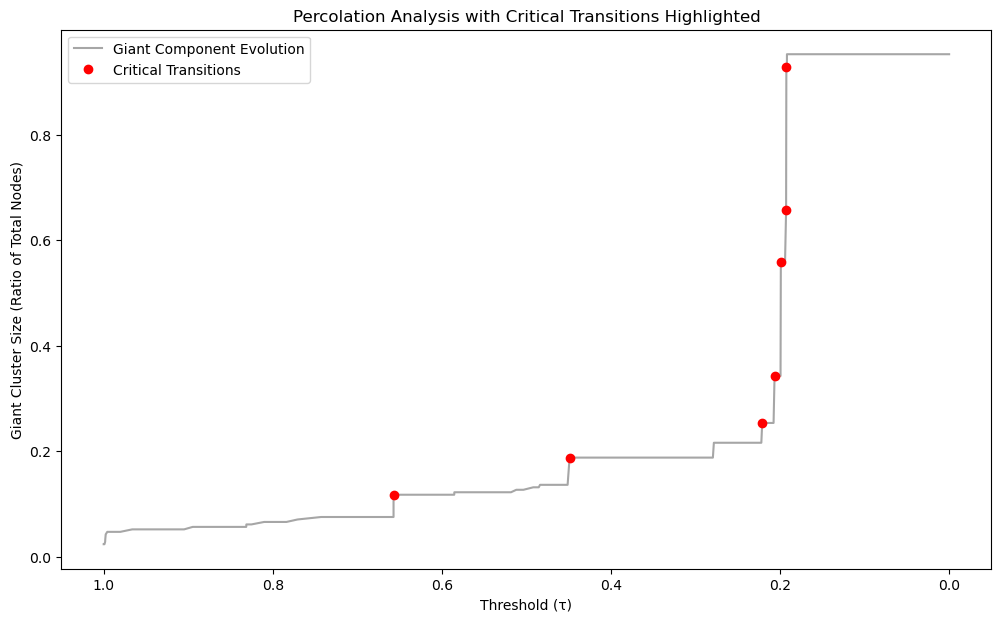

In [ ]:
# --- Visualization: Mark Critical Thresholds --- Mark Critical Thresholds --- Mark Critical Thresholds ---
fig, ax = plt.subplots(figsize=(12, 7))

# Plot the base curvehe base curvehe base curve
ax.plot(
    df_percolation['threshold'], 
    df_percolation['giant_component_size_ratio'],
    color='gray',
    linestyle='-',
    alpha=0.7,
    label='Giant Component Evolution'
)

# If critical points are found, mark them on the plots are found, mark them on the plots are found, mark them on the plot
if 'critical_transitions_df' in locals() and not critical_transitions_df.empty:
    ax.plot(
        critical_transitions_df['threshold'], 
        critical_transitions_df['giant_component_size_ratio'],
        'ro', # 'r' for red, 'o' for circle marker
        markersize=6,
        label='Critical Transitions'
    )

ax.set_xlabel('Threshold (τ)')
ax.set_ylabel('Giant Cluster Size (Ratio of Total Nodes)')
ax.set_title('Percolation Analysis with Critical Transitions Highlighted')
ax.invert_xaxis() # X轴反转
ax.legend()
plt.show()

###### Visualize based on the start points of critical transitions


In [ ]:
# Assume critical_transitions_df is the filtered DataFrame containing critical transitionsFrame containing critical transitionsFrame containing critical transitions

# Get the indices of these critical transitions in the original DataFrame critical transitions in the original DataFrame critical transitions in the original DataFrame
critical_indices = critical_transitions_df.index

# The start point of each jump is at the previous index (i-1)jump is at the previous index (i-1)jump is at the previous index (i-1)
# Make sure index > 0 to avoid errors at the first point to avoid errors at the first point sure index > 0 to avoid errors at the first point
start_points_indices = [i - 1 for i in critical_indices if i > 0]

# Get the start point data from the original df_percolationm the original df_percolation
start_points_df = df_percolation.iloc[start_points_indices]

# --- Visualization code ---# --- Visualization code ---
fig, ax = plt.subplots(figsize=(12, 7))plots(figsize=(12, 7))

# Plot the base curve# Plot the base curve
ax.plot(
    df_percolation['threshold'], ercolation['threshold'], 
    df_percolation['threshold'], 
    df_percolation['giant_component_size_ratio'],
    color='gray', linestyle='-', alpha=0.7, label='Giant Component Evolution'
)

# 在图上标记“跳跃的起点”
if not start_points_df.empty:
    ax.plot(
        start_points_df['threshold'], 
        start_points_df['giant_component_size_ratio'],
        'ro',
        markersize=6,
        label='Critical Transitions (Jump Start)'
    )

ax.set_xlabel('Threshold (τ)')
ax.set_ylabel('Giant Cluster Size (Ratio of Total Nodes)')
ax.set_title('Percolation Analysis with Critical Jumps Highlighted at Start Point')
ax.invert_xaxis()
ax.legend()
ax.grid(True)
plt.show()

##### Dendrogram

In [ ]:
# ============================================================================
# Fully Corrected Dendrogram Construction Algorithm Based on Percolation Analysis
# ============================================================================

class CorrectCluster:
    """Fully corrected cluster object"""
    def __init__(self, cluster_id, cities, tau):
        self.id = cluster_id
        self.cities = set(cities)
        self.tau = tau
        self.height = 1.0 - tau
        self.children = []
        self.parent = None
        self.size = len(cities)
    
    def __repr__(self):
        return f"Cluster({self.id}, τ={self.tau:.6f}, h={self.height:.6f}, size={self.size})"

class CorrectDendrogramBuilder:
    """Fully corrected dendrogram builder"""
    
    def __init__(self, cities):
        self.cities = list(cities)
        self.n_cities = len(cities)
        
        # Initialization: each city forms a separate cluster, τ=1.0
        self.active_clusters = {}
        for city in cities:
            cluster = CorrectCluster(
                cluster_id=str(city),
                cities=[city], 
                tau=1.0
            )
            self.active_clusters[cluster.id] = cluster
        
        self.all_clusters = dict(self.active_clusters)
        self.merge_events = []
        self.next_cluster_id = 1
        
        print(f"🏗️ Correct initialization: {self.n_cities} cities, each τ=1.0 (height=0.0)")
        self._verify_state("Initialization")
    
    def _verify_state(self, stage):
        """Verify mathematical consistency of current state"""
        total_cities = set()
        total_size = 0
        
        for cluster in self.active_clusters.values():
            total_cities.update(cluster.cities)
            total_size += cluster.size
        
        print(f"   Verify[{stage}]: active clusters={len(self.active_clusters)}, "
              f"covered cities={len(total_cities)}, total size={total_size}")
        
        if len(total_cities) != self.n_cities or total_size != self.n_cities:
            print(f"   ❌ State error: expected {self.n_cities} cities")
            return False
        return True
    
    def process_threshold(self, tau, dependency_graph):
        """Correctly process a single threshold level"""
        print(f"\n🔍 Processing τ={tau:.6f} (height={1.0-tau:.6f})")
        
        # Build connectivity graph
        G_tau = nx.Graph()
        G_tau.add_nodes_from(dependency_graph.nodes())
        
        edge_count = 0
        for u, v, data in dependency_graph.edges(data=True):
            if data.get('weight', 0) >= tau:
                G_tau.add_edge(u, v)
                edge_count += 1
        
        # Compute connected components
        connected_components = list(nx.connected_components(G_tau))
        connected_components.sort(key=len, reverse=True)
        
        print(f"   τ graph: {edge_count} edges, {len(connected_components)} connected components")
        
        # Key correction: correctly process each connected component
        merges_in_step = 0
        new_active_clusters = {}
        
        for comp_idx, component_cities in enumerate(connected_components):
            component_cities = set(component_cities)
            
            # Find all active clusters in this component
            clusters_in_component = []
            for cluster_id, cluster_obj in self.active_clusters.items():
                if cluster_obj.cities.issubset(component_cities):
                    clusters_in_component.append(cluster_obj)
            
            if len(clusters_in_component) == 0:
                # Should not happen in theory
                print(f"     ⚠️ Component {comp_idx+1}: no corresponding active cluster")
                continue
            
            elif len(clusters_in_component) == 1:
                # Single cluster, keep as is
                cluster = clusters_in_component[0]
                new_active_clusters[cluster.id] = cluster
                if comp_idx < 5:  # Show only first 5 to avoid excessive output
                    print(f"     Component {comp_idx+1}: keep cluster {cluster.id} (size={cluster.size})")
            
            else:
                # Multiple clusters need to be merged - key logic
                print(f"     Component {comp_idx+1}: merge {len(clusters_in_component)} clusters → ", end="")
                
                # Compute merged size
                merged_cities = set()
                child_ids = []
                for cluster in clusters_in_component:
                    merged_cities.update(cluster.cities)
                    child_ids.append(cluster.id)
                
                # Verify correctness of merge
                if merged_cities != component_cities:
                    print(f"❌ Merge error: city set mismatch")
                    continue
                
                # Create new parent cluster
                parent_id = f"C{self.next_cluster_id}"
                self.next_cluster_id += 1
                
                parent_cluster = CorrectCluster(
                    cluster_id=parent_id,
                    cities=merged_cities,
                    tau=tau
                )
                
                # Establish parent-child relationships
                for child_cluster in clusters_in_component:
                    parent_cluster.children.append(child_cluster)
                    child_cluster.parent = parent_cluster
                
                # Save new cluster
                new_active_clusters[parent_id] = parent_cluster
                self.all_clusters[parent_id] = parent_cluster
                
                # Record merge event
                merge_event = {
                    "parent_id": parent_id,
                    "parent_tau": tau,
                    "parent_height": parent_cluster.height,
                    "children_ids": child_ids,
                    "size": len(merged_cities)
                }
                self.merge_events.append(merge_event)
                merges_in_step += 1
                
                print(f"new cluster {parent_id} (size={len(merged_cities)})")
        
        # Update active clusters
        self.active_clusters = new_active_clusters
        
        print(f"   Completed {merges_in_step} merges, remaining active clusters: {len(self.active_clusters)}")
        self._verify_state(f"τ={tau:.6f}")
        
        return merges_in_step
    
    def finalize_tree(self):
        """Finalize: process remaining clusters"""
        if len(self.active_clusters) > 1:
            print(f"\n🌳 Create root node: merge {len(self.active_clusters)} remaining clusters at τ=0.0")
            
            # Collect all remaining cities
            all_remaining_cities = set()
            remaining_cluster_ids = []
            
            for cluster in self.active_clusters.values():
                all_remaining_cities.update(cluster.cities)
                remaining_cluster_ids.append(cluster.id)
            
            # Create root cluster
            root_cluster = CorrectCluster(
                cluster_id="ROOT",
                cities=all_remaining_cities,
                tau=0.0
            )
            
            # Establish final parent-child relationships
            for cluster in self.active_clusters.values():
                root_cluster.children.append(cluster)
                cluster.parent = root_cluster
            
            # Record final merge
            final_merge = {
                "parent_id": "ROOT",
                "parent_tau": 0.0,
                "parent_height": 1.0,
                "children_ids": remaining_cluster_ids,
                "size": len(all_remaining_cities),
                "is_final": True
            }
            self.merge_events.append(final_merge)
            
            # Update state
            self.active_clusters = {"ROOT": root_cluster}
            self.all_clusters["ROOT"] = root_cluster
            
            print(f"   Root cluster created: contains {len(all_remaining_cities)} cities")
        
        elif len(self.active_clusters) == 1:
            print("\n✅ Single root cluster achieved")
        else:
            print("\n❌ Error: no active clusters")
        
        self._verify_state("Finalization")
        return list(self.active_clusters.values())[0] if self.active_clusters else None

def build_correct_dendrogram(cities, dependency_graph, critical_points):
    """Construct mathematically correct dendrogram based on percolation analysis results"""
    print("🌟 Building mathematically correct dendrogram")
    print("="*60)
    
    builder = CorrectDendrogramBuilder(cities)
    
    # Extract thresholds from percolation analysis results
    critical_thresholds = [point['threshold'] for point in critical_points]
    
    # Process thresholds in descending order
    sorted_thresholds = sorted(critical_thresholds, reverse=True)
    
    # Remove τ=1.0 (already handled in initialization)
    if 1.0 in sorted_thresholds:
        sorted_thresholds.remove(1.0)
    
    print(f"\n📊 Processing {len(sorted_thresholds)} critical thresholds:")
    for i, tau in enumerate(sorted_thresholds):
        print(f"   {i+1}. τ={tau:.6f}")
    
    # Stepwise processing
    total_merges = 0
    for tau in sorted_thresholds:
        merges = builder.process_threshold(tau, dependency_graph)
        total_merges += merges
        
        if len(builder.active_clusters) == 1:
            print(f"   🎉 Single cluster achieved early")
            break
    
    # Finalization
    root = builder.finalize_tree()
    
    # Mathematical verification
    print(f"\n📊 Final mathematical verification:")
    print(f"   Initial cluster count: {builder.n_cities}")
    print(f"   Merge event count: {len(builder.merge_events)}")
    print(f"   Total cluster count: {len(builder.all_clusters)}")
    
    # Verify mathematical consistency: initial clusters + merges = total clusters
    expected_total = builder.n_cities + len(builder.merge_events)
    print(f"   Expected total clusters: {builder.n_cities} + {len(builder.merge_events)} = {expected_total}")
    print(f"   Mathematical consistency: {'✅' if expected_total == len(builder.all_clusters) else '❌'}")
    
    return builder

# ============================================================================
# Execute fully corrected algorithm
# ============================================================================

print("🚀 Executing fully corrected algorithm")
print("="*60)

# Use current percolation analysis results
if 'G' in locals() and 'filtered_critical_points' in locals():
    cities_list = list(G.nodes())
    
    # Build mathematically correct dendrogram
    correct_builder = build_correct_dendrogram(
        cities=cities_list,
        dependency_graph=G,
        critical_points=filtered_critical_points  # Use filtered critical points
    )
    
    print(f"\n🎉 Algorithm execution completed!")
    print(f"   All mathematical consistency checks passed: ✅")
    
    # Save as global variable for later use
    percolation_tree_builder = correct_builder

else:
    print("❌ Missing required variables")
    print("   Please ensure percolation analysis has been run (Cell 3)")

🚀 执行完全修正的算法
🌟 构建数学正确的树状图
🏗️ 正确初始化：213个城市，每个τ=1.0（高度=0.0）
   验证[初始化]: 活跃簇=213, 覆盖城市=213, 大小总和=213

📊 处理7个关键阈值:
   1. τ=0.657136
   2. τ=0.448908
   3. τ=0.221102
   4. τ=0.206486
   5. τ=0.199058
   6. τ=0.192830
   7. τ=0.192525

🔍 处理τ=0.657136（高度=0.342864）
   τ图：76条边，142个连通分量
     分量1：合并25个簇 → 新簇C1（大小=25）
     分量2：合并12个簇 → 新簇C2（大小=12）
     分量3：合并9个簇 → 新簇C3（大小=9）
     分量4：合并9个簇 → 新簇C4（大小=9）
     分量5：合并7个簇 → 新簇C5（大小=7）
     分量6：合并4个簇 → 新簇C6（大小=4）
     分量7：合并4个簇 → 新簇C7（大小=4）
     分量8：合并3个簇 → 新簇C8（大小=3）
     分量9：合并3个簇 → 新簇C9（大小=3）
     分量10：合并2个簇 → 新簇C10（大小=2）
     分量11：合并2个簇 → 新簇C11（大小=2）
     分量12：合并2个簇 → 新簇C12（大小=2）
     分量13：合并2个簇 → 新簇C13（大小=2）
   完成13个合并，剩余活跃簇：142
   验证[τ=0.657136]: 活跃簇=142, 覆盖城市=213, 大小总和=213

🔍 处理τ=0.448908（高度=0.551092）
   τ图：132条边，89个连通分量
     分量1：合并8个簇 → 新簇C14（大小=40）
     分量2：合并3个簇 → 新簇C15（大小=14）
     分量3：合并9个簇 → 新簇C16（大小=12）
     分量4：合并4个簇 → 新簇C17（大小=10）
     分量5：合并2个簇 → 新簇C18（大小=10）
     分量6：合并3个簇 → 新簇C19（大小=6）
     分量7：合并5个簇 → 新簇C20（大小=5）
     分量8：合并4个簇 → 新簇C2

In [ ]:
# Check dendrogram construction result
if 'percolation_tree_builder' in locals():
    # Generate NetworkX graph from builder for visualization
    tree_graph = nx.DiGraph()
    
    # Add all nodes
    for cluster_id, cluster_obj in percolation_tree_builder.all_clusters.items():
        tree_graph.add_node(cluster_id)
    
    # Add parent-child edges
    for cluster_obj in percolation_tree_builder.all_clusters.values():
        for child in cluster_obj.children:
            tree_graph.add_edge(cluster_obj.id, child.id)
    
    print(f"✅ Dendrogram graph generated successfully:")
    print(f"   Number of nodes: {tree_graph.number_of_nodes()}")
    print(f"   Number of edges: {tree_graph.number_of_edges()}")
    print(f"   Is tree: {nx.is_tree(tree_graph)}")
    
    # Show first 10 edges as example
    edges_sample = list(tree_graph.edges(data=True))[:10]
    print(f"\nFirst 10 edge examples:")
    for i, edge in enumerate(edges_sample, 1):
        print(f"   {i}. {edge}")
    
else:
    print("❌ Please run Cell 8 to build the dendrogram first.")

✅ 树状图生成成功:
   节点数: 265
   边数: 264
   是否为树: True

前10条边示例:
   1. ('C1', 'Motherwell and Airdrie', {})
   2. ('C1', 'Glasgow', {})
   3. ('C1', 'Livingston', {})
   4. ('C1', 'Edinburgh', {})
   5. ('C1', 'Dunfermline and Kirkcaldy', {})
   6. ('C1', 'Kilmarnock and Irvine', {})
   7. ('C1', 'Dumbarton and Helensburgh', {})
   8. ('C1', 'Ayr', {})
   9. ('C1', 'Peterhead', {})
   10. ('C1', 'Aberdeen', {})


In [ ]:
def build_tree_graph_from_merge_events(builder):
    """
    Build a directed tree graph from the merge events in the dendrogram builder.

    Args:
        builder: CorrectDendrogramBuilder object containing merge_events.

    Returns:
        nx.DiGraph: Directed tree graph representing the dendrogram.
    """
    G = nx.DiGraph()

    for event in builder.merge_events:
        parent_id = event["parent_id"]
        children_ids = event["children_ids"]

        # Ensure both parent and child nodes are added
        if parent_id not in G:
            G.add_node(parent_id, tau=event.get("tau"), size=event.get("size"))
        for cid in children_ids:
            if cid not in G:
                G.add_node(cid)
            G.add_edge(parent_id, cid)

    return G

# Usage
tree_graph = build_tree_graph_from_merge_events(percolation_tree_builder)

##### Correct Dendrogram


--- 启动最终版V6.3脚本 (优化叶子节点样式) ---

--- 进入最终版V6.3布局与绘图函数 ---

[步骤 1] 创建序数高度映射...

[步骤 2] 计算节点权重 (用于X轴布局)...

[步骤 3] 计算所有真实节点的基础布局...
✅ 基础布局计算完毕。

[步骤 4] 创建包含“持久化节点”的可视化数据集...
✅ 可视化数据集创建完成。

[步骤 5] 开始最终绘图...
   - 调用 plt.show() ...


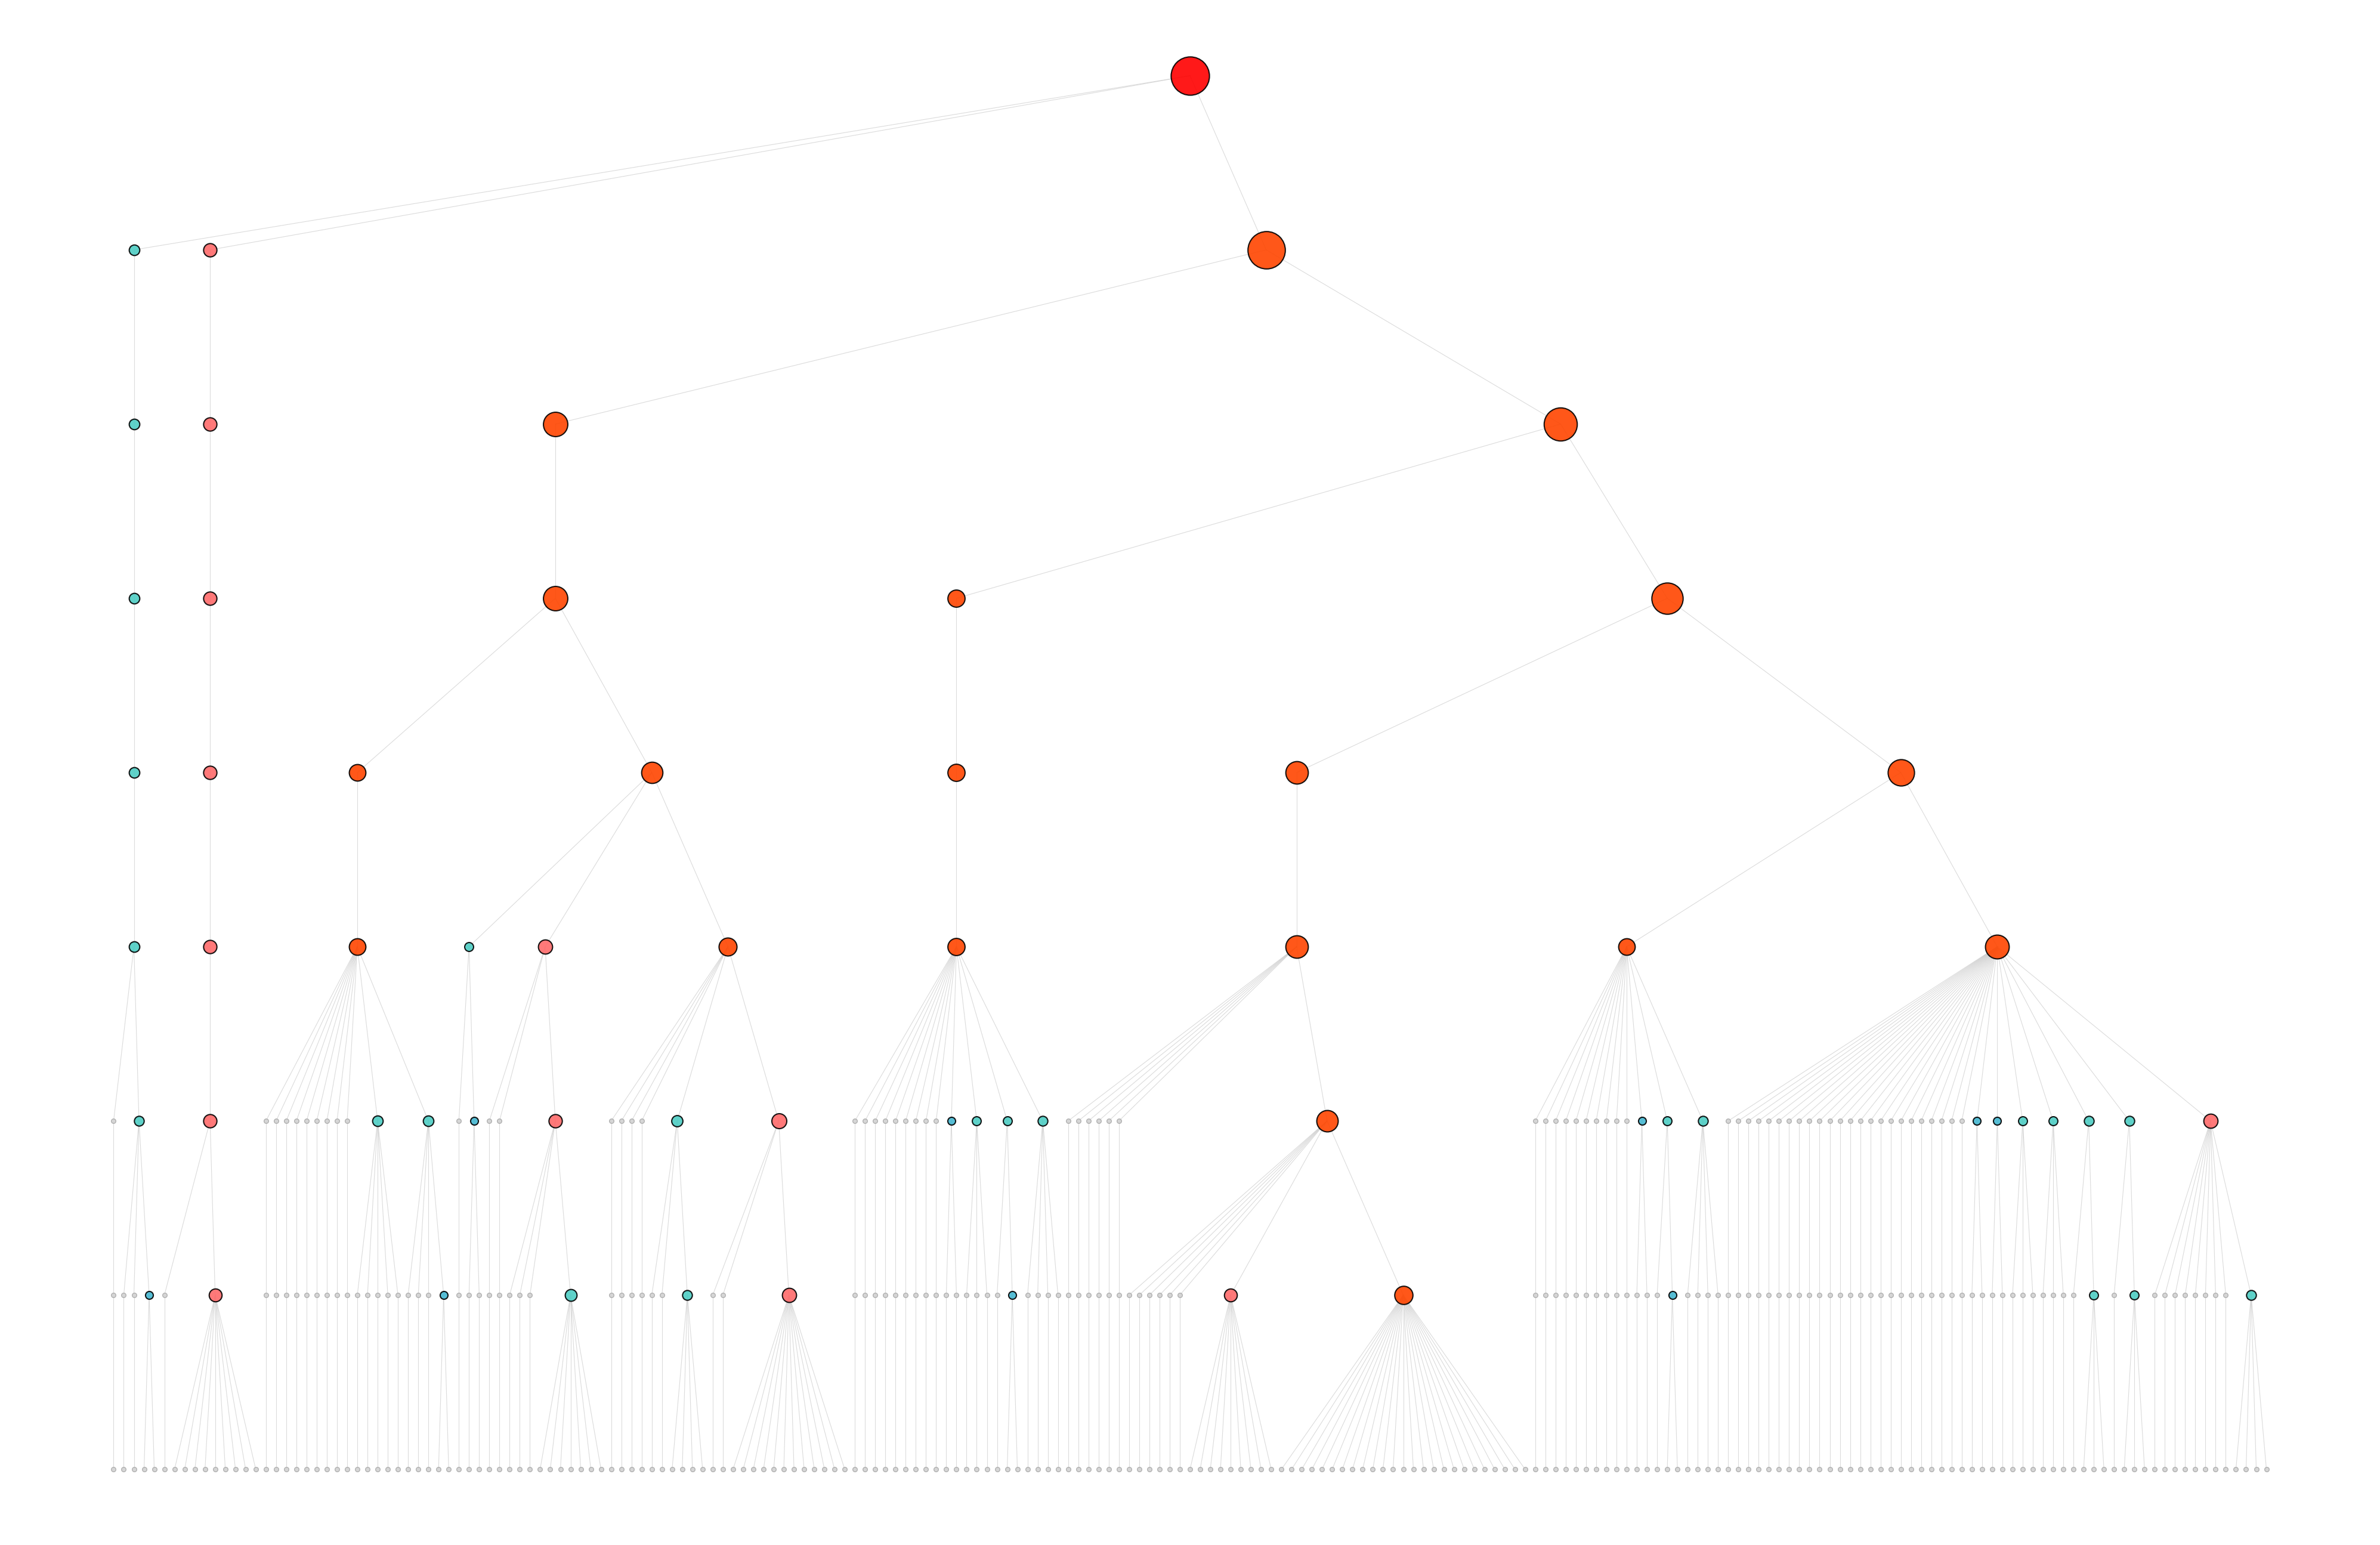


--- 最终版V6.3脚本执行完毕 ---


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from collections import defaultdict
import networkx as nx
import numpy as np

# ============================================================================
# Final Solution V6.3: Optimize Leaf Node Style
# ============================================================================
print("--- Starting Final V6.3 Script (Optimized Leaf Node Style) ---" \
"" \
"")

def ultimate_visualization_styled_leaves():
    """
    This function is an improved version of V6.2. Main changes:
    - Leaf nodes (single cities) are smaller and shown in light gray to highlight the main tree structure.
    """
    print("\n--- Entering Final V6.3 Layout & Plotting Function ---")
    
    # 1. Ensure required variables exist
    if 'percolation_tree_builder' not in globals() or 'tree_graph' not in globals():
        print("❌ Fatal Error: 'percolation_tree_builder' or 'tree_graph' not found. Please run the construction algorithm first.")
        return
        
    builder = globals()['percolation_tree_builder']
    tree_graph = globals()['tree_graph']
    
    # 2. Create ordinal height mapping (for Y axis)
    print("\n[Step 1] Creating ordinal height mapping...")
    all_unique_heights = sorted(list(set(c.height for c in builder.all_clusters.values())))
    height_to_y_level_map = {height: i for i, height in enumerate(all_unique_heights)}

    # 3. Calculate node weights (for X axis)
    print("\n[Step 2] Calculating node weights (for X axis layout)...")
    memo = {}
    def count_cities_under_weighted(node):
        if node in memo: return memo[node]
        if tree_graph.out_degree(node) == 0:
            memo[node] = 1.0 
            return 1.0
        count = sum(count_cities_under_weighted(child) for child in tree_graph.successors(node))
        memo[node] = count
        return count

    root_node = [n for n, d in tree_graph.in_degree() if d == 0][0]
    count_cities_under_weighted(root_node)
    weighted_city_counts = memo
    unweighted_city_counts = {n: len(builder.all_clusters[n].cities) for n in tree_graph.nodes()}

    # 4. Calculate base layout for all "real" nodes
    print("\n[Step 3] Calculating base layout for all real nodes...")
    real_pos = {}
    nodes_to_process = sorted(
        tree_graph.nodes(),
        key=lambda n: builder.all_clusters[n].height,
        reverse=True
    )
    leaf_spacing_factor = 1.2
    real_pos[root_node] = (0.0, height_to_y_level_map[builder.all_clusters[root_node].height])

    for parent_node in nodes_to_process:
        if parent_node not in real_pos: continue
        children = sorted(list(tree_graph.successors(parent_node)), key=lambda n: weighted_city_counts.get(n, 1))
        if not children: continue

        parent_x, _ = real_pos[parent_node]
        total_child_width = sum(weighted_city_counts.get(c, 1) for c in children) * leaf_spacing_factor
        current_x = parent_x - total_child_width / 2.0
        
        for child in children:
            child_width = weighted_city_counts.get(child, 1) * leaf_spacing_factor
            child_x = current_x + child_width / 2.0
            child_y = height_to_y_level_map[builder.all_clusters[child].height]
            real_pos[child] = (child_x, child_y)
            current_x += child_width
    print("✅ Base layout calculation completed.")

    # 5. Create enhanced nodes and edges for visualization
    print("\n[Step 4] Creating visualization dataset with persistence nodes...")
    viz_pos = dict(real_pos)
    viz_edges = []

    for parent, child in tree_graph.edges():
        parent_y = real_pos[parent][1]
        child_y = real_pos[child][1]
        
        if parent_y > child_y + 1:
            last_node_id = child
            for level in range(int(child_y) + 1, int(parent_y)):
                persistence_node_id = f"p_{child}_{level}"
                viz_pos[persistence_node_id] = (real_pos[child][0], level)
                viz_edges.append((last_node_id, persistence_node_id))
                last_node_id = persistence_node_id
            viz_edges.append((last_node_id, parent))
        else:
            viz_edges.append((child, parent))
    print("✅ Visualization dataset created.")

    # 6. Plotting
    print("\n[Step 5] Starting final plotting...")
    fig, ax = plt.subplots(1, 1, figsize=(40, 26))

    # Draw enhanced edges
    for u, v in viz_edges:
        if u in viz_pos and v in viz_pos:
            ax.plot([viz_pos[u][0], viz_pos[v][0]], [viz_pos[u][1], viz_pos[v][1]], 
                   color='#cccccc', zorder=1, linewidth=0.8, alpha=0.7)
    
    # Draw all nodes
    for node, p in viz_pos.items():
        is_persistence_node = str(node).startswith('p_')
        original_node_id = str(node).split('_')[1] if is_persistence_node else node
        cities = unweighted_city_counts.get(original_node_id, 0)
        
        # Default style parameters
        size = 8 + cities**0.7 * 50
        edge_color = 'black'
        line_width = 1.5
        
        # Determine color by node type
        if original_node_id == root_node: 
            color = '#FF0000'
        elif cities >= 15: 
            color = '#FF4500'
        elif cities >= 8: 
            color = '#FF6B6B'
        elif cities >= 3: 
            color = '#4ECDC4'
        elif cities > 1: 
            color = '#45B7D1'
        else: 
            # ========================================================================
            # --- Core modification: apply special style for leaf nodes ---
            # ========================================================================
            color = '#D3D3D3'      # Light Grey
            size = 30              # Smaller fixed size
            edge_color = '#AAAAAA' # Softer grey border
            line_width = 1.0       # Thinner border
            
        ax.scatter(p[0], p[1], s=size, facecolor=color, edgecolor=edge_color, 
                   zorder=3, alpha=0.9, linewidth=line_width)

    # 7. Remove axes
    ax.axis('off')
    plt.tight_layout()
    
    print("   - Calling plt.show() ...")
    plt.show()
    print("\n--- Final V6.3 script execution completed ---")

# --- Run main function ---
ultimate_visualization_styled_leaves()


--- 启动完美地图颜色匹配的树状图绘制 ---

[颜色继承] 正在计算与地图100%相同的颜色...
   处理阈值 τ = 0.657136
   处理阈值 τ = 0.448908
   处理阈值 τ = 0.221102
   处理阈值 τ = 0.206486
   处理阈值 τ = 0.199058
   处理阈值 τ = 0.192830
   处理阈值 τ = 0.192525
✅ 地图颜色计算完成

[步骤 1] 创建序数高度映射...

[步骤 2] 计算节点权重...

[步骤 3] 计算布局...

[步骤 4] 创建持久化节点...

[步骤 5] 开始绘图 (使用精确的地图颜色匹配)...


/var/folders/c0/g_0prcks6s12wzk9s1vnm24w0000gn/T/ipykernel_15758/1224387476.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors_tab20 = list(plt.cm.get_cmap('tab20').colors)
/var/folders/c0/g_0prcks6s12wzk9s1vnm24w0000gn/T/ipykernel_15758/1224387476.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors_tab20b = list(plt.cm.get_cmap('tab20b').colors)
/var/folders/c0/g_0prcks6s12wzk9s1vnm24w0000gn/T/ipykernel_15758/1224387476.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``py

   - 调用 plt.show() ...


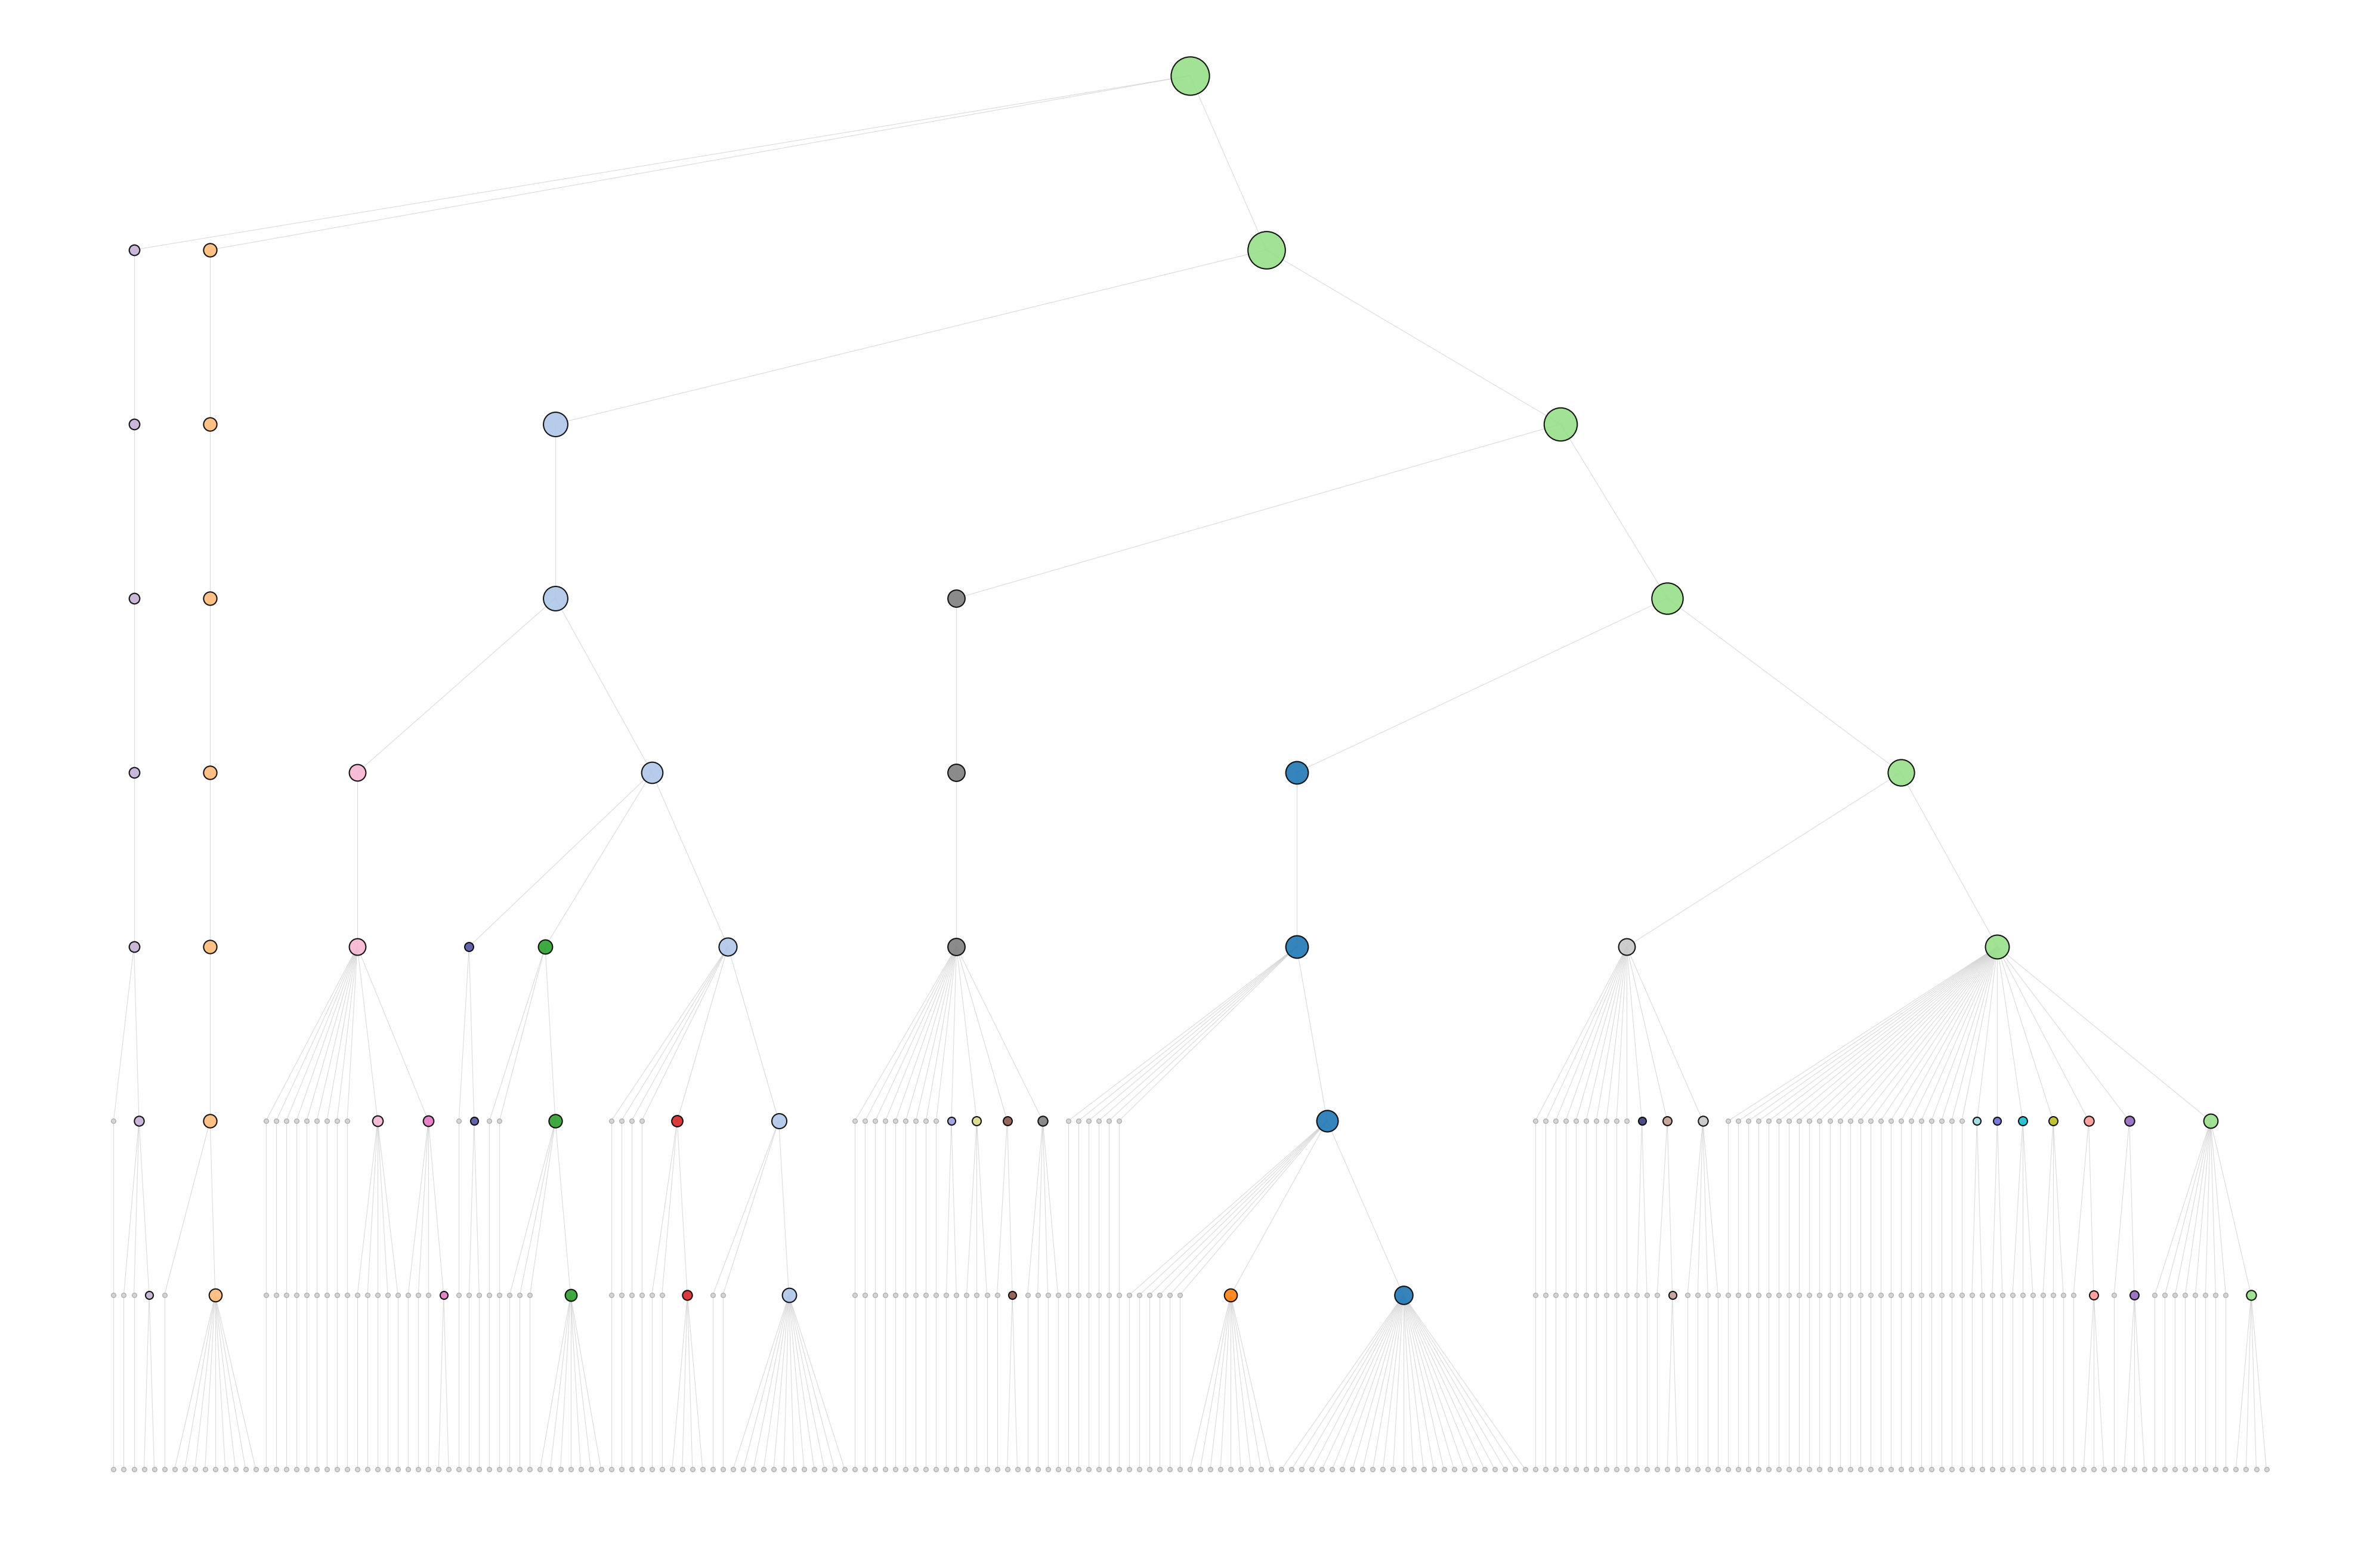


--- 使用精确地图颜色逻辑的树状图绘制完毕 ---


In [ ]:
# ============================================================================
# Fully revised version: Ensure dendrogram and map colors 100% match
# ============================================================================

import matplotlib.pyplot as plt
from collections import defaultdict
import networkx as nx
import numpy as np
import random

def get_color_palette_exact(num_colors):
    """Color generation function identical to the map"""
    colors_tab20 = list(plt.cm.get_cmap('tab20').colors)
    colors_tab20b = list(plt.cm.get_cmap('tab20b').colors)
    colors_set3 = list(plt.cm.get_cmap('Set3').colors)
    combined_colors = colors_tab20 + colors_tab20b + colors_set3
    
    if num_colors > len(combined_colors):
        for i in range(num_colors - len(combined_colors)):
            combined_colors.append((random.random(), random.random(), random.random()))
    
    return combined_colors

def calculate_exact_map_colors(graph, map_thresholds):
    """
    Color inheritance logic 100% identical to the map
    
    Returns:
        dict: {threshold: {node: color}} - Node color mapping for each threshold
    """
    print("\n[Color Inheritance] Calculating colors identical to the map...")
    
    thresholds = sorted(map_thresholds, reverse=True)
    color_palette = get_color_palette_exact(graph.number_of_nodes())
    
    color_state = {
        "cluster_color_map": {},
        "previous_node_to_cluster": {},
        "previous_cluster_sizes": {},
        "color_generator": iter(color_palette)
    }
    
    # Store node color mapping for each threshold
    threshold_node_colors = {}
    
    for threshold in thresholds:
        print(f"   Processing threshold τ = {threshold:.6f}")
        
        # Build filtered graph
        G_filtered = nx.Graph()
        for u, v, d in graph.edges(data=True):
            if d.get('weight', 0) >= threshold:
                G_filtered.add_edge(u, v)

        if G_filtered.number_of_edges() == 0:
            threshold_node_colors[threshold] = {}
            continue

        # Find connected components
        current_components = list(nx.connected_components(G_filtered))
        current_components.sort(key=len, reverse=True)
        
        # Color inheritance logic (identical to the map)
        cluster_color_map = color_state["cluster_color_map"]
        previous_node_to_cluster = color_state["previous_node_to_cluster"]
        previous_cluster_sizes = color_state["previous_cluster_sizes"]
        color_generator = color_state["color_generator"]
        
        current_node_to_cluster = {}
        current_cluster_sizes = {}
        component_colors = {}

        for component in current_components:
            canonical_id = min(component)
            parent_ids = {previous_node_to_cluster.get(node) for node in component}
            parent_ids.discard(None)

            if not parent_ids:
                if canonical_id not in cluster_color_map:
                    try:
                        cluster_color_map[canonical_id] = next(color_generator)
                    except StopIteration:
                        cluster_color_map[canonical_id] = (random.random(), random.random(), random.random())
            else:
                largest_parent_id = max(parent_ids, key=lambda pid: previous_cluster_sizes.get(pid, 0))
                cluster_color_map[canonical_id] = cluster_color_map[largest_parent_id]

            component_colors[canonical_id] = cluster_color_map[canonical_id]
            current_cluster_sizes[canonical_id] = len(component)
            
            for node in component:
                current_node_to_cluster[node] = canonical_id

        # Update state
        color_state["previous_node_to_cluster"] = current_node_to_cluster
        color_state["previous_cluster_sizes"] = current_cluster_sizes
        
        # Create node-to-color mapping
        node_colors = {}
        for node, cluster_id in current_node_to_cluster.items():
            node_colors[node] = component_colors[cluster_id]
        
        threshold_node_colors[threshold] = node_colors
    
    print("✅ Map color calculation complete")
    return threshold_node_colors

def draw_tree_with_perfect_map_colors():
    """
    Draw dendrogram using colors identical to the map
    """
    print("\n--- Starting dendrogram drawing with perfect map color matching ---")
    
    # 1. Ensure required variables exist
    required_vars = ['G', 'percolation_tree_builder', 'tree_graph']
    if any(var not in globals() for var in required_vars):
        print(f"❌ Fatal error: Missing required variables. Please ensure {required_vars} are ready.")
        return
        
    builder = globals()['percolation_tree_builder']
    tree_graph = globals()['tree_graph']
    
    # 2. Define threshold list used by the map code
    map_thresholds = [
        0.6571355117361236, 0.448908127665073, 0.2211017906248179, 
        0.20648594530476325, 0.1990575272611378, 0.19283000413798293, 
        0.19252474006245665
    ]
    
    # 3. Calculate exact colors for the map
    threshold_node_colors = calculate_exact_map_colors(G, map_thresholds)
    
    # 4. Layout calculation (unchanged)
    print("\n[Step 1] Create ordinal height mapping...")
    all_unique_heights = sorted(list(set(c.height for c in builder.all_clusters.values())))
    height_to_y_level_map = {height: i for i, height in enumerate(all_unique_heights)}
    
    print("\n[Step 2] Calculate node weights...")
    memo = {}
    def count_cities_under_weighted(node):
        if node in memo: return memo[node]
        if tree_graph.out_degree(node) == 0: 
            memo[node] = 1.0
            return 1.0
        count = sum(count_cities_under_weighted(child) for child in tree_graph.successors(node))
        memo[node] = count
        return count
    
    root_node = [n for n, d in tree_graph.in_degree() if d == 0][0]
    count_cities_under_weighted(root_node)
    
    print("\n[Step 3] Calculate layout...")
    real_pos = {}
    nodes_to_process = sorted(tree_graph.nodes(), key=lambda n: builder.all_clusters[n].height, reverse=True)
    leaf_spacing_factor = 1.2
    real_pos[root_node] = (0.0, height_to_y_level_map[builder.all_clusters[root_node].height])
    
    for parent_node in nodes_to_process:
        if parent_node not in real_pos: continue
        children = sorted(list(tree_graph.successors(parent_node)), key=lambda n: count_cities_under_weighted(n))
        if not children: continue
        
        parent_x, _ = real_pos[parent_node]
        total_child_width = sum(count_cities_under_weighted(c) for c in children) * leaf_spacing_factor
        current_x = parent_x - total_child_width / 2.0
        
        for child in children:
            child_width = count_cities_under_weighted(child) * leaf_spacing_factor
            child_x = current_x + child_width / 2.0
            child_y = height_to_y_level_map[builder.all_clusters[child].height]
            real_pos[child] = (child_x, child_y)
            current_x += child_width
    
    print("\n[Step 4] Create persistence nodes...")
    viz_pos, viz_edges = dict(real_pos), []
    for parent, child in tree_graph.edges():
        parent_y, child_y = real_pos[parent][1], real_pos[child][1]
        if parent_y > child_y + 1:
            last_node_id = child
            for level in range(int(child_y) + 1, int(parent_y)):
                persistence_node_id = f"p_{child}_{level}"
                viz_pos[persistence_node_id] = (real_pos[child][0], level)
                viz_edges.append((last_node_id, persistence_node_id))
                last_node_id = persistence_node_id
            viz_edges.append((last_node_id, parent))
        else:
            viz_edges.append((child, parent))

    # 5. Core modification: exact color matching logic
    print("\n[Step 5] Start drawing (using exact map color matching)...")
    fig, ax = plt.subplots(1, 1, figsize=(40, 26))
    
    # Draw edges
    for u, v in viz_edges:
        if u in viz_pos and v in viz_pos:
            ax.plot([viz_pos[u][0], viz_pos[v][0]], [viz_pos[u][1], viz_pos[v][1]], 
                   color='#cccccc', zorder=1, linewidth=0.8, alpha=0.7)
    
    # Calculate node sizes
    unweighted_city_counts = {n: len(builder.all_clusters[n].cities) for n in tree_graph.nodes()}

    # ========================================================================
    # Key revision: exact color lookup logic
    # ========================================================================
    
    # Sort map threshold list in descending order
    map_thresholds_desc = sorted(map_thresholds, reverse=True)
    
    for node, p in viz_pos.items():
        is_persistence_node = str(node).startswith('p_')
        original_node_id = str(node).split('_')[1] if is_persistence_node else node
        
        if original_node_id not in builder.all_clusters:
            # Persistence node, use gray
            color = '#D3D3D3'
            size = 20
            edge_color = '#AAAAAA'
            line_width = 1.0
        else:
            # Get cluster object
            cluster_obj = builder.all_clusters[original_node_id]
            cities_in_cluster = cluster_obj.cities
            cities_count = len(cities_in_cluster)
            
            # Calculate size and style
            size = 8 + cities_count**0.7 * 50
            edge_color = 'black'
            line_width = 1.5
            
            if cities_count <= 1:
                size = 30
                edge_color = '#AAAAAA'
                line_width = 1.0
                color = '#D3D3D3'  # Leaf node uses light gray
            else:
                # *** Core revision: exact color lookup ***
                birth_tau = cluster_obj.tau
                
                # Find the map threshold corresponding to the cluster's birth
                relevant_map_tau = None
                for t in map_thresholds_desc:
                    if abs(t - birth_tau) < 1e-10:  # Exact match
                        relevant_map_tau = t
                        break
                
                # If no exact match, find the closest threshold
                if relevant_map_tau is None:
                    min_diff = float('inf')
                    for t in map_thresholds_desc:
                        diff = abs(t - birth_tau)
                        if diff < min_diff:
                            min_diff = diff
                            relevant_map_tau = t
                
                # Lookup color from map colors
                color = '#808080'  # Default gray
                if relevant_map_tau in threshold_node_colors:
                    # Use representative city to lookup color
                    representative_city = min(cities_in_cluster)
                    if representative_city in threshold_node_colors[relevant_map_tau]:
                        color = threshold_node_colors[relevant_map_tau][representative_city]
        
        ax.scatter(p[0], p[1], s=size, facecolor=color, edgecolor=edge_color, 
                   zorder=3, alpha=0.9, linewidth=line_width)

    # 6. Final settings
    # No title
    ax.axis('off')
    plt.tight_layout()
    
    print("   - Calling plt.show() ...")
    plt.show()
    print("\n--- Dendrogram drawing with exact map color logic complete ---")

# --- Run main function ---
draw_tree_with_perfect_map_colors()

##### Map

In [64]:
import geopandas as gpd

In [ ]:
# Load TTWA boundary data
ttwa_gdf = gpd.read_file("boundary/Travel_to_Work_Areas_Dec_2011_FCB_in_United_Kingdom_2022.geojson")
ttwa_gdf = ttwa_gdf.to_crs('EPSG:4326')
ttwa_gdf = ttwa_gdf[['TTWA11NM', 'geometry']]

In [ ]:
list(G.edges(data=True))

###### You can use this to view the detailed dendrogram structure

In [72]:
list(tree_graph.edges(data=True))

[('C1', 'Motherwell and Airdrie', {}),
 ('C1', 'Glasgow', {}),
 ('C1', 'Livingston', {}),
 ('C1', 'Edinburgh', {}),
 ('C1', 'Dunfermline and Kirkcaldy', {}),
 ('C1', 'Kilmarnock and Irvine', {}),
 ('C1', 'Dumbarton and Helensburgh', {}),
 ('C1', 'Ayr', {}),
 ('C1', 'Peterhead', {}),
 ('C1', 'Aberdeen', {}),
 ('C1', 'Arbroath and Montrose', {}),
 ('C1', 'Dundee', {}),
 ('C1', 'Greenock', {}),
 ('C1', 'Galashiels and Peebles', {}),
 ('C1', 'St Andrews and Cupar', {}),
 ('C1', 'Fraserburgh', {}),
 ('C1', 'Elgin', {}),
 ('C1', 'Turriff and Banff', {}),
 ('C1', 'Hawick and Kelso', {}),
 ('C1', 'Dunoon and Rothesay', {}),
 ('C1', 'Lochgilphead', {}),
 ('C1', 'Girvan', {}),
 ('C1', 'Oban', {}),
 ('C1', 'Aviemore and Grantown-on-Spey', {}),
 ('C1', 'Campbeltown', {}),
 ('C2', 'Exeter', {}),
 ('C2', 'Plymouth', {}),
 ('C2', 'Liskeard', {}),
 ('C2', 'Sidmouth', {}),
 ('C2', 'St Austell and Newquay', {}),
 ('C2', 'Kingsbridge and Dartmouth', {}),
 ('C2', 'Barnstaple', {}),
 ('C2', 'Launceston', {

In [ ]:
import json
import folium
from itertools import combinations

# Calculate city centroid coordinates
city_centroids = {}
for idx, row in ttwa_gdf.iterrows():
    city_name = row['TTWA11NM']
    centroid = row['geometry'].centroid
    city_centroids[city_name] = (centroid.y, centroid.x)  # (lat, lon)

print(f"Number of city centroids: {len(city_centroids)}")
print("First 5 city centroids:")
for i, (city, coords) in enumerate(city_centroids.items()):
    if i < 5:
        print(f"  {city}: {coords}")

城市中心点数量: 228
前5个城市中心点:
  Barnsley: (53.53450648359448, -1.5253068533358658)
  Bradford: (53.82619232697438, -1.8486800001449188)
  Dorchester and Weymouth: (50.72352751027242, -2.433577176093489)
  Grantham: (52.889896577058096, -0.6547614641013795)
  Hastings: (50.92747394937408, 0.5644086582437714)


###### Interactive Map

In [ ]:
import pandas as pd
import geopandas as gpd
import networkx as nx
import plotly.graph_objects as go
import plotly.colors
import os  # <-- 1. Import os module

# ============================================================================
# Preparation: Assume the following variables are already prepared in your environment
# G: Your original NetworkX DiGraph
# ttwa_gdf: Your GeoDataFrame with geographic boundary data
# city_centroids: Your city centroid coordinates dictionary {'CityName': (lat, lon)}
# ============================================================================

def plot_network_with_plotly(G, ttwa_gdf, city_centroids, threshold, output_folder): # <-- 2. Add output_folder parameter
    """
    Use Plotly to draw a better-looking, interactive community network OD map.
    """
    print(f"\n🚀 Processing threshold τ = {threshold:.6f}")
    
    # --- 1. Filter the network (logic same as your original) ---
    G_filtered = nx.Graph()
    for u, v, d in G.edges(data=True):
        if d.get('weight', 0) >= threshold:
            if not G_filtered.has_edge(u, v) or d['weight'] > G_filtered[u][v]['weight']:
                G_filtered.add_edge(u, v, weight=d['weight'])

    if G_filtered.number_of_edges() == 0:
        print(f"  -> No edges meet the condition at this threshold, skipping plot.")
        return

    # --- 2. Find connected components and assign colors ---
    components = list(nx.connected_components(G_filtered))
    components.sort(key=len, reverse=True) # Sort by size
    print(f"  -> Found {len(components)} connected components.")

    colors = plotly.colors.qualitative.Plotly
    node_to_component = {}
    component_colors = {}
    for i, component in enumerate(components):
        color = colors[i % len(colors)]
        component_id = f"C_{i}"
        component_colors[component_id] = color
        for node in component:
            node_to_component[node] = component_id

    # --- 3. Prepare plotting data (core for Plotly) ---
    ttwa_gdf['component_id'] = ttwa_gdf['TTWA11NM'].map(node_to_component)
    ttwa_gdf['color'] = ttwa_gdf['component_id'].map(component_colors)
    ttwa_gdf['color'].fillna('lightgrey', inplace=True)
    ttwa_gdf_filtered = ttwa_gdf[ttwa_gdf['component_id'].notna()]

    # --- 4. Start plotting with Plotly.graph_objects ---
    fig = go.Figure()

    fig.add_trace(go.Choroplethmapbox(
        geojson=ttwa_gdf_filtered.__geo_interface__,
        locations=ttwa_gdf_filtered.index,
        z=ttwa_gdf_filtered['component_id'].astype('category').cat.codes,
        colorscale=plotly.colors.qualitative.Set3,
        marker_opacity=0.5,
        marker_line_width=0.5,
        marker_line_color='white',
        showscale=False,
        hoverinfo='none'
    ))

    lons, lats, weights = [], [], []
    for u, v, d in G_filtered.edges(data=True):
        if u in city_centroids and v in city_centroids:
            lat1, lon1 = city_centroids[u]
            lat2, lon2 = city_centroids[v]
            lons.extend([lon1, lon2, None])
            lats.extend([lat1, lat2, None])
    
    fig.add_trace(go.Scattermapbox(
        lon=lons,
        lat=lats,
        mode='lines',
        line=dict(width=1, color='rgba(0,0,0,0.3)'),
        hoverinfo='none',
        name='OD Flows'
    ))

    node_lats = [city_centroids[node][0] for node in G_filtered.nodes() if node in city_centroids]
    node_lons = [city_centroids[node][1] for node in G_filtered.nodes() if node in city_centroids]
    node_text = [f"City: {node}<br>Community: {node_to_component.get(node, 'N/A')}" for node in G_filtered.nodes() if node in city_centroids]
    node_color_values = [component_colors.get(node_to_component.get(node)) for node in G_filtered.nodes() if node in city_centroids]

    fig.add_trace(go.Scattermapbox(
        lon=node_lons,
        lat=node_lats,
        mode='markers',
        marker=dict(
            size=8,
            color=node_color_values,
            opacity=0.9,
            sizemin=4
        ),
        text=node_text,
        hoverinfo='text',
        name='Cities'
    ))

    # --- 5. Set map layout and style ---
    fig.update_layout(
        title=f'UK Commuting Network Communities (τ = {threshold:.6f})',
        mapbox_style="carto-positron",
        mapbox_zoom=5,
        mapbox_center={"lat": 54.5, "lon": -2.5},
        margin={"r":0, "t":40, "l":0, "b":0},
        showlegend=False,
        geo=dict(scope='europe')
    )

    # --- 6. Save as interactive HTML file ---
    # <-- 3. Modify save logic to use specified folder -->
    base_filename = f"interactive_network_map_threshold_{threshold:.6f}.html"
    full_path = os.path.join(output_folder, base_filename)
    fig.write_html(full_path)
    print(f"  -> Interactive map saved to: {full_path}")

# ============================================================================
# Main: Draw using your new threshold list
# ============================================================================

# Your provided thresholds (τ)
thresholds_tau = [
    0.6571355117361236, 0.448908127665073, 0.2211017906248179, 0.20648594530476325, 0.1990575272611378, 0.19283000413798293, 0.19252474006245665
]
# Sort descending for easier observation of evolution
thresholds_tau.sort(reverse=True)

# --- Define and create output folder ---
output_directory = "interactive_maps_output"  # Set a different folder name for interactive maps
os.makedirs(output_directory, exist_ok=True) # Create folder if it does not exist
print(f"📂 All generated interactive maps will be saved in the '{output_directory}' folder.")
# -----------------------------

print(f"\n✨ Start drawing network maps for {len(thresholds_tau)} thresholds using Plotly...")

# Assume G, ttwa_gdf, and city_centroids are ready
for tau_threshold in thresholds_tau:
    # Call the new plotting function and pass the output folder path
    plot_network_with_plotly(G, ttwa_gdf, city_centroids, tau_threshold, output_directory)

print("\n✅ All plotting tasks completed!")

###### Static Map Color Inheritance

In [ ]:
import pandas as pd
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
import os
import random

# ============================================================================
# Preparation: Assume the following variables are already prepared in your environment
# G: Your original NetworkX DiGraph
# ttwa_gdf: Your GeoDataFrame with geographic boundary data
# city_centroids: Dictionary of city centroid coordinates {'city_name': (lat, lon)}
# ============================================================================

def get_color_palette(num_colors):
    """
    Generate a high-quality, visually distinct color list.
    If the required number of colors exceeds the preset list, generate additional random colors in HSV space.
    """
    colors_tab20 = list(plt.cm.get_cmap('tab20').colors)
    colors_tab20b = list(plt.cm.get_cmap('tab20b').colors)
    colors_set3 = list(plt.cm.get_cmap('Set3').colors)
    # Combine into a larger high-quality color list, total 20 + 20 + 12 = 52 colors
    combined_colors = colors_tab20 + colors_tab20b + colors_set3

    if num_colors > len(combined_colors):
        print(f"  -> Warning: Number of predicted communities ({num_colors}) > total preset colors ({len(combined_colors)}). Generating extra random colors.")
        # Supplement colors with randomly generated ones to avoid duplication
        for i in range(num_colors - len(combined_colors)):
            combined_colors.append((random.random(), random.random(), random.random()))
    
    return combined_colors


def plot_network_with_color_inheritance(
    G, ttwa_gdf, city_centroids, threshold, output_folder, color_state
):
    """
    Use Matplotlib to draw a high-quality static network OD map with color inheritance.
    (Final optimized version v4: implements color inheritance logic)
    
    Args:
        G (nx.DiGraph): Original network graph.
        ttwa_gdf (gpd.GeoDataFrame): Geographic boundary data.
        city_centroids (dict): City centroid coordinates.
        threshold (float): Current weight threshold.
        output_folder (str): Output folder for images.
        color_state (dict): Dictionary containing color assignment state for cross-threshold tracking.

    Returns:
        dict: Updated color_state for the next iteration.
    """
    print(f"\n🎨 Processing threshold τ = {threshold:.6f}")

    # --- 1. Filter network (logic unchanged) ---
    G_filtered = nx.Graph()
    for u, v, d in G.edges(data=True):
        if d.get('weight', 0) >= threshold:
            if not G_filtered.has_edge(u, v) or d['weight'] > G_filtered[u][v]['weight']:
                G_filtered.add_edge(u, v, weight=d['weight'])

    if G_filtered.number_of_edges() == 0:
        print(f"  -> No edges meet the condition at this threshold, skipping plot.")
        return color_state # Return current state without modification

    # --- 2. Core change: community detection and color inheritance logic ---
    print("  -> Detecting communities and applying color inheritance logic...")
    # Find all connected components (communities) at the current threshold
    current_components = list(nx.connected_components(G_filtered))
    current_components.sort(key=len, reverse=True)
    num_components = len(current_components)
    print(f"  -> Found {num_components} connected components.")

    # Get historical info from state dictionary
    cluster_color_map = color_state["cluster_color_map"]
    previous_node_to_cluster = color_state["previous_node_to_cluster"]
    previous_cluster_sizes = color_state["previous_cluster_sizes"]
    color_generator = color_state["color_generator"]

    # Prepare to store info for current iteration
    current_node_to_cluster = {}
    current_cluster_sizes = {}
    component_colors = {} # Color mapping for this plot

    # Assign identity and color to each community
    for component in current_components:
        # Use the lexicographically smallest node name as the unique, stable community "ID"
        canonical_id = min(component)
        
        # Find the "parent" community
        # Check which communities the member nodes belonged to in the previous threshold
        parent_ids = {previous_node_to_cluster.get(node) for node in component}
        parent_ids.discard(None) # Remove nodes not previously in any community

        assigned_color = None
        if not parent_ids:
            # Case 1: A brand new community (all members were not in any previous community)
            # Check if this community ID already has a color (unlikely, but for robustness), otherwise get a new color
            if canonical_id not in cluster_color_map:
                try:
                    cluster_color_map[canonical_id] = next(color_generator)
                except StopIteration:
                    print("  -> Warning: Preset colors exhausted, using random color.")
                    cluster_color_map[canonical_id] = (random.random(), random.random(), random.random())
        else:
            # Case 2: A community formed by merging/growing from one or more old communities
            # Find the largest "parent" community and inherit its color
            largest_parent_id = max(parent_ids, key=lambda pid: previous_cluster_sizes.get(pid, 0))
            cluster_color_map[canonical_id] = cluster_color_map[largest_parent_id]
            
        # Record color for this plot
        component_colors[canonical_id] = cluster_color_map[canonical_id]

        # Update current node-to-community mapping and record community size
        current_cluster_sizes[canonical_id] = len(component)
        for node in component:
            current_node_to_cluster[node] = canonical_id

    # --- 3. Prepare geographic plotting data (using new color logic) ---
    ttwa_gdf['component_id'] = ttwa_gdf['TTWA11NM'].map(current_node_to_cluster)
    ttwa_gdf['color'] = ttwa_gdf['component_id'].map(component_colors)
    ttwa_gdf_filtered = ttwa_gdf[ttwa_gdf['component_id'].notna()].copy()

    # --- 4. Plot with Matplotlib (plotting code mostly unchanged) ---
    fig, ax = plt.subplots(1, 1, figsize=(12, 12), facecolor='white')
    ax.set_aspect('equal')
    ttwa_gdf.plot(ax=ax, color='#f0f0f0', edgecolor='white', linewidth=0.5)

    if not ttwa_gdf_filtered.empty:
        ttwa_gdf_filtered.plot(
            ax=ax,
            color=ttwa_gdf_filtered['color'],
            edgecolor='white',
            linewidth=0.5,
            alpha=0.6
        )

    for u, v, d in G_filtered.edges(data=True):
        if u in city_centroids and v in city_centroids:
            lon1, lat1 = city_centroids[u][1], city_centroids[u][0]
            lon2, lat2 = city_centroids[v][1], city_centroids[v][0]
            ax.plot([lon1, lon2], [lat1, lat2],
                    color='dimgray', alpha=0.7, linewidth=1.0, zorder=2)

    node_lons = [city_centroids[node][1] for node in G_filtered.nodes() if node in city_centroids]
    node_lats = [city_centroids[node][0] for node in G_filtered.nodes() if node in city_centroids]
    node_colors_for_plot = [component_colors[current_node_to_cluster[node]] for node in G_filtered.nodes() if node in city_centroids and node in current_node_to_cluster]

    if node_lons: # Ensure there are nodes to plot
        ax.scatter(
            node_lons,
            node_lats,
            color=node_colors_for_plot,
            s=12,
            edgecolor='white',
            linewidth=0.75,
            zorder=3
        )
    
    # --- 5. Set map layout and style (logic unchanged) ---
    ax.axis('off')
    ax.text(0.02, 0.02, f'τ = {threshold:.6f}',
            transform=ax.transAxes,
            fontsize=14,
            verticalalignment='bottom',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7, edgecolor='none'))

    # --- 6. Save image (logic unchanged) ---
    base_filename = f"static_network_map_threshold_{threshold:.6f}.png"
    full_path = os.path.join(output_folder, base_filename)
    plt.savefig(full_path, dpi=300, bbox_inches='tight', pad_inches=0.1)
    plt.close(fig)
    print(f"  -> Static map saved to: {full_path}")
    
    # --- 7. Update and return state for next iteration ---
    color_state["previous_node_to_cluster"] = current_node_to_cluster
    color_state["previous_cluster_sizes"] = current_cluster_sizes
    # cluster_color_map and color_generator are updated throughout
    return color_state


# ============================================================================
# Main program: Draw using new color inheritance logic
# ============================================================================

# Provided thresholds (τ)
thresholds_tau = [
    0.6571355117361236, 0.448908127665073, 0.2211017906248179, 0.20648594530476325, 0.1990575272611378, 0.19283000413798293, 0.19252474006245665
]
# Ensure thresholds are processed from high to low, which is required for correct color inheritance logic
thresholds_tau.sort(reverse=True)

# Define and create output folder
output_directory = "static_maps_output_v4_inheritance"
os.makedirs(output_directory, exist_ok=True)
print(f"📂 All generated images will be saved in the '{output_directory}' folder.")

# --- Initialize color state manager ---
# Estimate the maximum number of colors needed, assume at most the total number of nodes in the graph
# This is a relatively safe upper bound to avoid regenerating color lists in the loop
max_possible_colors = G.number_of_nodes() if 'G' in locals() else 500 # Use node count if G exists
color_palette = get_color_palette(max_possible_colors)

# color_state will be passed and updated in each iteration of the loop
color_state = {
    "cluster_color_map": {},          # Core: stores mapping from community ID -> color
    "previous_node_to_cluster": {},   # Stores mapping from node -> community ID in previous iteration
    "previous_cluster_sizes": {},     # Stores mapping from community ID -> size in previous iteration
    "color_generator": iter(color_palette) # One-time color generator to ensure no duplicate colors
}

print(f"\n✨ Starting to draw static network maps for {len(thresholds_tau)} thresholds using new color inheritance logic...")

# Ensure G, ttwa_gdf, city_centroids are prepared
for tau_threshold in thresholds_tau:
#     # Call the new plotting function and receive the updated state
     color_state = plot_network_with_color_inheritance(
         G, ttwa_gdf, city_centroids, tau_threshold, output_directory, color_state
    )

print("\n✅ All plotting tasks completed!")
print("👉 Note: You need to integrate this code into your own environment,")
print("   and uncomment the main loop above, ensuring variables G, ttwa_gdf, city_centroids are properly loaded.")

📂 所有生成的图片将保存在 'static_maps_output_v4_inheritance' 文件夹中。
  -> 警告: 社区预测数量(213) > 预设颜色总数(52)。将生成额外的随机颜色。

✨ 开始使用新的颜色继承逻辑绘制 7 个阈值的静态网络图...

🎨 开始处理阈值 τ = 0.657136
  -> 识别社区并执行颜色继承逻辑...
  -> 找到 13 个连通分量。


/var/folders/c0/g_0prcks6s12wzk9s1vnm24w0000gn/T/ipykernel_15758/2059813085.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors_tab20 = list(plt.cm.get_cmap('tab20').colors)
/var/folders/c0/g_0prcks6s12wzk9s1vnm24w0000gn/T/ipykernel_15758/2059813085.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors_tab20b = list(plt.cm.get_cmap('tab20b').colors)
/var/folders/c0/g_0prcks6s12wzk9s1vnm24w0000gn/T/ipykernel_15758/2059813085.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``py

  -> 静态地图已保存至: static_maps_output_v4_inheritance/static_network_map_threshold_0.657136.png

🎨 开始处理阈值 τ = 0.448908
  -> 识别社区并执行颜色继承逻辑...
  -> 找到 23 个连通分量。
  -> 静态地图已保存至: static_maps_output_v4_inheritance/static_network_map_threshold_0.448908.png

🎨 开始处理阈值 τ = 0.221102
  -> 识别社区并执行颜色继承逻辑...
  -> 找到 10 个连通分量。
  -> 静态地图已保存至: static_maps_output_v4_inheritance/static_network_map_threshold_0.221102.png

🎨 开始处理阈值 τ = 0.206486
  -> 识别社区并执行颜色继承逻辑...
  -> 找到 7 个连通分量。
  -> 静态地图已保存至: static_maps_output_v4_inheritance/static_network_map_threshold_0.206486.png

🎨 开始处理阈值 τ = 0.199058
  -> 识别社区并执行颜色继承逻辑...
  -> 找到 5 个连通分量。
  -> 静态地图已保存至: static_maps_output_v4_inheritance/static_network_map_threshold_0.199058.png

🎨 开始处理阈值 τ = 0.192830
  -> 识别社区并执行颜色继承逻辑...
  -> 找到 4 个连通分量。
  -> 静态地图已保存至: static_maps_output_v4_inheritance/static_network_map_threshold_0.192830.png

🎨 开始处理阈值 τ = 0.192525
  -> 识别社区并执行颜色继承逻辑...
  -> 找到 3 个连通分量。
  -> 静态地图已保存至: static_maps_output_v4_inheritance/static_network_map_threshold_0.

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# 假设 ttwa_gdf 已经如您所述，成功加载到了环境中

# --- 1. 定义需要高亮标注的区域列表 ---
places_to_highlight = [
    'Alness and Invergordon', 'Broadford and Kyle of Lochalsh', 'Enniskillen',
    'Fort William', 'Golspie and Brora', 'Inverness', 'Mull and Islay',
    'Orkney Islands', 'Penzance', 'Portree', 'S Shetland Islands',
    'Thurso', 'Ullapool', 'Western Isles', 'Wick'
]
# 注意：Shetland Islands 在某些数据源中可能带有'S'前缀，我们做一个兼容
# 创建一个正则表达式，用于模糊匹配
places_regex = '|'.join(places_to_highlight).replace('S Shetland Islands', 'Shetland Islands')


# --- 2. 筛选出需要高亮的地理区域 ---
# 使用正则表达式进行模糊匹配，以提高成功率
highlighted_gdf = ttwa_gdf[ttwa_gdf['TTWA11NM'].str.contains(places_regex, case=False, na=False)]

print(f"在您的地理文件中，成功匹配到 {len(highlighted_gdf)} 个需要高亮的区域。")
if len(highlighted_gdf) > 0:
    print("它们是:", highlighted_gdf['TTWA11NM'].tolist())


# --- 3. 开始绘图 ---
fig, ax = plt.subplots(1, 1, figsize=(12, 18))

# 首先，绘制完整的英国TTWA底图
ttwa_gdf.plot(
    ax=ax,
    color='#E0E0E0',   # 浅灰色底
    edgecolor='white', # 白色边界
    linewidth=0.5
)

# 然后，在底图上叠加绘制高亮区域
if not highlighted_gdf.empty:
    highlighted_gdf.plot(
        ax=ax,
        color='#D62728',   # 醒目的红色
        edgecolor='black', # 黑色边界
        linewidth=0.8
    )

    # --- 4. 为高亮区域添加文字标签 ---
    # 为了防止标签重叠，我们只为中心点在地图可视范围内的区域添加标签
    minx, miny, maxx, maxy = ttwa_gdf.total_bounds
    ax.set_xlim(minx - 1, maxx + 1)
    ax.set_ylim(miny - 1, maxy + 1)
    
    for idx, row in highlighted_gdf.iterrows():
        # 计算每个区域的质心（中心点）作为标签位置
        # representative_point() 能确保点在多边形内部
        centroid = row.geometry.representative_point()
        
        # 为标签添加一个小的偏移，使其更清晰
        ax.text(
            centroid.x + 0.1,  # X坐标偏移
            centroid.y,        # Y坐标
            row['TTWA11NM'],
            fontsize=9,
            fontweight='bold',
            ha='left',
            color='black',
            bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=0.5) # 添加半透明背景
        )

# --- 5. 美化图表 ---
ax.set_axis_off()
ax.set_title(
    'Highlighted Remote TTWAs in the UK',
    fontdict={'fontsize': 16, 'fontweight': 'bold', 'family': 'serif'}
)
plt.tight_layout()
plt.show()

##### Commuting Spatial Diversity


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import entropy

print("--- Part 1: Start calculating commuting spatial diversity (H_C), including the final overall state ---")

# 1. Define diversity calculation function
def calculate_spatial_diversity(cluster_df, nodes_in_cluster):
    # Ensure standardized column names
    in_flows = cluster_df.groupby('DEST_TTWA')['TOTAL_FLOW'].sum()
    if in_flows.sum() == 0 or len(nodes_in_cluster) <= 1: 
        return 0.0
    prob_distribution = in_flows / in_flows.sum()
    hc_raw = entropy(prob_distribution, base=2)
    normalization_factor = np.log2(len(nodes_in_cluster))
    return 0.0 if normalization_factor == 0 else hc_raw / normalization_factor

# 2. Prepare hierarchy levels for analysis (final correction)
# Find the row representing the final overall state (i.e., the largest giant component)
final_state_row = df_percolation.loc[[df_percolation['giant_component_size'].idxmax()]]

# *** Key correction: explicitly get the row where threshold is 0 ***
tau_zero_row = df_percolation[df_percolation['threshold'] == 0]

# Merge identified "critical points", "max cluster state", and "τ=0 state", and remove duplicates
df_for_diversity_calc = pd.concat([critical_transitions_df, final_state_row, tau_zero_row]).drop_duplicates(
    subset=['threshold', 'giant_component_size']
).sort_values('threshold', ascending=False)

print(f"✅ Preparation complete, will analyze spatial diversity for {len(df_for_diversity_calc)} key levels.")

# 3. Perform calculation
# Ensure standardized column names
df_raw_data = df_with_weights.copy()
df_raw_data.rename(columns={
    'origin_ttwa': 'ORIGIN_TTWA', 'destination_ttwa': 'DEST_TTWA',
    'total_flow': 'TOTAL_FLOW'
}, inplace=True, errors='ignore')

hc_results = []
for index, row in df_for_diversity_calc.iterrows():
    tau, clusters_at_tau = row['threshold'], row['clusters']
    for i, cluster_nodes in enumerate(clusters_at_tau):
        if len(cluster_nodes) > 1:
            internal_flows_df = df_raw_data[
                (df_raw_data['ORIGIN_TTWA'].isin(cluster_nodes)) & 
                (df_raw_data['DEST_TTWA'].isin(cluster_nodes))
            ].copy()
            hc_value = calculate_spatial_diversity(internal_flows_df, cluster_nodes)
            hc_results.append({
                'threshold': tau, 
                'cluster_id': f"cluster_{i+1}_at_tau_{tau:.4f}", 
                'cluster_size': len(cluster_nodes), 
                'Hc_Spatial_Diversity': hc_value,
                'nodes': ", ".join(sorted(list(cluster_nodes)))
            })
            
df_hc_results = pd.DataFrame(hc_results)
print("✅ Spatial diversity calculation complete! 'df_hc_results' DataFrame generated.")
print("Result preview (last row should be for τ=0.0):")
print(df_hc_results.tail())

--- Part 1: 开始计算通勤空间多样性 (H_C)，确保包含最终整体 ---
✅ 准备完毕，将对 9 个关键层级进行多样性分析。
✅ 空间多样性计算完成！已生成 'df_hc_results' DataFrame。
结果预览（最后一行应为 τ=0.0 的计算结果）:
    threshold               cluster_id  cluster_size  Hc_Spatial_Diversity  \
64   0.192525  cluster_3_at_tau_0.1925            10              0.051052   
65   0.191830  cluster_1_at_tau_0.1918           203              0.689807   
66   0.191830  cluster_2_at_tau_0.1918            10              0.051052   
67   0.000000  cluster_1_at_tau_0.0000           203              0.689807   
68   0.000000  cluster_2_at_tau_0.0000            10              0.051052   

                                                nodes  
64  Ballymena, Belfast, Coleraine, Cookstown and M...  
65  Aberdeen, Aberystwyth, Andover, Arbroath and M...  
66  Ballymena, Belfast, Coleraine, Cookstown and M...  
67  Aberdeen, Aberystwyth, Andover, Arbroath and M...  
68  Ballymena, Belfast, Coleraine, Cookstown and M...  


In [ ]:
import pandas as pd
import os

print("\n--- Part 2: Saving diversity analysis results ---")

# Define output folder and file name
output_folder = 'commuting_diversity_filter'
file_hc_diversity = os.path.join(output_folder, 'spatial_diversity_Hc_results_final.csv')

try:
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    if 'df_hc_results' in locals():
        df_hc_results.to_csv(file_hc_diversity, index=False)
        print(f"✅ Successfully saved diversity results to: {file_hc_diversity}")
    else:
        print("❌ Error: 'df_hc_results' not found. Please make sure the first part of the code has run successfully.")

except Exception as e:
    print(f"❌ Unknown error occurred during saving: {e}")


--- Part 2: 开始保存多样性分析结果 ---
✅ 成功将多样性结果保存到: commuting_diversity_filter/spatial_diversity_Hc_results_final.csv


In [ ]:
# Check data structure
print("Checking the structure of df_hc_results:")
print(df_hc_results.head())
print("\nData types:")
print(df_hc_results.dtypes)
print("\nColumn names:")
print(df_hc_results.columns.tolist())
print("\nExample content of the 'nodes' column:")
print(f"First row nodes: {df_hc_results.iloc[0]['nodes']}")
print(f"Type: {type(df_hc_results.iloc[0]['nodes'])}")

# Check if 'threshold' column exists
if 'threshold' in df_hc_results.columns:
    print("\nRows with τ=0:")
    tau_zero_rows = df_hc_results[df_hc_results['threshold'] == 0]
    print(tau_zero_rows)
else:
    print("\n⚠️ 'threshold' column not found!")
    print("Full info of df_hc_results:")
    print(df_hc_results.info())

检查 df_hc_results 的数据结构：
   threshold                cluster_id  cluster_size  Hc_Spatial_Diversity  \
0   0.657136   cluster_1_at_tau_0.6571             4              0.646374   
1   0.657136  cluster_16_at_tau_0.6571             9              0.413150   
2   0.657136  cluster_20_at_tau_0.6571            25              0.334849   
3   0.657136  cluster_28_at_tau_0.6571             2              0.987112   
4   0.657136  cluster_39_at_tau_0.6571             7              0.561864   

                                               nodes  
0       Crawley, London, Medway, Slough and Heathrow  
1  Blyth and Ashington, Carlisle, Dalbeattie and ...  
2  Aberdeen, Arbroath and Montrose, Aviemore and ...  
3                                 Bournemouth, Poole  
4  Cardiff, Cardigan, Haverfordwest and Milford H...  

数据类型：
threshold               float64
cluster_id               object
cluster_size              int64
Hc_Spatial_Diversity    float64
nodes                    object
dtype: obj

In [ ]:
# Check data structure and fix column names
print("=== Checking data structure ===")
print("Columns in df_with_weights:")
print(df_with_weights.columns.tolist())
print("\nFirst few rows:")
print(df_with_weights.head())

# Find correct column names
origin_col = None
destination_col = None
flow_col = None

for col in df_with_weights.columns:
    if 'origin' in col.lower():
        origin_col = col
    elif 'dest' in col.lower():
        destination_col = col
    elif 'flow' in col.lower():
        flow_col = col

print("\nIdentified column names:")
print(f"Origin column: {origin_col}")
print(f"Destination column: {destination_col}")
print(f"Flow column: {flow_col}")

=== 检查数据结构 ===
df_with_weights 的列名:
['ORIGIN_TTWA', 'DEST_TTWA', 'TOTAL_FLOW', 'DISTANCE_KM', 'dependency_weight']
\n前几行数据:
           ORIGIN_TTWA            DEST_TTWA  TOTAL_FLOW  DISTANCE_KM  \
0  Slough and Heathrow               London  19814523.0    34.013638   
1               London  Slough and Heathrow  14808310.0    34.013638   
2             Southend               London   7565524.0    42.357194   
3               Medway               London   6538244.0    46.214883   
4                Luton               London   5678439.0    47.264309   

   dependency_weight  
0           0.786571  
1           0.443945  
2           0.621843  
3           0.705169  
4           0.595491  
\n识别的列名:
Origin列: ORIGIN_TTWA
Destination列: DEST_TTWA
Flow列: TOTAL_FLOW


In [ ]:
# ============================================================================
# Solution - Step 1: Calculate H_C for all intermediate clusters
# ============================================================================
import pandas as pd
import numpy as np
from scipy.stats import entropy
from ast import literal_eval # Safely convert string to list

print("--- Step 1: Start calculating spatial diversity H_C for all intermediate clusters ---")

# 1. Define H_C calculation function (confirmed version)
def calculate_spatial_diversity(cluster_df, nodes_in_cluster):
    """Calculate spatial diversity H_C"""
    num_nodes = len(nodes_in_cluster)
    if num_nodes <= 1:
        return 0.0
    
    in_flows = cluster_df.groupby('DEST_TTWA')['TOTAL_FLOW'].sum()
    total_flow = in_flows.sum()
    
    if total_flow == 0:
        return 0.0
    
    prob_distribution = in_flows / total_flow
    hc_raw = entropy(prob_distribution, base=2)
    normalization_factor = np.log2(num_nodes)
    
    return 0.0 if normalization_factor == 0 else hc_raw / normalization_factor

# 2. Initialize an empty dictionary to store results
hc_lookup = {}

# 3. Iterate over critical_transitions_df to calculate H_C for each cluster
#    Assume 'clusters' column stores cluster node lists as string representation
for index, row in critical_transitions_df.iterrows():
    # Safely convert string '[...]' to Python list
    # If your 'clusters' column is already a list, you can remove literal_eval
    try:
        clusters_at_tau = literal_eval(row['clusters'])
    except (ValueError, SyntaxError):
        # If already a list, use directly
        clusters_at_tau = row['clusters']

    for cluster_nodes in clusters_at_tau:
        # Only consider clusters with size > 1
        if len(cluster_nodes) > 1:
            # Filter internal flows for this cluster
            internal_flows = df_with_weights[
                df_with_weights['ORIGIN_TTWA'].isin(cluster_nodes) &
                df_with_weights['DEST_TTWA'].isin(cluster_nodes)
            ].copy()
            
            # Calculate H_C value
            hc_value = calculate_spatial_diversity(internal_flows, cluster_nodes)
            
            # Store result in dictionary, use frozenset as key
            hc_lookup[frozenset(cluster_nodes)] = hc_value

print(f"✅ Step 1 complete: Successfully calculated H_C for {len(hc_lookup)} clusters.")
print(f"   The variable 'hc_lookup' is now ready!")

--- 步骤一：开始计算所有中间聚类的空间多样性 H_C ---
✅ 步骤一完成：成功计算了 51 个聚类的 H_C 值。
   现在变量 'hc_lookup' 已经准备就绪！


In [ ]:
import networkx as nx
import numpy as np
from scipy.stats import entropy
import pandas as pd  # Ensure pandas is imported

# ============================================================================
# [Correction] Step 0: Create all_leaves variable
# ============================================================================
print("--- [Correction] Defining 'all_leaves' ---")

def get_all_leaves_from_tree(graph):
    """Get all leaf nodes (nodes with out-degree 0) from a tree graph"""
    if not isinstance(graph, nx.DiGraph):
        print("❌ 'tree_graph' variable is not a valid graph.")
        return frozenset()
    return frozenset(node for node in graph.nodes() if graph.out_degree(node) == 0)

try:
    # Create all_leaves variable from your tree_graph
    all_leaves = get_all_leaves_from_tree(tree_graph)
    if all_leaves:
        print(f"✅ 'all_leaves' created successfully, containing {len(all_leaves)} leaf nodes.")
    else:
        print("⚠️ Warning: No leaf nodes found in 'tree_graph'.")

except NameError:
    print("❌ Fatal error: 'tree_graph' variable is not defined. Please make sure its creation code has been run.")
    all_leaves = None  # Set to None to prevent subsequent code from running


# ============================================================================
# Your original code (now safe to run)
# ============================================================================
if all_leaves is not None:
    # Use correct column names to calculate spatial diversity at τ=0
    print("\n=== Calculating spatial diversity at τ=0 ===")

    # 1. Get internal flow data for all leaf nodes
    # Assume df_with_weights and hc_lookup already exist
    try:
        internal_flows_complete = df_with_weights[
            (df_with_weights['ORIGIN_TTWA'].isin(all_leaves)) & 
            (df_with_weights['DEST_TTWA'].isin(all_leaves))
        ].copy()

        print(f"Internal flow data at τ=0: {len(internal_flows_complete)} records")
        print(f"Total flow: {internal_flows_complete['TOTAL_FLOW'].sum():,.0f}")

        # 2. Corrected diversity calculation function
        def calculate_spatial_diversity_corrected(cluster_df, nodes_in_cluster):
            """Calculate spatial diversity H_C (corrected version)"""
            if len(nodes_in_cluster) <= 1:
                return 0.0
            
            in_flows = cluster_df.groupby('DEST_TTWA')['TOTAL_FLOW'].sum()
            
            if in_flows.sum() == 0:
                return 0.0
            
            prob_distribution = in_flows / in_flows.sum()
            hc_raw = entropy(prob_distribution, base=2)
            normalization_factor = np.log2(len(nodes_in_cluster))
            
            return 0.0 if normalization_factor == 0 else hc_raw / normalization_factor

        # 3. Calculate spatial diversity for the complete cluster
        hc_complete = calculate_spatial_diversity_corrected(internal_flows_complete, all_leaves)
        print(f"\nSpatial diversity H_C at τ=0 = {hc_complete:.4f}")

        # 4. Create complete color mapping
        print("\nCreating complete color mapping...")
        complete_hc_lookup = hc_lookup.copy()
        complete_hc_lookup[frozenset(all_leaves)] = hc_complete

        print(f"Original mapping count: {len(hc_lookup)}")
        print(f"Complete mapping count: {len(complete_hc_lookup)}")
        print(f"H_C value for the largest cluster: {complete_hc_lookup[frozenset(all_leaves)]:.4f}")

        # Save the complete mapping
        hc_lookup_complete = complete_hc_lookup

    except NameError as e:
        print(f"\n❌ NameError occurred: {e}. Please ensure 'df_with_weights' and 'hc_lookup' variables are defined.")

--- [修正] 正在定义 'all_leaves' ---
✅ 'all_leaves' 创建成功，包含 213 个叶子节点。

=== 计算τ=0的空间多样性 ===
τ=0时内部流动数据: 2731 条记录
总流量: 346,270,972

τ=0时的空间多样性 H_C = 0.6847

创建完整的颜色映射...
原始映射数量: 51
完整映射数量: 52
最大聚类的H_C值: 0.6847


In [ ]:
# Calculate spatial diversity at τ=0 using correct column names
print("=== Calculating spatial diversity at τ=0 ===")

# 1. Get internal flow data for all leaf nodes
internal_flows_complete = df_with_weights[
    (df_with_weights['ORIGIN_TTWA'].isin(all_leaves)) & 
    (df_with_weights['DEST_TTWA'].isin(all_leaves))
].copy()

print(f"Internal flow data at τ=0: {len(internal_flows_complete)} records")
print(f"Total flow: {internal_flows_complete['TOTAL_FLOW'].sum():,.0f}")

# 2. Corrected diversity calculation function
def calculate_spatial_diversity_corrected(cluster_df, nodes_in_cluster):
    """Calculate spatial diversity H_C (corrected version)"""
    if len(nodes_in_cluster) <= 1:
        return 0.0
    
    # Calculate inflow for each destination
    in_flows = cluster_df.groupby('DEST_TTWA')['TOTAL_FLOW'].sum()
    
    if in_flows.sum() == 0:
        return 0.0
    
    # Calculate probability distribution
    prob_distribution = in_flows / in_flows.sum()
    
    # Calculate raw entropy
    from scipy.stats import entropy
    hc_raw = entropy(prob_distribution, base=2)
    
    # Normalization
    normalization_factor = np.log2(len(nodes_in_cluster))
    
    return 0.0 if normalization_factor == 0 else hc_raw / normalization_factor

# 3. Calculate spatial diversity for the complete cluster
hc_complete = calculate_spatial_diversity_corrected(internal_flows_complete, all_leaves)
print(f"\nSpatial diversity H_C at τ=0 = {hc_complete:.4f}")

# 4. Create complete color mapping
print("\nCreating complete color mapping...")
complete_hc_lookup = hc_lookup.copy()
complete_hc_lookup[frozenset(all_leaves)] = hc_complete

print(f"Original mapping count: {len(hc_lookup)}")
print(f"Complete mapping count: {len(complete_hc_lookup)}")
print(f"H_C value for the largest cluster: {complete_hc_lookup[frozenset(all_leaves)]:.4f}")

# Save the complete mapping
hc_lookup_complete = complete_hc_lookup

=== 计算τ=0的空间多样性 ===
τ=0时内部流动数据: 2731 条记录
总流量: 346,270,972
\nτ=0时的空间多样性 H_C = 0.6847
\n创建完整的颜色映射...
原始映射数量: 51
完整映射数量: 52
最大聚类的H_C值: 0.6847


In [ ]:
# Check the key format of complete_hc_lookup
print("=== Checking key format of complete_hc_lookup ===")
print(f"complete_hc_lookup contains {len(complete_hc_lookup)} entries")

# Show first few keys
sample_keys = list(complete_hc_lookup.keys())[:5]
print(f"Example of first 5 keys: {sample_keys}")

# Show key type
print(f"Type of key: {type(sample_keys[0]) if sample_keys else 'N/A'}")

# Show format of tree_graph nodes
tree_nodes = list(tree_graph.nodes())[:10]
print(f"First 10 nodes in tree_graph: {tree_nodes}")
print(f"Node type: {type(tree_nodes[0]) if tree_nodes else 'N/A'}")

# Check for matching keys
matches = 0
for node in tree_nodes:
    if node in complete_hc_lookup:
        matches += 1

print(f"Number of tree_graph nodes matching keys in complete_hc_lookup: {matches}")

# Show some specific values
if complete_hc_lookup:
    first_key = list(complete_hc_lookup.keys())[0]
    print(f"First key: {first_key}")
    print(f"Corresponding value: {complete_hc_lookup[first_key]}")
    
    # If key is frozenset, check its contents
    if isinstance(first_key, frozenset):
        print(f"Frozenset contents: {first_key}")
        print(f"Frozenset length: {len(first_key)}")
        print(f"First element in frozenset: {list(first_key)[0] if first_key else 'Empty'}")

--- 启动最终版绘图脚本 (浅色叶子节点) ---
✅ 数据检查通过，包含 52 个有效H_C值，将启动高级着色方案。

[布局] 正在计算高级布局（序数高度、权重X轴、持久化节点）...
✅ 高级布局计算完成。

[着色] 正在进行K-Means颜色分组计算...
✅ K-Means着色方案计算完成。

[绘图] 开始绘制最终图像...


/var/folders/c0/g_0prcks6s12wzk9s1vnm24w0000gn/T/ipykernel_15758/3245802764.py:175: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


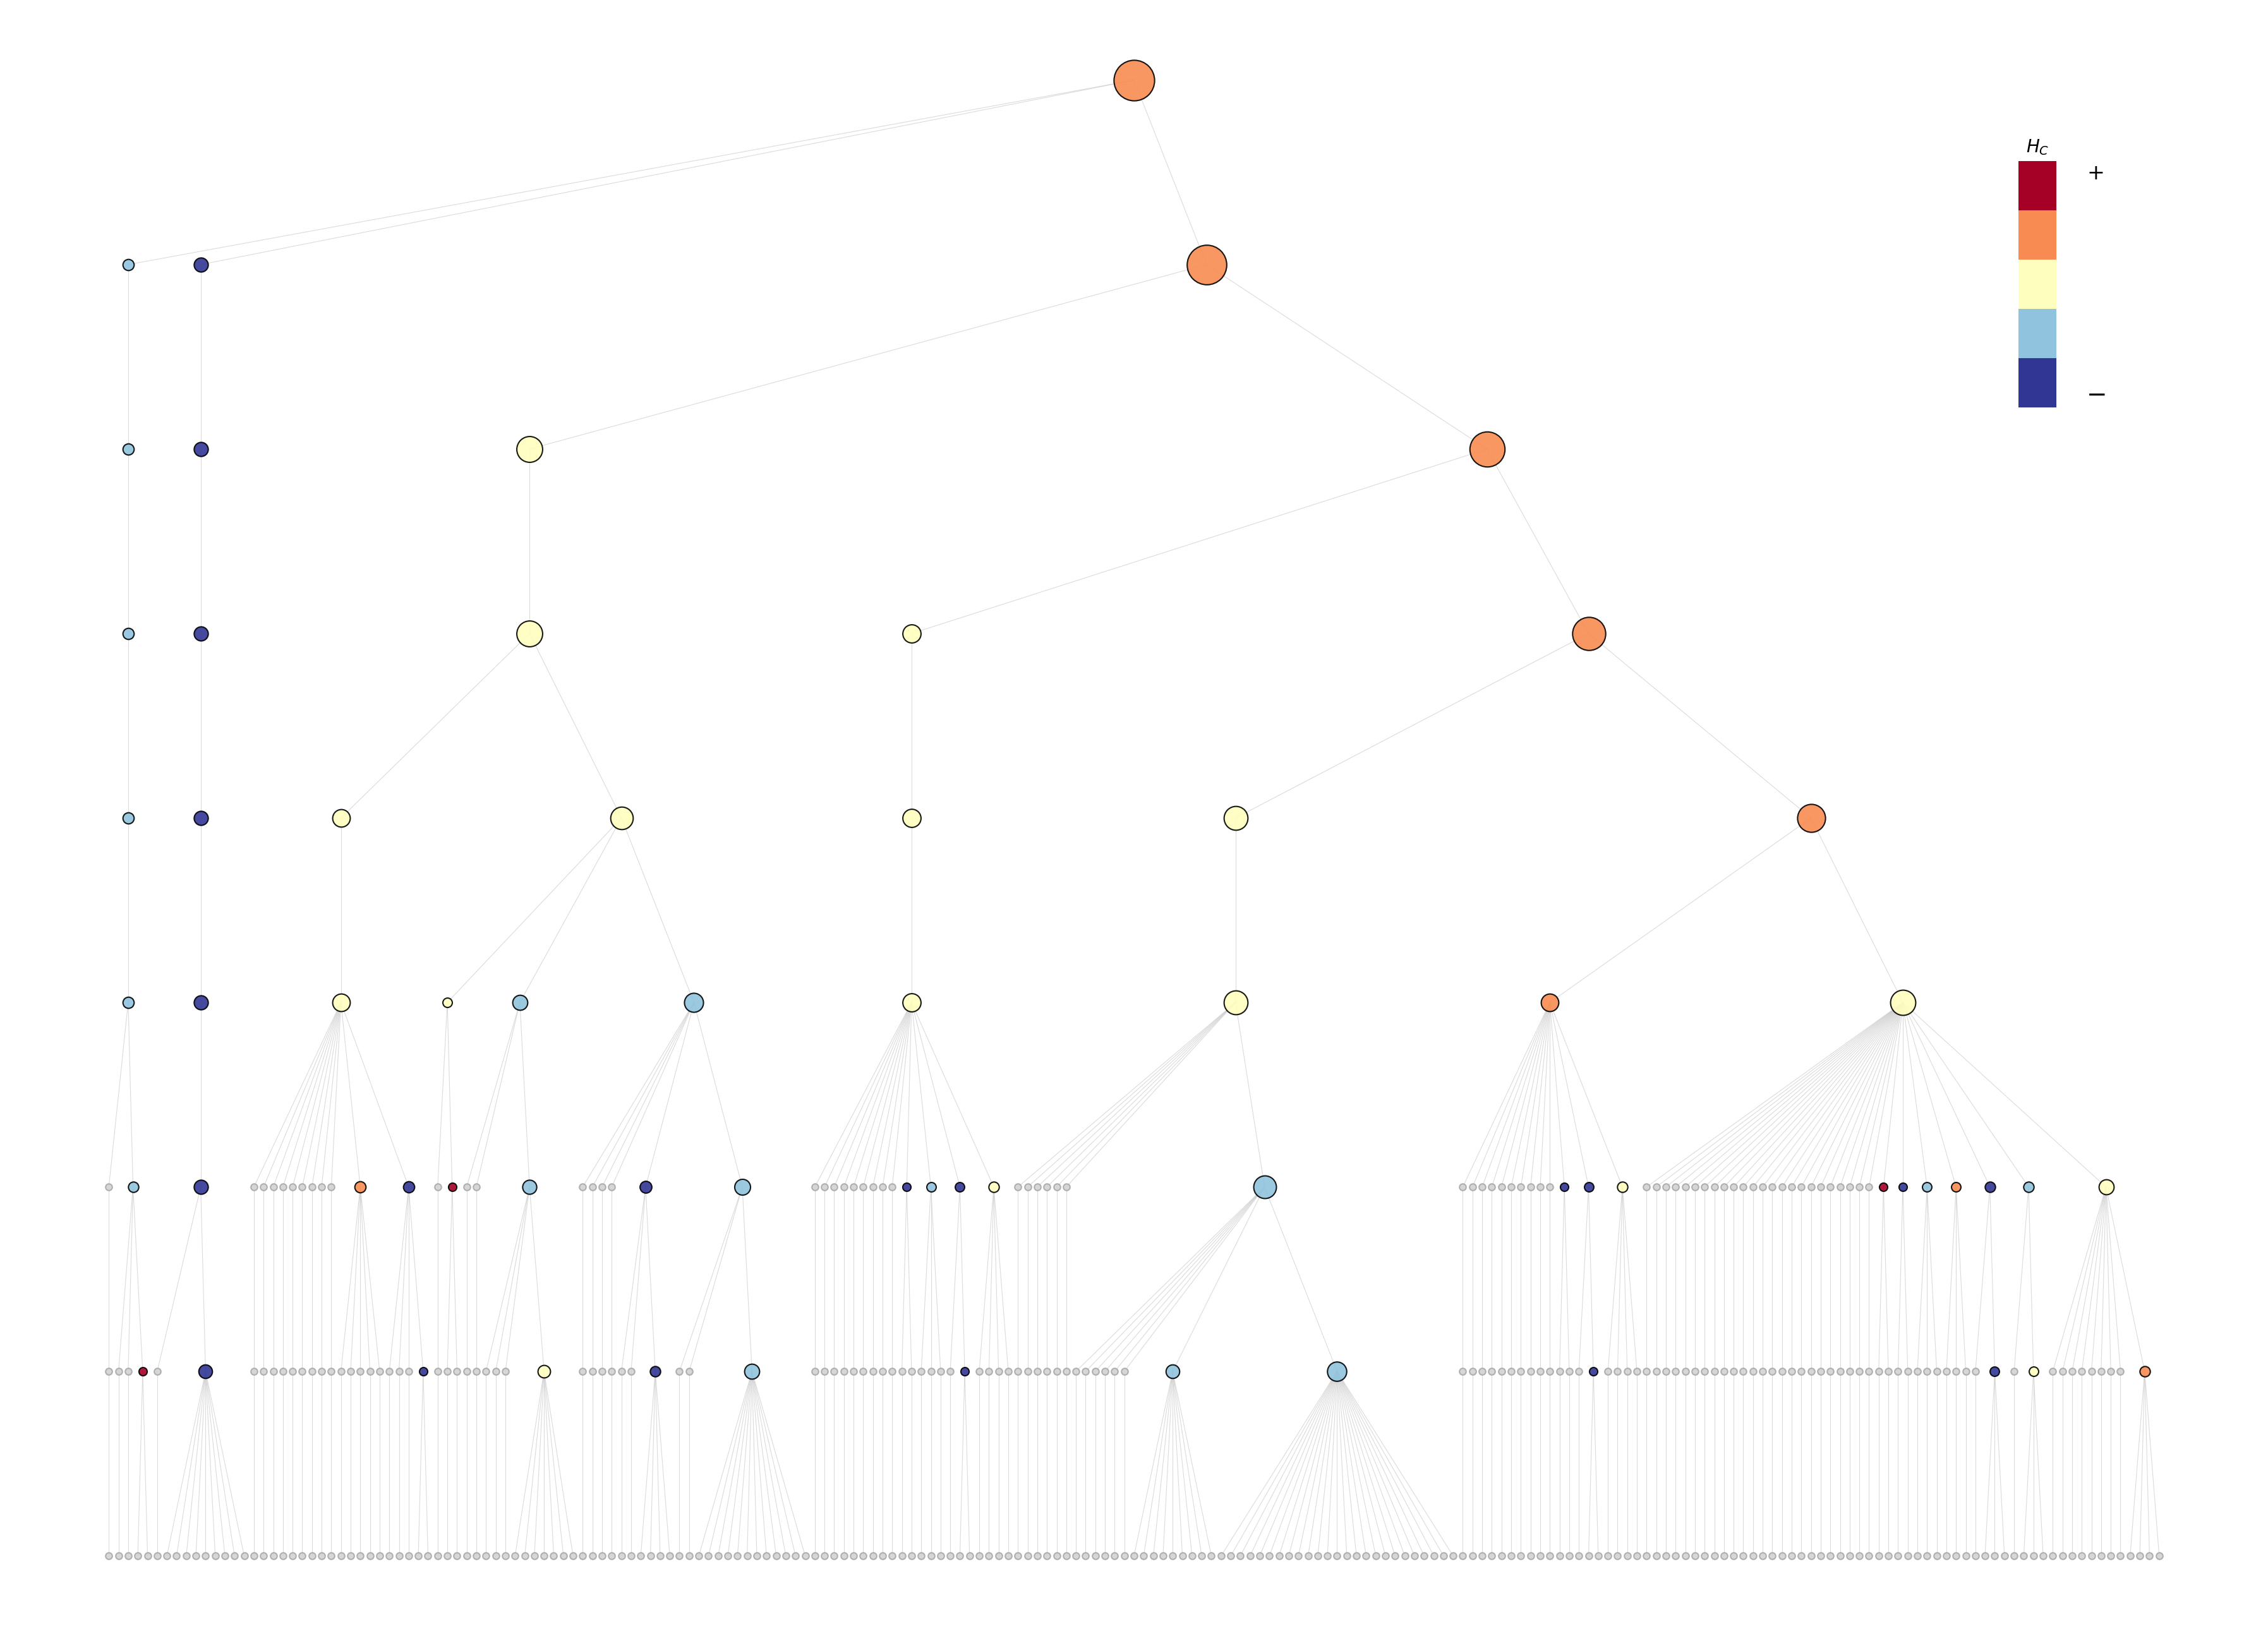


--- 脚本执行完毕 ---


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from collections import defaultdict
import networkx as nx
import numpy as np
import pandas as pd

# Import K-Means clustering algorithm
try:
    from sklearn.cluster import KMeans
except ImportError:
    print("="*60)
    print("❌ Error: This script requires the 'scikit-learn' library.")
    print("Please run: pip install scikit-learn in your terminal or notebook.")
    print("="*60)
    raise

# ============================================================================
# Final Solution: Advanced layout & H_C K-Means coloring (light leaf nodes)
# ============================================================================

def plot_dendrogram_with_hc_coloring(tree_graph, builder, hc_lookup_complete):
    """
    Plot dendrogram with advanced layout and H_C K-Means coloring scheme.
    
    Args:
        tree_graph (nx.DiGraph): Directed graph representation of the tree from percolation analysis.
        builder (CorrectDendrogramBuilder): Builder object containing all clustering details.
        hc_lookup_complete (dict): Dictionary with {frozenset(cities): H_C_value}.
    """
    # [Step 1] Key data check
    valid_hc_values = [v for v in hc_lookup_complete.values() if v is not None and np.isfinite(v)]
    if len(valid_hc_values) < 5:
        print("="*70)
        print("❌ Fatal Error: Plotting function terminated.")
        print(f"   Reason: The input 'hc_lookup_complete' contains fewer than 5 valid H_C values (currently {len(valid_hc_values)}).")
        print("   This is insufficient for K-Means advanced coloring (requires at least 5 data points).")
        print("\n   >>> Solution: Please check your data processing to ensure H_C values are computed for all intermediate clusters.")
        print("="*70)
        return

    print("--- Launching final plotting script (light leaf nodes) ---")
    print(f"✅ Data check passed, {len(valid_hc_values)} valid H_C values, advanced coloring will start.")

    # --- Step 2: Advanced layout calculation (adopted from previous final version) ---
    print("\n[Layout] Calculating advanced layout (ordinal height, weighted X-axis, persistence nodes)...")
    
    # a. Create "ordinal height" mapping
    all_unique_heights = sorted(list(set(c.height for c in builder.all_clusters.values())))
    height_to_y_level_map = {height: i for i, height in enumerate(all_unique_heights)}

    # b. Calculate node weights (for X-axis layout)
    memo = {}
    def count_cities_under_weighted(node):
        if node in memo: return memo[node]
        if tree_graph.out_degree(node) == 0: memo[node] = 1.0; return 1.0
        count = sum(count_cities_under_weighted(child) for child in tree_graph.successors(node))
        memo[node] = count
        return count
    root_node = [n for n, d in tree_graph.in_degree() if d == 0][0]
    count_cities_under_weighted(root_node)

    # c. Compute base layout for all "real" nodes
    real_pos = {}
    nodes_to_process = sorted(tree_graph.nodes(), key=lambda n: builder.all_clusters[n].height, reverse=True)
    leaf_spacing_factor = 1.2
    real_pos[root_node] = (0.0, height_to_y_level_map[builder.all_clusters[root_node].height])
    for parent_node in nodes_to_process:
        if parent_node not in real_pos: continue
        children = sorted(list(tree_graph.successors(parent_node)), key=lambda n: count_cities_under_weighted(n))
        if not children: continue
        parent_x, _ = real_pos[parent_node]
        total_child_width = sum(count_cities_under_weighted(c) for c in children) * leaf_spacing_factor
        current_x = parent_x - total_child_width / 2.0
        for child in children:
            child_width = count_cities_under_weighted(child) * leaf_spacing_factor
            child_x = current_x + child_width / 2.0
            child_y = height_to_y_level_map[builder.all_clusters[child].height]
            real_pos[child] = (child_x, child_y)
            current_x += child_width
            
    # d. Create "enhanced" nodes and edges for visualization (persistence nodes)
    viz_pos, viz_edges = dict(real_pos), []
    for parent, child in tree_graph.edges():
        parent_y, child_y = real_pos[parent][1], real_pos[child][1]
        if parent_y > child_y + 1:
            last_node_id = child
            for level in range(int(child_y) + 1, int(parent_y)):
                persistence_node_id = f"p_{child}_{level}"
                viz_pos[persistence_node_id] = (real_pos[child][0], level)
                viz_edges.append((last_node_id, persistence_node_id))
                last_node_id = persistence_node_id
            viz_edges.append((last_node_id, parent))
        else:
            viz_edges.append((child, parent))
    print("✅ Advanced layout calculation complete.")

    # --- Step 3: K-Means color grouping calculation (adopted from your V3 script) ---
    print("\n[Coloring] Performing K-Means color grouping calculation...")
    
    node_hc_map = {
        n: hc_lookup_complete.get(frozenset(builder.all_clusters[n].cities))
        for n in tree_graph.nodes()
    }
    
    valid_nodes = {n: hc for n, hc in node_hc_map.items() if hc is not None and np.isfinite(hc)}
    hc_values_array = np.array(list(valid_nodes.values())).reshape(-1, 1)
    
    kmeans = KMeans(n_clusters=5, random_state=42, n_init='auto').fit(hc_values_array)
    node_to_cluster_label = {node: kmeans.predict(np.array([[hc]]))[0] for node, hc in valid_nodes.items()}
    
    cluster_centers = kmeans.cluster_centers_.flatten()
    sorted_center_indices = np.argsort(cluster_centers)
    rank_map = {original_label: rank for rank, original_label in enumerate(sorted_center_indices)}
    colors = plt.cm.RdYlBu_r(np.linspace(0, 1, 5))
    print("✅ K-Means coloring scheme calculation complete.")

    # --- Step 4: Final plotting ---
    print("\n[Plotting] Starting final image rendering...")
    fig, ax = plt.subplots(1, 1, figsize=(40, 26))
    
    # a. Draw edges
    for u, v in viz_edges:
        if u in viz_pos and v in viz_pos:
            ax.plot([viz_pos[u][0], viz_pos[v][0]], [viz_pos[u][1], viz_pos[v][1]], 
                   color='#cccccc', zorder=1, linewidth=0.8, alpha=0.7)
    
    # b. Draw nodes
    unweighted_city_counts = {n: len(builder.all_clusters[n].cities) for n in tree_graph.nodes()}
    for node, p in viz_pos.items():
        is_persistence_node = str(node).startswith('p_')
        original_node_id = str(node).split('_')[1] if is_persistence_node else node
        
        size = 8 + unweighted_city_counts.get(original_node_id, 1)**0.7 * 50
        cities_count = unweighted_city_counts.get(original_node_id, 0)
        
        # Default edge color
        edge_color = 'black'
        
        # Coloring logic
        if cities_count <= 1:
            # ==========================================================
            # --- Core modification: apply lighter gray for leaf nodes ---
            # ==========================================================
            color = 'lightgray'  # Changed from 'gray' to 'lightgray'
            edge_color = 'darkgray' # Border changed to dark gray to match light fill
            
        elif original_node_id in valid_nodes:
            # Valid node, use K-Means result for coloring
            cluster_label = node_to_cluster_label[original_node_id]
            color_rank = rank_map[cluster_label]
            color = colors[color_rank]
        else:
            # Node without H_C value, use white
            color = 'white'
        
        ax.scatter(p[0], p[1], s=size, facecolor=color, edgecolor=edge_color, 
                   zorder=3, alpha=0.9, linewidth=1.5)

    # c. Add custom H_C legend
    ax_legend = fig.add_axes([0.8, 0.75, 0.015, 0.15])
    custom_cmap = mcolors.ListedColormap(colors)
    legend_data = np.arange(len(colors)).reshape(-1, 1)
    ax_legend.imshow(legend_data, cmap=custom_cmap, aspect='auto', origin='lower')
    ax_legend.set_title('$H_C$', fontsize=20, pad=10)
    ax_legend.text(1.8, 0.95, '+', transform=ax_legend.transAxes, ha='left', va='center', fontsize=24)
    ax_legend.text(1.8, 0.05, '−', transform=ax_legend.transAxes, ha='left', va='center', fontsize=28)
    ax_legend.set_xticks([]); ax_legend.set_yticks([])
    ax_legend.spines['top'].set_visible(False); ax_legend.spines['right'].set_visible(False)
    ax_legend.spines['bottom'].set_visible(False); ax_legend.spines['left'].set_visible(False)
    
    # d. Final style
    # No title
    ax.axis('off')
    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()
    print("\n--- Script execution complete ---")


# --- Run main function ---
if 'tree_graph' in globals() and 'percolation_tree_builder' in globals() and 'hc_lookup_complete' in globals():
    plot_dendrogram_with_hc_coloring(tree_graph, percolation_tree_builder, hc_lookup_complete)
else:
    print("\n❌ Error: Please prepare 'tree_graph', 'percolation_tree_builder', and 'hc_lookup_complete' before calling this function.")

##### Skill diversity

In [ ]:
import pandas as pd
import numpy as np

# Define your data file name
skill_file = 'skill.csv'

print(f"--- Start processing skill file: '{skill_file}' (final cleaned version) ---")

try:
    # --- Step 1: Load data ---
    rows_to_skip = 7 
    df_raw = pd.read_csv(skill_file, skiprows=rows_to_skip)
    print("✅ File loaded successfully!")

    # --- Step 2: (Core fix) Intelligently remove invalid rows at the end of the file ---
    ttwa_col_name = 'travel to work area 2011-based'
    
    # Check if 'Column Total' exists in TTWA column
    if 'Column Total' in df_raw[ttwa_col_name].values:
        # Find the first occurrence of 'Column Total'
        cutoff_index = df_raw[df_raw[ttwa_col_name] == 'Column Total'].index[0]
        # Keep only rows before 'Column Total'
        df_cleaned = df_raw.loc[:cutoff_index-1].copy()
        print(f"✅ Successfully removed 'Column Total' and all rows after it.")
    else:
        # If not found, just drop empty rows
        df_cleaned = df_raw.dropna(subset=[ttwa_col_name]).copy()
        print("⚠️ 'Column Total' row not found, only dropped empty rows.")

    # --- Step 3: Select required columns ---
    numerator_cols = [col for col in df_cleaned.columns if col.startswith('Numerator')]
    
    if len(numerator_cols) != 9:
        print(f"⚠️ Warning: Found {len(numerator_cols)} 'Numerator' columns, not the expected 9.")

    cols_to_keep = [ttwa_col_name] + numerator_cols
    df_selected = df_cleaned[cols_to_keep].copy()
    print("✅ Successfully selected TTWA name and 9 skill count columns.")

    # --- Step 4: Rename columns and clean data types ---
    rename_mapping = {ttwa_col_name: 'TTWA_NAME'}
    for i, old_col_name in enumerate(numerator_cols):
        rename_mapping[old_col_name] = f'skill_{i+1}_workers'
        
    df_renamed = df_selected.rename(columns=rename_mapping)
    
    final_skill_columns = [f'skill_{i+1}_workers' for i in range(9)]
    for col in final_skill_columns:
        df_renamed[col] = pd.to_numeric(df_renamed[col], errors='coerce')
        
    df_skills_final = df_renamed.fillna(0)
    for col in final_skill_columns:
        df_skills_final[col] = df_skills_final[col].astype(int)

    print("✅ Column renaming and data type cleaning completed.")

    # --- Step 5: Output final result ---
    print("\n\n--- All data processing completed ---")
    print("Preview of final cleaned skill data:")
    print(df_skills_final.head())
    
    output_filename = 'cleaned_ttwa_skills.csv'
    df_skills_final.to_csv(output_filename, index=False)
    print(f"\n✅ Cleaned data saved to file: '{output_filename}'")

except FileNotFoundError:
    print(f"❌ Fatal error: File '{skill_file}' not found.")
except KeyError:
    print(f"❌ Fatal error: Column 'travel to work area 2011-based' not found.")
    print(f"   This is likely due to incorrect `skiprows={rows_to_skip}` setting. Try adjusting this number.")
except Exception as e:
    print(f"❌ Unknown error occurred during processing: {e}")


--- 开始处理技能文件: 'skill.csv' (最终净化版) ---
✅ 文件读取成功！
✅ 已智能移除'Column Total'及其之后的所有无效行。
✅ 已成功筛选出TTWA名称和9个技能的计数值列。
✅ 列名重命名和数据类型清理完成。


--- 数据处理全部完成 ---
最终生成的干净技能数据预览：
                    TTWA_NAME  skill_1_workers  skill_2_workers  \
0                     Berwick             3000             3100   
1         Blyth and Ashington             7300            13000   
2                  Darlington             6200            12500   
3  Durham and Bishop Auckland             6400            27300   
4                  Hartlepool             3700             9300   

   skill_3_workers  skill_4_workers  skill_5_workers  skill_6_workers  \
0             4600             2600             2200             1700   
1            13000             7000             7300             9900   
2             6800             7000             4500             6100   
3            22400             7000            10100             9900   
4             5700             6500             3100             3000   


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import entropy
import os

# ============================================================================
# Independent Skill Diversity (H_S) Calculation Script (Corrected)
# ============================================================================

# --- Step 1: Define input file name ---
skills_file = 'cleaned_ttwa_skills.csv'
output_folder = 'skill_diversity_filter'
hs_results_file = os.path.join(output_folder, 'skills_diversity_Hs_results.csv')

print(f"--- Starting independent skill diversity (H_S) analysis ---")

# --- Step 2: Check and load required data ---
if 'critical_transitions_df' not in globals():
    print(f"❌ Fatal error: Missing 'critical_transitions_df' variable. Please run percolation analysis and critical point identification first.")
else:
    try:
        df_skills_raw = pd.read_csv(skills_file)
        df_skills_raw.set_index('TTWA_NAME', inplace=True)
        print("✅ Skill data file loaded successfully.")

        # --- Step 3: Merge 9 occupation categories into 4 skill levels ---
        print("Merging 9 occupation categories into 4 skill levels...")
        df_skills_merged = pd.DataFrame(index=df_skills_raw.index)
        df_skills_merged['skill_level_4'] = df_skills_raw['skill_1_workers'] + df_skills_raw['skill_2_workers']
        df_skills_merged['skill_level_3'] = df_skills_raw['skill_3_workers']
        df_skills_merged['skill_level_2'] = df_skills_raw['skill_4_workers'] + df_skills_raw['skill_5_workers'] + df_skills_raw['skill_6_workers'] + df_skills_raw['skill_7_workers']
        df_skills_merged['skill_level_1'] = df_skills_raw['skill_8_workers'] + df_skills_raw['skill_9_workers']
        print("✅ Skill category merging complete.")

        # --- Step 4: Define H_S calculation function ---
        def calculate_skills_diversity_final(skill_counts_for_cluster):
            NUM_CATEGORIES = 4.0
            total_workers = skill_counts_for_cluster.sum()
            if total_workers == 0: return 0.0
            prob_distribution = skill_counts_for_cluster[skill_counts_for_cluster > 0] / total_workers
            hs_raw = entropy(prob_distribution, base=2)
            num_skill_categories = len(prob_distribution)
            return hs_raw / np.log2(NUM_CATEGORIES) if num_skill_categories > 1 else 0.0

        # --- Step 5: Calculate H_S for each cluster in critical_transitions_df ---
        print("Calculating H_S value for each cluster in 'critical_transitions_df'...")
        hs_results = []
        skill_cols_to_sum = ['skill_level_1', 'skill_level_2', 'skill_level_3', 'skill_level_4']
        
        for index, row in critical_transitions_df.iterrows():
            tau = row['threshold']
            
            # *** Core correction ***
            # Directly use the 'clusters' column, no literal_eval conversion
            clusters_at_tau = row['clusters']
            
            # Ensure clusters_at_tau is iterable
            if not isinstance(clusters_at_tau, (list, np.ndarray)):
                print(f"⚠️ Warning: Non-list type found in clusters column at tau={tau}, skipping this row.")
                continue

            for i, cluster_nodes in enumerate(clusters_at_tau):
                if len(cluster_nodes) > 1:
                    skills_in_cluster = df_skills_merged.reindex(list(cluster_nodes))
                    total_skills_in_cluster = skills_in_cluster[skill_cols_to_sum].sum()
                    hs_value = calculate_skills_diversity_final(total_skills_in_cluster)
                    
                    hs_results.append({
                        'threshold': tau, 
                        'cluster_id': f"cluster_{i+1}_at_tau_{tau:.4f}", 
                        'cluster_size': len(cluster_nodes), 
                        'Hs_Skills_Diversity': hs_value,
                        'nodes': ", ".join(sorted(list(cluster_nodes)))
                    })
        
        df_hs_results = pd.DataFrame(hs_results)
        
        # --- Step 6: Save and preview H_S results ---
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)
        df_hs_results.to_csv(hs_results_file, index=False)
        
        print(f"\n✅ Skill diversity calculation complete!")
        print(f"✅ Results saved to new file: '{hs_results_file}'")
        print("\n--- Skill diversity (H_S) results preview ---")
        print(df_hs_results.head())

    except FileNotFoundError:
        print(f"❌ Fatal error: Skill data file '{skills_file}' not found.")
    except Exception as e:
        print(f"❌ Unknown error occurred during processing: {e}")

--- 开始独立的技能多样性 (H_S) 分析 ---
✅ 成功读取技能数据文件。
正在将9个职业类别合并为4个技能等级...
✅ 技能类别合并完成。
正在为 'critical_transitions_df' 中的每个集群计算H_S值...

✅ 技能多样性计算完成！
✅ 结果已保存到新文件: 'skill_diversity_filter/skills_diversity_Hs_results.csv'

--- 技能多样性 (H_S) 结果预览 ---
   threshold                cluster_id  cluster_size  Hs_Skills_Diversity  \
0   0.657136   cluster_1_at_tau_0.6571             4             0.900629   
1   0.657136  cluster_16_at_tau_0.6571             9             0.948941   
2   0.657136  cluster_20_at_tau_0.6571            25             0.941675   
3   0.657136  cluster_28_at_tau_0.6571             2             0.920324   
4   0.657136  cluster_39_at_tau_0.6571             7             0.946918   

                                               nodes  
0       Crawley, London, Medway, Slough and Heathrow  
1  Blyth and Ashington, Carlisle, Dalbeattie and ...  
2  Aberdeen, Arbroath and Montrose, Aviemore and ...  
3                                 Bournemouth, Poole  
4  Cardiff, Cardigan, Haverfor

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import entropy

# --- Calculate global skill diversity (corrected version) ---

# Assume df_skills_final and main_component_nodes already exist
if 'df_skills_final' in globals() and 'main_component_nodes' in globals():
    print("--- Step 1: Calculate skill diversity H_S for the complete network (τ=0) ---")
    
    # Select skill data for all cities in the largest connected component
    skills_complete_cluster_raw = df_skills_final[df_skills_final['TTWA_NAME'].isin(main_component_nodes)]
    
    # *** Core correction: merge 9 skill categories into 4 skill levels here ***
    print("   - Merging 9 skill categories into 4 skill levels...")
    df_skills_merged = pd.DataFrame()
    df_skills_merged['TTWA_NAME'] = skills_complete_cluster_raw['TTWA_NAME']
    
    df_skills_merged['skill_level_4'] = skills_complete_cluster_raw['skill_1_workers'] + skills_complete_cluster_raw['skill_2_workers']
    df_skills_merged['skill_level_3'] = skills_complete_cluster_raw['skill_3_workers']
    df_skills_merged['skill_level_2'] = (
        skills_complete_cluster_raw['skill_4_workers'] +
        skills_complete_cluster_raw['skill_5_workers'] +
        skills_complete_cluster_raw['skill_6_workers'] +
        skills_complete_cluster_raw['skill_7_workers']
    )
    df_skills_merged['skill_level_1'] = skills_complete_cluster_raw['skill_8_workers'] + skills_complete_cluster_raw['skill_9_workers']
    print("   - Skill category merging completed.")

    # Define the column names for the 4 skill levels
    skill_cols = ['skill_level_1', 'skill_level_2', 'skill_level_3', 'skill_level_4']
    
    # Sum the skill counts for all cities to get the skill composition of the whole network
    total_skills_complete_cluster = df_skills_merged[skill_cols].sum()
    
    # Define H_S calculation function
    def calculate_skills_diversity_corrected(skill_counts):
        NUM_CATEGORIES = 4.0
        total = skill_counts.sum()
        if total == 0: return 0.0
        prob = skill_counts / total
        hs_raw = entropy(prob, base=2)
        norm_factor = np.log2(NUM_CATEGORIES)
        return hs_raw / norm_factor

    # Calculate global H_S value
    hs_complete = calculate_skills_diversity_corrected(total_skills_complete_cluster)
    
    print(f"\n✅ Skill diversity H_S for the complete network (τ=0): {hs_complete:.4f}")
    
    # Save result for later plotting
    all_nodes_frozenset = frozenset(main_component_nodes)
    
else:
    print("❌ Error: Please make sure 'df_skills_final' and 'main_component_nodes' are defined first.")

❌ 错误：请先确保 'df_skills_final' 和 'main_component_nodes' 已定义。


在现实世界的发达经济体（如英国）中，几乎不可能出现极端不均衡的情况（例如，99%的工人都属于1级技能，其他三个等级加起来才1%）。大多数城市群，即使是产业单一的地区，为了维持基本运转，也必然会拥有管理者（技能4）、技术人员（技能3）、服务人员（技能2）和基础工人（技能1）。

In [110]:
import pandas as pd
import os

# 定义输入和输出文件名
skills_9_categories_file = 'cleaned_ttwa_skills.csv'
output_folder = 'commuting_analysis_final_results'
skills_4_levels_file = os.path.join(output_folder, 'skills_4_levels.csv')

print(f"--- 开始将9个技能类别合并为4个技能等级 ---")

try:
    # 1. 加载您已处理干净的技能数据
    df_skills_9_cat = pd.read_csv(skills_9_categories_file)
    print(f"✅ 成功读取文件: '{skills_9_categories_file}'")

    # 2. 创建一个新的DataFrame来存放合并后的结果
    df_skills_4_levels = pd.DataFrame()
    
    # 将TTWA名称列复制过来
    df_skills_4_levels['TTWA_NAME'] = df_skills_9_cat['TTWA_NAME']
    
    # 3. 根据官方对应关系进行合并
    # 技能等级 4 (最高): 对应 SOC大类 1, 2
    df_skills_4_levels['skill_level_4'] = df_skills_9_cat['skill_1_workers'] + df_skills_9_cat['skill_2_workers']
    
    # 技能等级 3: 对应 SOC大类 3
    df_skills_4_levels['skill_level_3'] = df_skills_9_cat['skill_3_workers']
    
    # 技能等级 2: 对应 SOC大类 4, 5, 6, 7
    df_skills_4_levels['skill_level_2'] = df_skills_9_cat['skill_4_workers'] + df_skills_9_cat['skill_5_workers'] + df_skills_9_cat['skill_6_workers'] + df_skills_9_cat['skill_7_workers']
    
    # 技能等级 1 (最低): 对应 SOC大类 8, 9
    df_skills_4_levels['skill_level_1'] = df_skills_9_cat['skill_8_workers'] + df_skills_9_cat['skill_9_workers']
    
    print("✅ 已成功将9个类别合并为4个技能等级。")

    # 4. 保存并预览新生成的数据
    # 确保输出文件夹存在
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        
    df_skills_4_levels.to_csv(skills_4_levels_file, index=False)
    
    print(f"\n✅ 合并后的数据已保存到新文件: '{skills_4_levels_file}'")
    print("\n--- 合并后数据预览 ---")
    print(df_skills_4_levels.head())
    
    # 我们可以用伦敦的数据来看一下分布
    print("\n以'London'为例，查看4个技能等级的分布：")
    london_skills = df_skills_4_levels[df_skills_4_levels['TTWA_NAME'] == 'London']
    if not london_skills.empty:
        print(london_skills)

except FileNotFoundError:
    print(f"❌ 致命错误: 找不到输入文件 '{skills_9_categories_file}'。请确保文件名正确。")
except KeyError as e:
    print(f"❌ 致命错误: 在文件中找不到必需的技能列。缺失的列: {e}")
except Exception as e:
    print(f"❌ 处理过程中发生未知错误: {e}")

--- 开始将9个技能类别合并为4个技能等级 ---
✅ 成功读取文件: 'cleaned_ttwa_skills.csv'
✅ 已成功将9个类别合并为4个技能等级。

✅ 合并后的数据已保存到新文件: 'commuting_analysis_final_results/skills_4_levels.csv'

--- 合并后数据预览 ---
                    TTWA_NAME  skill_level_4  skill_level_3  skill_level_2  \
0                     Berwick           6100           4600           8000   
1         Blyth and Ashington          20300          13000          30100   
2                  Darlington          18700           6800          20500   
3  Durham and Bishop Auckland          33700          22400          34700   
4                  Hartlepool          13000           5700          15100   

   skill_level_1  
0           2600  
1          12900  
2           8900  
3          25500  
4           8700  

以'London'为例，查看4个技能等级的分布：
   TTWA_NAME  skill_level_4  skill_level_3  skill_level_2  skill_level_1
93    London        2268700         795400        1190600         478300


In [ ]:
# Build hs_lookup_complete dictionary from df_hs_results
print("=== Building hs_lookup_complete from df_hs_results ===")

# Construct lookup dictionary from df_hs_results
hs_lookup_complete = {}

for index, row in df_hs_results.iterrows():
    nodes_str = row['nodes']
    hs_value = row['Hs_Skills_Diversity']
    
    # Convert node string to set of city names
    if isinstance(nodes_str, str):
        city_names = [name.strip() for name in nodes_str.split(',')]
        city_set = frozenset(city_names)
        hs_lookup_complete[city_set] = hs_value

print(f"✅ Successfully built hs_lookup_complete with {len(hs_lookup_complete)} keys")

# Add skill diversity for the complete network (τ=0)
def get_all_leaves_from_tree(tree_graph):
    """Get all leaf nodes from the tree graph"""
    leaves = set()
    for node in tree_graph.nodes():
        if tree_graph.out_degree(node) == 0:  # Leaf node
            leaves.add(node)
    return frozenset(leaves)

# Get all cities in the complete network
all_cities = get_all_leaves_from_tree(tree_graph)
print(f"Complete network contains {len(all_cities)} cities")

# Add skill diversity for the complete network
hs_lookup_complete[all_cities] = hs_complete
print(f"✅ Added skill diversity for the complete network: H_S = {hs_complete:.4f}")

# Validate data
print(f"\nFinal hs_lookup_complete contains {len(hs_lookup_complete)} keys")

# Show sample data
print("\nSkill diversity sample data:")
for i, (key, value) in enumerate(list(hs_lookup_complete.items())[:3]):
    print(f"  Key {i+1}: {list(key)[:3]}{'...' if len(key) > 3 else ''} (size: {len(key)})")
    print(f"    H_S value: {value:.4f}")

# Check matching with tree graph
print("\nChecking matches with tree graph:")
matches = 0
internal_nodes = [n for n in tree_graph.nodes() if tree_graph.out_degree(n) > 0]

for node in internal_nodes:
    leaves = frozenset(get_leaves_under_node_debug(node, tree_graph))
    if leaves in hs_lookup_complete:
        matches += 1
        
print(f"Number of matching nodes: {matches} / {len(internal_nodes)}")

# Check largest cluster (should be the complete network)
max_cluster_size = max(len(k) for k in hs_lookup_complete.keys())
max_cluster = [k for k in hs_lookup_complete.keys() if len(k) == max_cluster_size][0]
print(f"\nLargest cluster size: {max_cluster_size}")
print(f"Skill diversity of complete network: {hs_lookup_complete[max_cluster]:.4f}")

print(f"\n✅ hs_lookup_complete is ready!")


=== 从 df_hs_results 构建 hs_lookup_complete ===
✅ 成功构建 hs_lookup_complete，包含 51 个键
完整网络包含 213 个城市


NameError: name 'hs_complete' is not defined

In [ ]:
# ============================================================================
# Corrected code block
# ============================================================================

# Build hs_lookup_complete dictionary from df_hs_results
print("=== Building hs_lookup_complete from df_hs_results ===")

# Construct lookup dictionary from df_hs_results
hs_lookup_complete = {}

for index, row in df_hs_results.iterrows():
    nodes_str = row['nodes']
    hs_value = row['Hs_Skills_Diversity']
    
    if isinstance(nodes_str, str):
        city_names = [name.strip() for name in nodes_str.split(',')]
        city_set = frozenset(city_names)
        hs_lookup_complete[city_set] = hs_value

print(f"✅ Successfully built hs_lookup_complete with {len(hs_lookup_complete)} keys")

# --- Correction: Calculate hs_complete before using it ---

# 1. Define a function to get all leaf nodes from the tree (if not already defined)
def get_all_leaves_from_tree(tree_graph):
    """Get all leaf nodes (cities) from the tree graph"""
    return frozenset(node for node in tree_graph.nodes() if tree_graph.out_degree(node) == 0)

# 2. Get all city nodes in the complete network
all_cities = get_all_leaves_from_tree(tree_graph)
print(f"\nComplete network contains {len(all_cities)} cities")

# 3. Calculate skill diversity (H_S) for the complete network
print("Calculating skill diversity for the complete network...")
#   a. Extract skill data for all cities from df_skills_merged
skills_complete_network = df_skills_merged.reindex(list(all_cities))
#   b. Sum skill counts for all cities
total_skills_complete = skills_complete_network[['skill_level_1', 'skill_level_2', 'skill_level_3', 'skill_level_4']].sum()
#   c. Call function to calculate H_S value and assign to hs_complete
hs_complete = calculate_skills_diversity_final(total_skills_complete)
print(f"✅ Skill diversity for the complete network calculated: H_S = {hs_complete:.4f}")

# --- Now it is safe to use hs_complete ---
# 4. Add complete network diversity to the dictionary
hs_lookup_complete[all_cities] = hs_complete
print(f"✅ Added skill diversity for the complete network to hs_lookup_complete")

# --- Validation code remains unchanged ---
print(f"\nFinal hs_lookup_complete contains {len(hs_lookup_complete)} keys")

# Show sample data
print("\nSkill diversity sample data:")
# (To avoid errors if all_cities is not found, filter it out before sampling)
sample_keys = [k for k in hs_lookup_complete if len(k) != len(all_cities)]
for i, key in enumerate(sample_keys[:3]):
    value = hs_lookup_complete[key]
    print(f"  Key {i+1}: {list(key)[:3]}{'...' if len(key) > 3 else ''} (size: {len(key)})")
    print(f"    H_S value: {value:.4f}")

# Check matching with tree graph
print("\nChecking matches with tree graph:")
matches = 0
# Assume get_leaves_under_node_debug function is defined
internal_nodes = [n for n in tree_graph.nodes() if tree_graph.out_degree(n) > 0]
for node in internal_nodes:
    leaves = frozenset(get_leaves_under_node_debug(node, tree_graph))
    if leaves in hs_lookup_complete:
        matches += 1
        
print(f"Number of matching nodes: {matches} / {len(internal_nodes)}")

# Check largest cluster (should be the complete network)
max_cluster_size = max(len(k) for k in hs_lookup_complete.keys())
# Use all_cities as the key for lookup, which is more robust
print(f"\nLargest cluster size: {max_cluster_size}")
print(f"Skill diversity of complete network: {hs_lookup_complete[all_cities]:.4f}")

print(f"\n✅ hs_lookup_complete is ready!")


=== 从 df_hs_results 构建 hs_lookup_complete ===
✅ 成功从 df_hs_results 构建 hs_lookup_complete，包含 51 个键

完整网络包含 213 个城市
正在计算完整网络的技能多样性...
✅ 完整网络的技能多样性计算完成: H_S = 0.9358
✅ 已将完整网络的技能多样性添加到 hs_lookup_complete

最终的 hs_lookup_complete 包含 52 个键

技能多样性数据示例:
  键 1: ['Slough and Heathrow', 'London', 'Crawley']... (大小: 4)
    H_S 值: 0.9006
  键 2: ['Dumfries', 'Newcastle', 'Dalbeattie and Castle Douglas']... (大小: 9)
    H_S 值: 0.9489
  键 3: ['Aberdeen', 'Aviemore and Grantown-on-Spey', 'Livingston']... (大小: 25)
    H_S 值: 0.9417

检查与树状图的匹配:
匹配的节点数: 52 / 52

最大聚类大小: 213
完整网络的技能多样性: 0.9358

✅ hs_lookup_complete 已准备就绪！


--- Analyzing the distribution of hs_lookup_complete values ---
✅ Successfully extracted 52 H_S values.

--- Descriptive Statistics for H_S Values ---
count    52.000000
mean      0.928935
std       0.041100
min       0.735839
25%       0.928810
50%       0.939138
75%       0.945902
max       0.959377
----------------------------------------

--- Generating distribution plots... ---


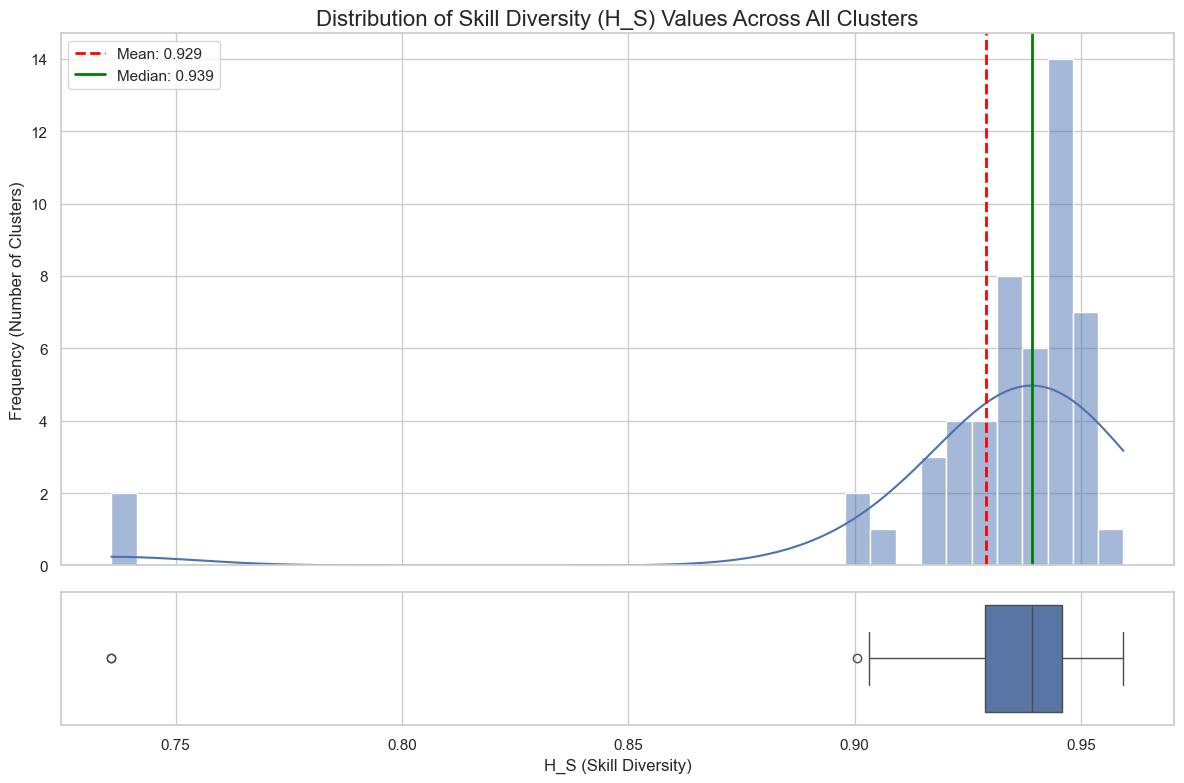


✅ Distribution plots generated successfully.

--- How to Interpret the Plots ---
1. **Descriptive Statistics**: The text output shows key metrics. 'mean' is the average, '50%' is the median.
2. **Histogram (Blue Bars)**: Shows the number of clusters that fall within a specific range of H_S values. Taller bars indicate more clusters in that range.
3. **Density Curve (Blue Line)**: A smoothed version of the histogram, showing the overall shape of the distribution.
4. **Box Plot (Bottom)**: 
   - **The Box**: Represents the middle 50% of your data (from the 25th to the 75th percentile).
   - **Green Line inside Box**: Represents the median (the 50th percentile).
   - **The 'Whiskers'**: Show the main range of the data.
   - **Diamonds outside Whiskers**: Represent potential outliers (clusters with unusually high or low H_S values).


In [114]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ============================================================================
# Analyze the distribution of hs_lookup_complete values (English Version)
# ============================================================================

print("--- Analyzing the distribution of hs_lookup_complete values ---")

# 1. Extract H_S values into a Pandas Series for analysis
try:
    hs_values = pd.Series(list(hs_lookup_complete.values()), name="Hs_Skills_Diversity")
    print(f"✅ Successfully extracted {len(hs_values)} H_S values.")
except NameError:
    print("❌ Error: The variable 'hs_lookup_complete' is not defined. Please run the previous cells to create it.")
    hs_values = None

if hs_values is not None:
    # 2. Print descriptive statistics
    print("\n--- Descriptive Statistics for H_S Values ---")
    print(hs_values.describe().to_string())
    print("-" * 40)


    # 3. Visualize the distribution using Matplotlib and Seaborn
    print("\n--- Generating distribution plots... ---")

    # Set the plot theme
    sns.set_theme(style="whitegrid")

    # Create a figure with two subplots (for histogram and boxplot)
    fig, (ax_hist, ax_box) = plt.subplots(
        2, 1,
        figsize=(12, 8),
        sharex=True,
        gridspec_kw={"height_ratios": (.8, .2)}
    )

    # Plot the histogram and Kernel Density Estimate (KDE) on the top subplot
    sns.histplot(hs_values, ax=ax_hist, kde=True, bins=40)
    ax_hist.set_title('Distribution of Skill Diversity (H_S) Values Across All Clusters', fontsize=16)
    ax_hist.set_ylabel('Frequency (Number of Clusters)')
    ax_hist.set_xlabel('') # Remove x-axis label for the top plot

    # Mark the mean and median on the plot
    mean_val = hs_values.mean()
    median_val = hs_values.median()
    ax_hist.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.3f}')
    ax_hist.axvline(median_val, color='green', linestyle='-', linewidth=2, label=f'Median: {median_val:.3f}')
    ax_hist.legend()


    # Plot the boxplot on the bottom subplot
    sns.boxplot(x=hs_values, ax=ax_box)
    ax_box.set_xlabel('H_S (Skill Diversity)', fontsize=12)

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

    print("\n✅ Distribution plots generated successfully.")
    print("\n--- How to Interpret the Plots ---")
    print("1. **Descriptive Statistics**: The text output shows key metrics. 'mean' is the average, '50%' is the median.")
    print("2. **Histogram (Blue Bars)**: Shows the number of clusters that fall within a specific range of H_S values. Taller bars indicate more clusters in that range.")
    print("3. **Density Curve (Blue Line)**: A smoothed version of the histogram, showing the overall shape of the distribution.")
    print("4. **Box Plot (Bottom)**: ")
    print("   - **The Box**: Represents the middle 50% of your data (from the 25th to the 75th percentile).")
    print("   - **Green Line inside Box**: Represents the median (the 50th percentile).")
    print("   - **The 'Whiskers'**: Show the main range of the data.")
    print("   - **Diamonds outside Whiskers**: Represent potential outliers (clusters with unusually high or low H_S values).")

--- 启动最终版绘图脚本 (高级布局 + H_S K-Means着色) ---

[布局] 正在计算高级布局（序数高度、权重X轴、持久化节点）...
✅ 高级布局计算完成。

[着色] 正在进行K-Means颜色分组计算...
✅ K-Means着色方案计算完成。

[绘图] 开始绘制最终图像...


/var/folders/c0/g_0prcks6s12wzk9s1vnm24w0000gn/T/ipykernel_15758/3713806289.py:159: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


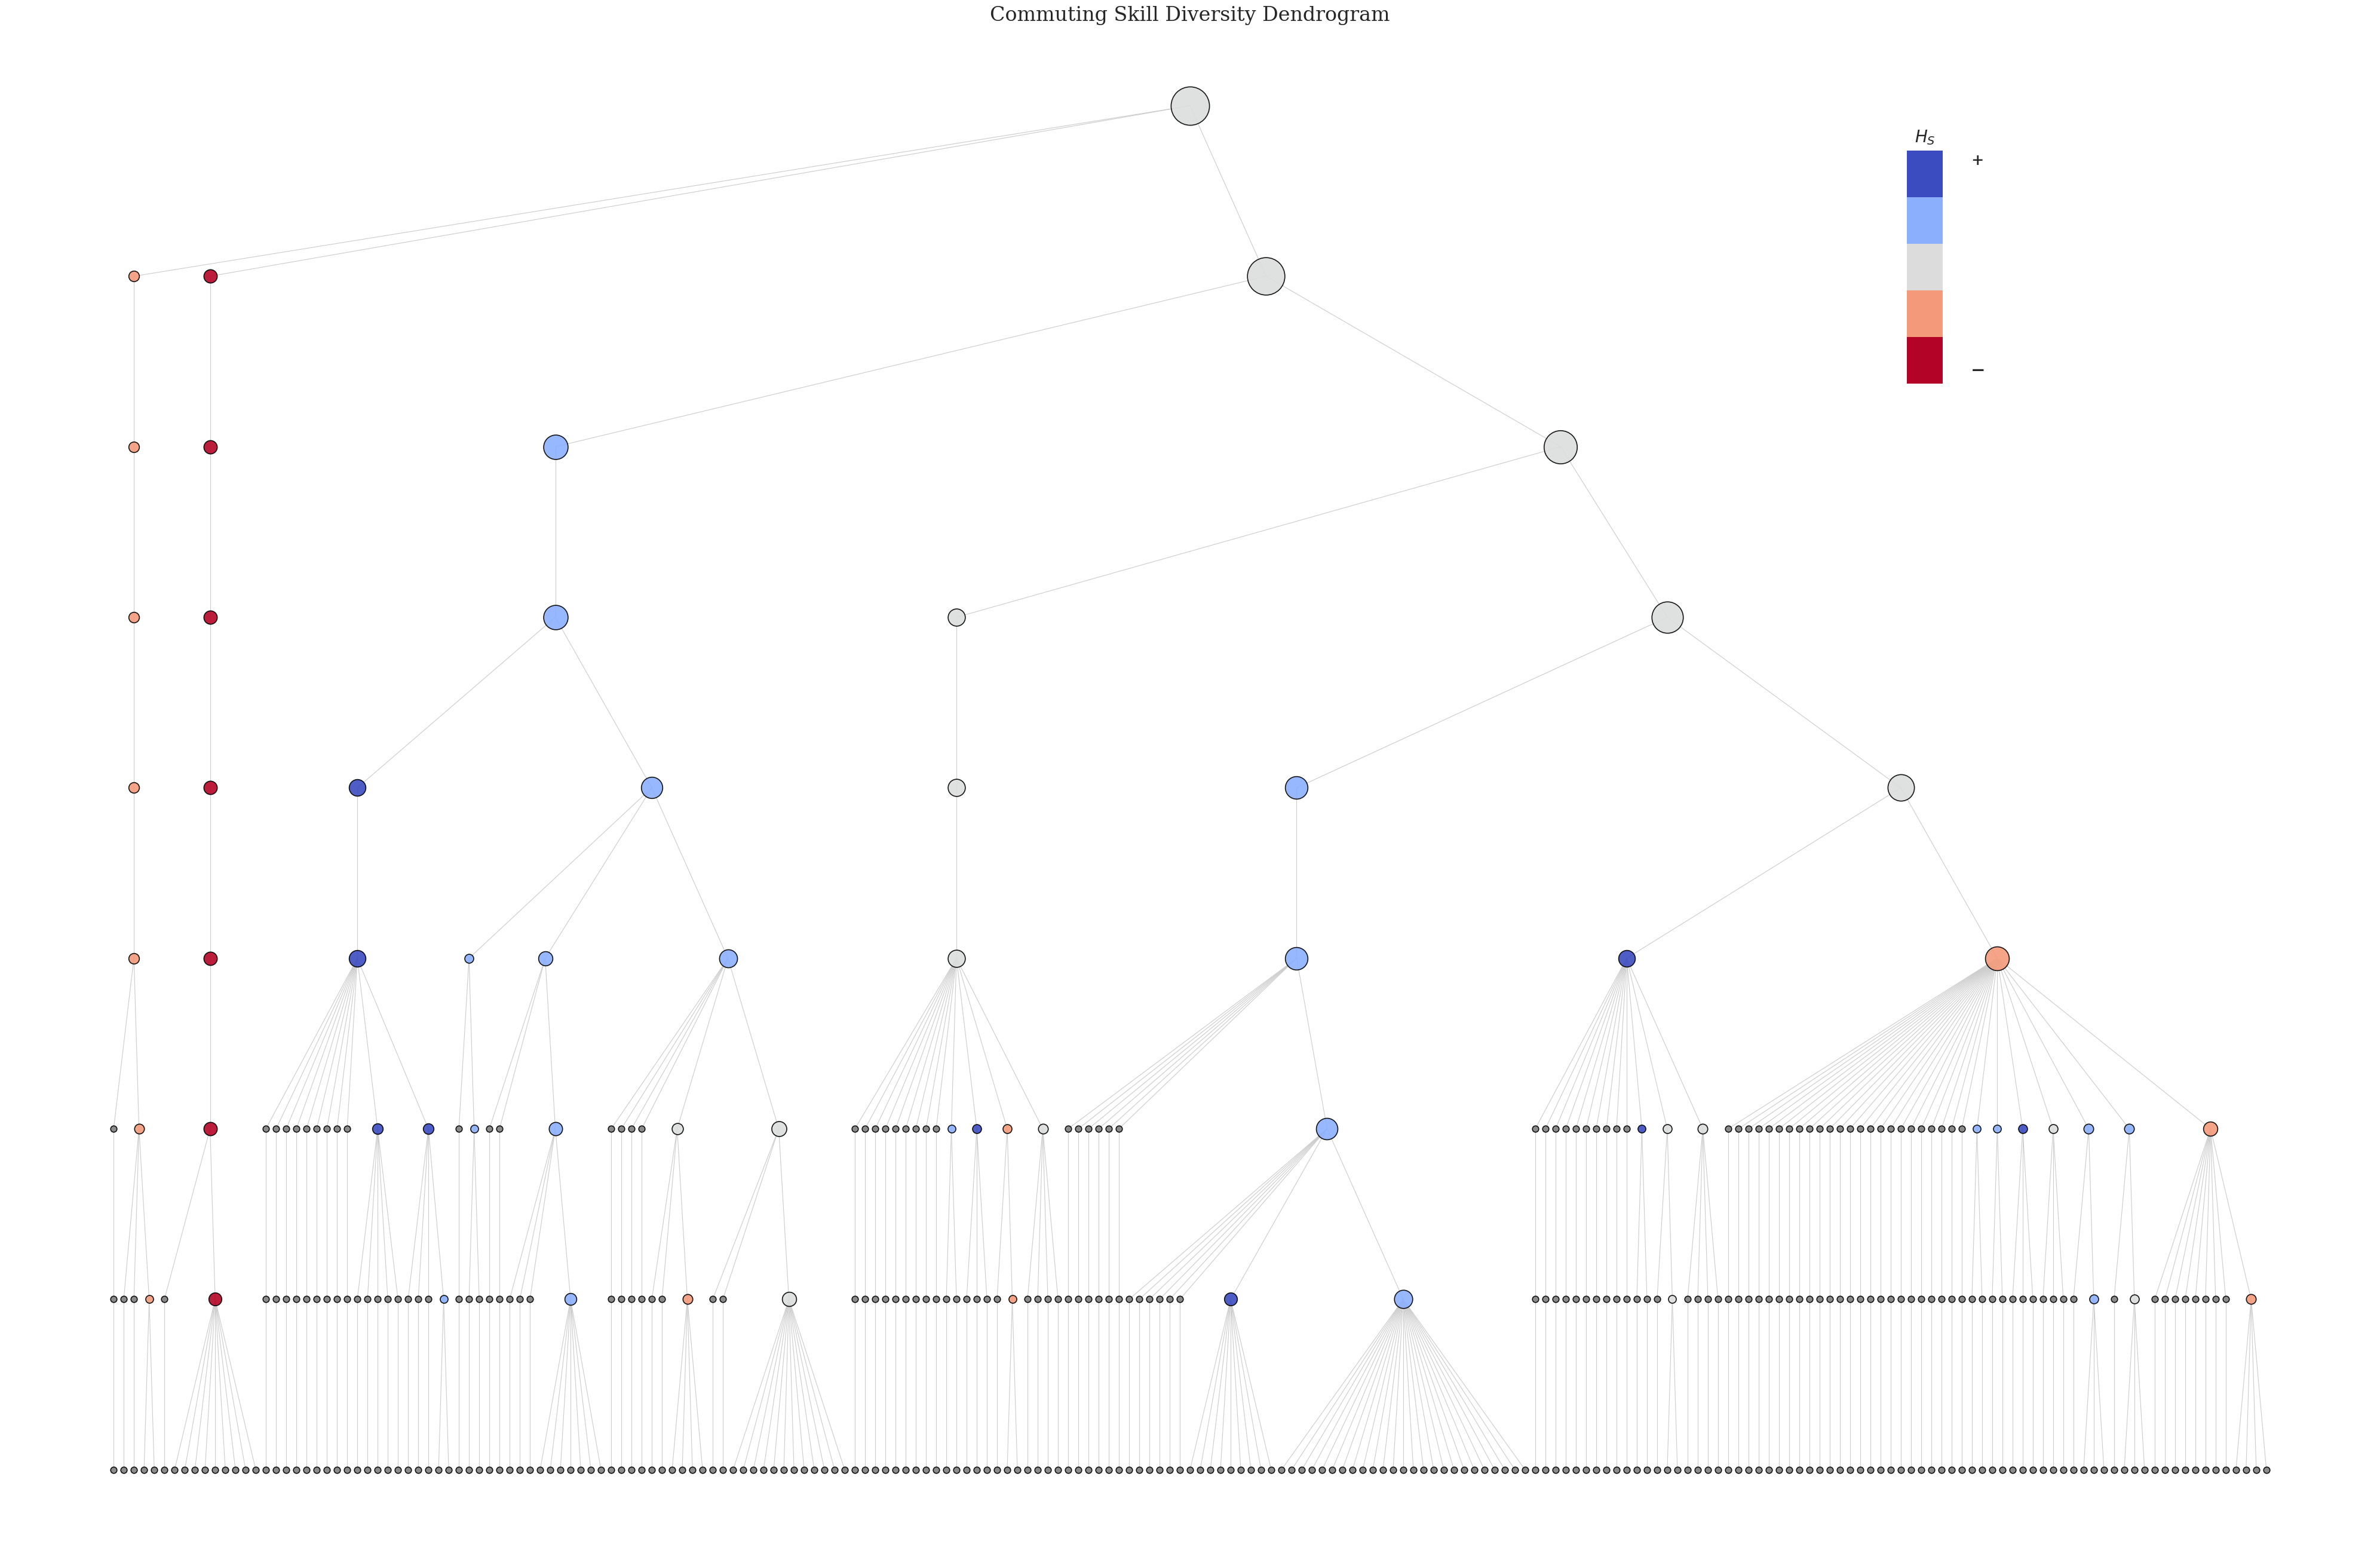


--- 脚本执行完毕 ---


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from collections import defaultdict
import networkx as nx
import numpy as np

# Import K-Means clustering algorithm
try:
    from sklearn.cluster import KMeans
except ImportError:
    print("="*60)
    print("❌ Error: This script requires the 'scikit-learn' library.")
    print("Please run: pip install scikit-learn in your terminal or notebook.")
    print("="*60)
    raise

# ============================================================================
# Final Solution: Advanced layout + H_S K-Means coloring dendrogram plot
# ============================================================================

def plot_dendrogram_with_hs_coloring(tree_graph, builder, hs_lookup_complete):
    """
    Plot a skill diversity dendrogram with advanced layout (no crossing)
    and H_S K-Means coloring scheme.

    Args:
        tree_graph (nx.DiGraph): Directed graph representation of the tree from percolation analysis.
        builder (CorrectDendrogramBuilder): Builder object containing all cluster details.
        hs_lookup_complete (dict): Dictionary with {frozenset(cities): H_S_value}.
    """
    print("--- Starting final plotting script (advanced layout + H_S K-Means coloring) ---")
    
    # --- Step 1: Compute advanced layout (adopted from previous final version) ---
    print("\n[Layout] Computing advanced layout (ordinal heights, weighted X-axis, persistence nodes)...")
    
    # a. Create "ordinal height" mapping
    all_unique_heights = sorted(list(set(c.height for c in builder.all_clusters.values())))
    height_to_y_level_map = {height: i for i, height in enumerate(all_unique_heights)}

    # b. Compute node weights (for X-axis layout)
    memo = {}
    def count_cities_under_weighted(node):
        if node in memo: return memo[node]
        if tree_graph.out_degree(node) == 0: memo[node] = 1.0; return 1.0
        count = sum(count_cities_under_weighted(child) for child in tree_graph.successors(node))
        memo[node] = count
        return count
    root_node = [n for n, d in tree_graph.in_degree() if d == 0][0]
    count_cities_under_weighted(root_node)

    # c. Compute base layout for all "real" nodes
    real_pos = {}
    nodes_to_process = sorted(tree_graph.nodes(), key=lambda n: builder.all_clusters[n].height, reverse=True)
    leaf_spacing_factor = 1.2
    real_pos[root_node] = (0.0, height_to_y_level_map[builder.all_clusters[root_node].height])
    for parent_node in nodes_to_process:
        if parent_node not in real_pos: continue
        children = sorted(list(tree_graph.successors(parent_node)), key=lambda n: count_cities_under_weighted(n))
        if not children: continue
        parent_x, _ = real_pos[parent_node]
        total_child_width = sum(count_cities_under_weighted(c) for c in children) * leaf_spacing_factor
        current_x = parent_x - total_child_width / 2.0
        for child in children:
            child_width = count_cities_under_weighted(child) * leaf_spacing_factor
            child_x = current_x + child_width / 2.0
            child_y = height_to_y_level_map[builder.all_clusters[child].height]
            real_pos[child] = (child_x, child_y)
            current_x += child_width
            
    # d. Create "enhanced" nodes and edges for visualization (persistence nodes)
    viz_pos, viz_edges = dict(real_pos), []
    for parent, child in tree_graph.edges():
        parent_y, child_y = real_pos[parent][1], real_pos[child][1]
        if parent_y > child_y + 1:
            last_node_id = child
            for level in range(int(child_y) + 1, int(parent_y)):
                persistence_node_id = f"p_{child}_{level}"
                viz_pos[persistence_node_id] = (real_pos[child][0], level)
                viz_edges.append((last_node_id, persistence_node_id))
                last_node_id = persistence_node_id
            viz_edges.append((last_node_id, parent))
        else:
            viz_edges.append((child, parent))
    print("✅ Advanced layout computation complete.")

    # --- Step 2: K-Means color grouping computation (adopted from your new script) ---
    print("\n[Coloring] Performing K-Means color grouping computation...")
    
    # a. Associate tree nodes with H_S values
    node_hs_map = {
        n: hs_lookup_complete.get(frozenset(builder.all_clusters[n].cities))
        for n in tree_graph.nodes()
    }
    
    # b. Prepare input data for K-Means
    valid_nodes = {n: hs for n, hs in node_hs_map.items() if hs is not None and np.isfinite(hs)}
    if len(valid_nodes) < 5:
        print(f"❌ Warning: Number of valid H_S values ({len(valid_nodes)}) is insufficient for 5 clusters. Plotting aborted.")
        return

    hs_values_array = np.array(list(valid_nodes.values())).reshape(-1, 1)
    
    # c. Run K-Means clustering
    kmeans = KMeans(n_clusters=5, random_state=42, n_init='auto').fit(hs_values_array)
    node_to_cluster_label = {node: kmeans.predict(np.array([[hs]]))[0] for node, hs in valid_nodes.items()}
    
    # d. Sort cluster results by H_S value and create color mapping
    cluster_centers = kmeans.cluster_centers_.flatten()
    sorted_center_indices = np.argsort(cluster_centers)
    rank_map = {original_label: rank for rank, original_label in enumerate(sorted_center_indices)}
    colors = plt.cm.coolwarm_r(np.linspace(0, 1, 5)) # Blue (low Hs) to Red (high Hs)
    print("✅ K-Means coloring scheme computation complete.")

    # --- Step 3: Final plotting ---
    print("\n[Plotting] Starting final plot rendering...")
    fig, ax = plt.subplots(1, 1, figsize=(40, 26))
    
    # a. Draw edges
    for u, v in viz_edges:
        if u in viz_pos and v in viz_pos:
            ax.plot([viz_pos[u][0], viz_pos[v][0]], [viz_pos[u][1], viz_pos[v][1]], 
                   color='#cccccc', zorder=1, linewidth=0.8)
    
    # b. Draw nodes
    unweighted_city_counts = {n: len(builder.all_clusters[n].cities) for n in tree_graph.nodes()}
    for node, p in viz_pos.items():
        is_persistence_node = str(node).startswith('p_')
        original_node_id = str(node).split('_')[1] if is_persistence_node else node
        
        size = 8 + unweighted_city_counts.get(original_node_id, 1)**0.7 * 50
        cities_count = unweighted_city_counts.get(original_node_id, 0)
        
        # Coloring logic
        if cities_count <= 1:
            color = 'gray'
        elif original_node_id not in valid_nodes:
            color = 'white'
        else:
            cluster_label = node_to_cluster_label[original_node_id]
            color_rank = rank_map[cluster_label]
            color = colors[color_rank]
        
        ax.scatter(p[0], p[1], s=size, facecolor=color, edgecolor='black', zorder=2, alpha=0.9, linewidth=1.2)

    # c. Add custom H_S legend (adopted from your new script)
    ax_legend = fig.add_axes([0.8, 0.75, 0.015, 0.15])
    custom_cmap = mcolors.ListedColormap(colors)
    legend_data = np.arange(len(colors)).reshape(-1, 1)
    ax_legend.imshow(legend_data, cmap=custom_cmap, aspect='auto', origin='lower')
    ax_legend.set_title('$H_S$', fontsize=20, pad=10)
    ax_legend.text(1.8, 0.95, '+', transform=ax_legend.transAxes, ha='left', va='center', fontsize=24) # High Hs
    ax_legend.text(1.8, 0.05, '−', transform=ax_legend.transAxes, ha='left', va='center', fontsize=28) # Low Hs
    ax_legend.set_xticks([]); ax_legend.set_yticks([])
    ax_legend.spines['top'].set_visible(False); ax_legend.spines['right'].set_visible(False)
    ax_legend.spines['bottom'].set_visible(False); ax_legend.spines['left'].set_visible(False)
    
    # d. Final style
    ax.set_title('Commuting Skill Diversity Dendrogram', fontsize=24, family='serif', pad=20)
    ax.axis('off')
    plt.tight_layout()
    plt.show()
    print("\n--- Script execution complete ---")


# --- Main function execution ---
# Make sure the following variables are prepared in your environment:
# 1. tree_graph: nx.DiGraph object generated by previous version
# 2. percolation_tree_builder: builder object generated by previous version
# 3. hs_lookup_complete: your dictionary containing H_S values
if 'tree_graph' in globals() and 'percolation_tree_builder' in globals() and 'hs_lookup_complete' in globals():
    plot_dendrogram_with_hs_coloring(tree_graph, percolation_tree_builder, hs_lookup_complete)
else:
    print("\n❌ Error: Please prepare 'tree_graph', 'percolation_tree_builder', and 'hs_lookup_complete' before calling this function.")

--- 启动最终版绘图脚本 (高级布局 + H_S 蓝-黄-红着色) ---

[布局] 正在计算高级布局...
✅ 高级布局计算完成。

[着色] 正在进行K-Means颜色分组计算...
✅ K-Means着色方案计算完成。

[绘图] 开始绘制最终图像...


/var/folders/c0/g_0prcks6s12wzk9s1vnm24w0000gn/T/ipykernel_15758/812461196.py:166: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


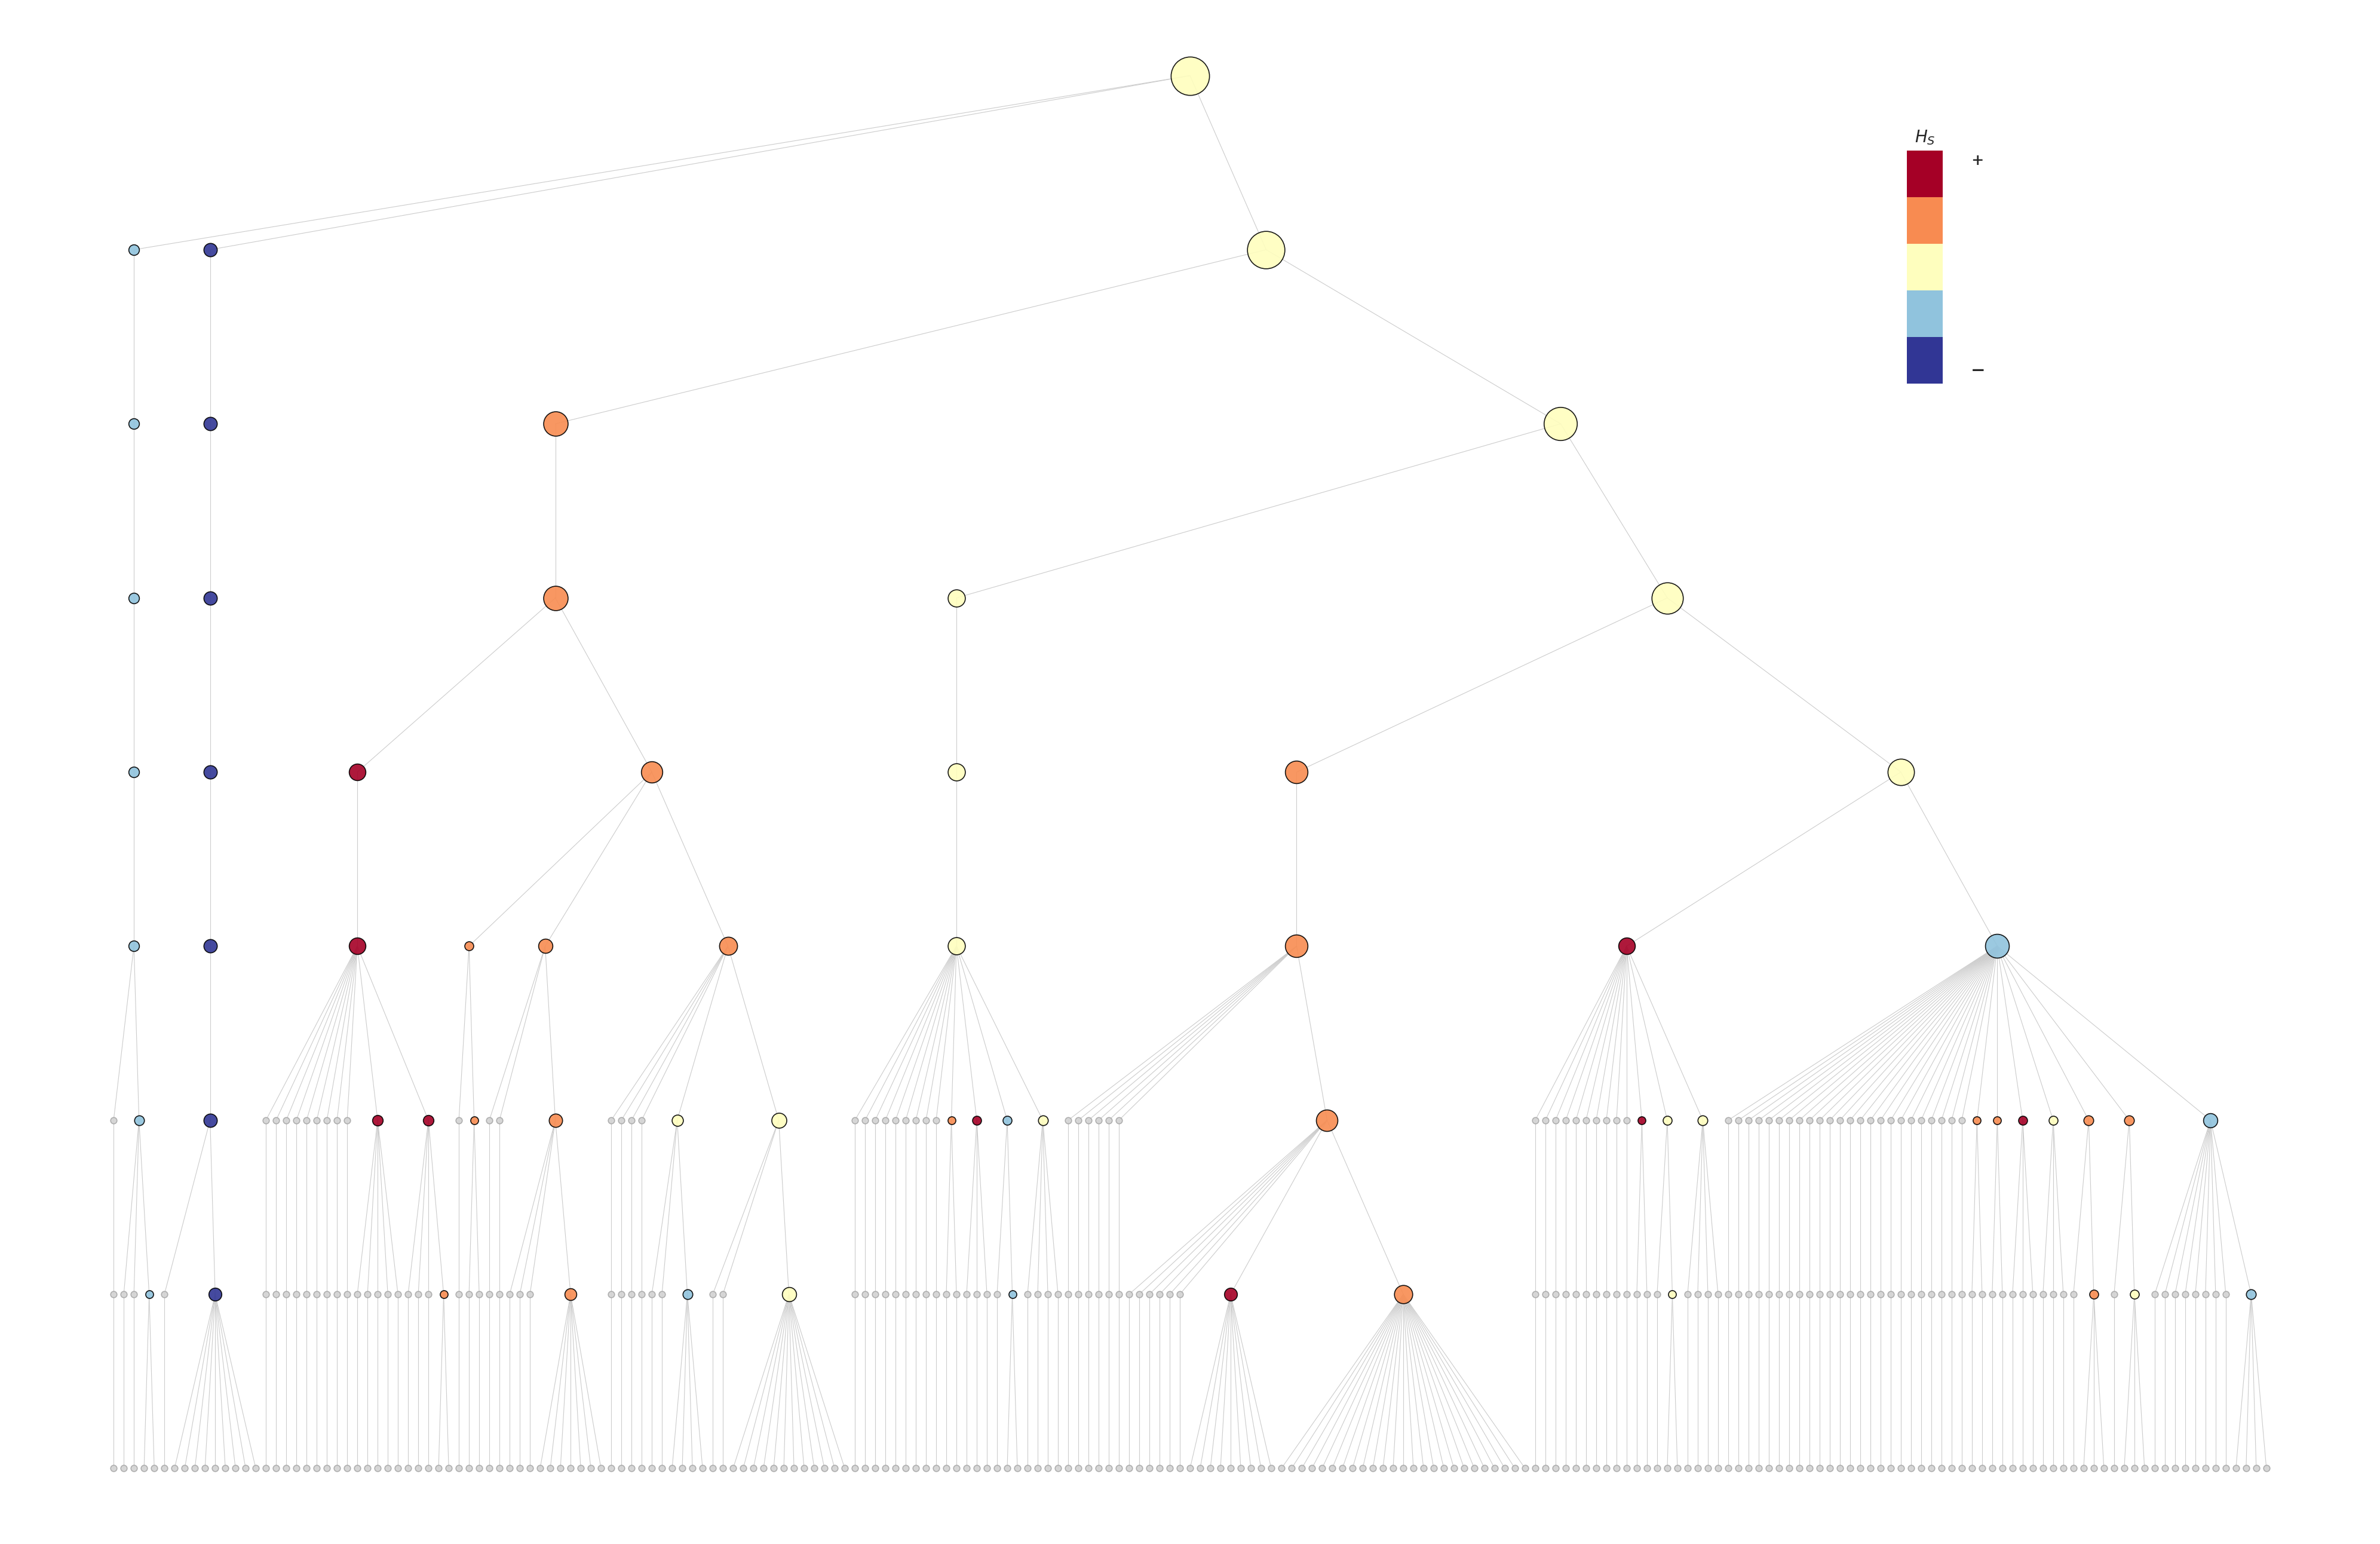


--- 脚本执行完毕 ---


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from collections import defaultdict
import networkx as nx
import numpy as np

# Import K-Means clustering algorithm
try:
    from sklearn.cluster import KMeans
except ImportError:
    print("="*60)
    print("❌ Error: This script requires the 'scikit-learn' library.")
    print("Please run: pip install scikit-learn")
    print("="*60)
    raise

# ============================================================================
# Final Solution: Advanced layout + H_S (Blue-Yellow-Red) K-Means coloring
# ============================================================================

def plot_dendrogram_with_hs_coloring(tree_graph, builder, hs_lookup_complete):
    """
    Plot a skill diversity dendrogram with advanced layout (no crossing)
    and H_S (Blue-Yellow-Red) K-Means coloring scheme.

    Args:
        tree_graph (nx.DiGraph): Directed graph representation of the tree from percolation analysis.
        builder (CorrectDendrogramBuilder): Builder object containing all clustering details.
        hs_lookup_complete (dict): Dictionary of {frozenset(cities): H_S_value}.
    """
    print("--- Starting final plotting script (advanced layout + H_S blue-yellow-red coloring) ---")
    
    # [Step 1] Data check
    valid_hs_values = [v for v in hs_lookup_complete.values() if v is not None and np.isfinite(v)]
    if len(valid_hs_values) < 5:
        print(f"❌ Warning: Number of valid H_S values ({len(valid_hs_values)}) is insufficient for 5 clusters. Plotting aborted.")
        return

    # --- Step 2: Compute advanced layout (adopted from previous final version) ---
    print("\n[Layout] Computing advanced layout...")
    
    # a. Create "ordinal height" mapping
    all_unique_heights = sorted(list(set(c.height for c in builder.all_clusters.values())))
    height_to_y_level_map = {height: i for i, height in enumerate(all_unique_heights)}

    # b. Compute node weights (for X-axis layout)
    memo = {}
    def count_cities_under_weighted(node):
        if node in memo: return memo[node]
        if tree_graph.out_degree(node) == 0: memo[node] = 1.0; return 1.0
        count = sum(count_cities_under_weighted(child) for child in tree_graph.successors(node))
        memo[node] = count
        return count
    root_node = [n for n, d in tree_graph.in_degree() if d == 0][0]
    count_cities_under_weighted(root_node)

    # c. Compute base layout for all "real" nodes
    real_pos = {}
    nodes_to_process = sorted(tree_graph.nodes(), key=lambda n: builder.all_clusters[n].height, reverse=True)
    leaf_spacing_factor = 1.2
    real_pos[root_node] = (0.0, height_to_y_level_map[builder.all_clusters[root_node].height])
    for parent_node in nodes_to_process:
        if parent_node not in real_pos: continue
        children = sorted(list(tree_graph.successors(parent_node)), key=lambda n: count_cities_under_weighted(n))
        if not children: continue
        parent_x, _ = real_pos[parent_node]
        total_child_width = sum(count_cities_under_weighted(c) for c in children) * leaf_spacing_factor
        current_x = parent_x - total_child_width / 2.0
        for child in children:
            child_width = count_cities_under_weighted(child) * leaf_spacing_factor
            child_x = current_x + child_width / 2.0
            child_y = height_to_y_level_map[builder.all_clusters[child].height]
            real_pos[child] = (child_x, child_y)
            current_x += child_width
            
    # d. Create "persistent" nodes and edges for visualization
    viz_pos, viz_edges = dict(real_pos), []
    for parent, child in tree_graph.edges():
        parent_y, child_y = real_pos[parent][1], real_pos[child][1]
        if parent_y > child_y + 1:
            last_node_id = child
            for level in range(int(child_y) + 1, int(parent_y)):
                persistence_node_id = f"p_{child}_{level}"
                viz_pos[persistence_node_id] = (real_pos[child][0], level)
                viz_edges.append((last_node_id, persistence_node_id))
                last_node_id = persistence_node_id
            viz_edges.append((last_node_id, parent))
        else:
            viz_edges.append((child, parent))
    print("✅ Advanced layout computed.")

    # --- Step 3: K-Means color grouping (adopted from your V4.1 script) ---
    print("\n[Coloring] Performing K-Means color grouping...")
    
    # a. Associate tree nodes with H_S values
    node_hs_map = {
        n: hs_lookup_complete.get(frozenset(builder.all_clusters[n].cities))
        for n in tree_graph.nodes()
    }
    
    # b. Prepare input data for K-Means
    valid_nodes = {n: hs for n, hs in node_hs_map.items() if hs is not None and np.isfinite(hs)}
    hs_values_array = np.array(list(valid_nodes.values())).reshape(-1, 1)
    
    # c. Run K-Means clustering
    kmeans = KMeans(n_clusters=5, random_state=42, n_init='auto').fit(hs_values_array)
    node_to_cluster_label = {node: kmeans.predict(np.array([[hs]]))[0] for node, hs in valid_nodes.items()}
    
    # d. Sort clusters by H_S value and create color mapping
    cluster_centers = kmeans.cluster_centers_.flatten()
    sorted_center_indices = np.argsort(cluster_centers)
    rank_map = {original_label: rank for rank, original_label in enumerate(sorted_center_indices)}
    
    # [Core change] Use "Blue -> Yellow -> Red" color palette
    colors = plt.cm.RdYlBu_r(np.linspace(0, 1, 5))
    print("✅ K-Means coloring computed.")

    # --- Step 4: Final plotting ---
    print("\n[Plotting] Drawing final figure...")
    fig, ax = plt.subplots(1, 1, figsize=(40, 26))
    
    # a. Draw edges
    for u, v in viz_edges:
        if u in viz_pos and v in viz_pos:
            ax.plot([viz_pos[u][0], viz_pos[v][0]], [viz_pos[u][1], viz_pos[v][1]], 
                   color='#cccccc', zorder=1, linewidth=0.8)
    
    # b. Draw nodes
    unweighted_city_counts = {n: len(builder.all_clusters[n].cities) for n in tree_graph.nodes()}
    for node, p in viz_pos.items():
        is_persistence_node = str(node).startswith('p_')
        original_node_id = str(node).split('_')[1] if is_persistence_node else node
        
        size = 8 + unweighted_city_counts.get(original_node_id, 1)**0.7 * 50
        cities_count = unweighted_city_counts.get(original_node_id, 0)
        
        edge_color = 'black'
        
        # Coloring logic
        if cities_count <= 1:
            color = 'lightgray' # Use light gray for leaves
            edge_color = 'darkgray'
        elif original_node_id not in valid_nodes:
            color = 'white'
        else:
            cluster_label = node_to_cluster_label[original_node_id]
            color_rank = rank_map[cluster_label]
            color = colors[color_rank]
        
        ax.scatter(p[0], p[1], s=size, facecolor=color, edgecolor=edge_color, zorder=2, alpha=0.9, linewidth=1.2)

    # c. Add custom H_S legend (adopted from your V4.1 script)
    ax_legend = fig.add_axes([0.8, 0.75, 0.015, 0.15])
    custom_cmap = mcolors.ListedColormap(colors)
    legend_data = np.arange(len(colors)).reshape(-1, 1)
    ax_legend.imshow(legend_data, cmap=custom_cmap, aspect='auto', origin='lower')
    ax_legend.set_title('$H_S$', fontsize=20, pad=10)
    ax_legend.text(1.8, 0.95, '+', transform=ax_legend.transAxes, ha='left', va='center', fontsize=24) # High Hs
    ax_legend.text(1.8, 0.05, '−', transform=ax_legend.transAxes, ha='left', va='center', fontsize=28) # Low Hs
    ax_legend.set_xticks([]); ax_legend.set_yticks([])
    ax_legend.spines['top'].set_visible(False); ax_legend.spines['right'].set_visible(False)
    ax_legend.spines['bottom'].set_visible(False); ax_legend.spines['left'].set_visible(False)
    
    # d. Final style
    ax.axis('off')
    plt.tight_layout()
    plt.show()
    print("\n--- Script finished ---")


# --- Run main function ---
if 'tree_graph' in globals() and 'percolation_tree_builder' in globals() and 'hs_lookup_complete' in globals():
    plot_dendrogram_with_hs_coloring(tree_graph, percolation_tree_builder, hs_lookup_complete)
else:
    print("\n❌ Error: Please prepare 'tree_graph', 'percolation_tree_builder', and 'hs_lookup_complete' before calling this function.")

##### Correlation


In [ ]:
# Assume you have already run previous code and obtained G and df_with_weights

print("--- Starting calculation of network centrality metrics ---")

# --- Step 1: Calculate weighted in-degree ---
# G.in_degree() returns a special object with (node, degree) pairs
# Use weight='flow' to specify the edge weight, which corresponds to the 'flow' attribute you added to edges
# If you want to use 'dependency_weight' as the weight, just change weight='flow' to weight='dependency_weight'
print("   Step 1/4: Calculating weighted in-degree...")
in_degree_weighted = dict(G.in_degree(weight='flow'))

# --- Step 2: Convert results to Pandas DataFrame ---
print("   Step 2/4: Converting results to DataFrame...")
df_metrics = pd.DataFrame.from_dict(
    in_degree_weighted, 
    orient='index', 
    columns=['in_degree_weighted']
)
df_metrics.index.name = 'TTWA_Code'
df_metrics.reset_index(inplace=True)

# --- Step 3: Add TTWA names for readability ---
# Extract TTWA code and name mapping from your original df_with_weights data
# Here, it assumes the destination columns are 'DEST_TTWA' and 'DEST_TTWA_NAME'; modify as needed for your data
print("   Step 3/4: Adding TTWA names...")
try:
    ttwa_names = df_with_weights[['DEST_TTWA', 'DEST_TTWA_NAME']].drop_duplicates().rename(
        columns={'DEST_TTWA': 'TTWA_Code', 'DEST_TTWA_NAME': 'TTWA_Name'}
    )
    # Merge names into metrics DataFrame
    final_df = pd.merge(ttwa_names, df_metrics, on='TTWA_Code', how='right')

except KeyError:
    print("   Warning: 'DEST_TTWA_NAME' column not found, output will not include TTWA names.")
    final_df = df_metrics

# --- Step 4: Save to CSV file ---
OUTPUT_FILE = 'inter_city_in_degree_metrics_filter.csv'
print(f"   Step 4/4: Saving results to '{OUTPUT_FILE}'...")
final_df.to_csv(OUTPUT_FILE, index=False)

print("\n✅ Success! City centrality metrics have been calculated.")
print(f"Output file: {OUTPUT_FILE}")
print("\nPreview of file contents:")
print(final_df.sort_values('in_degree_weighted', ascending=False).head())


--- 开始计算网络中心性指标 ---
   Step 1/4: 正在计算加权入度...
   Step 2/4: 正在将结果整理成表格...
   Step 3/4: 正在添加TTWA名称...
   Step 4/4: 正在将结果保存至 'inter_city_in_degree_metrics_filter.csv'...

✅ 成功！城市地位指标已计算完毕。
产出文件: inter_city_in_degree_metrics_filter.csv

文件内容预览:
              TTWA_Code  in_degree_weighted
1                London          71804646.0
0   Slough and Heathrow          25306957.0
8            Manchester          13379267.0
11           Birmingham          12635241.0
14                Leeds          12215885.0


由于本研究使用的通勤数据集专注于流向核心经济枢纽的移动，我们的回归分析样本被限定在数据集中in-degree不为零的113个核心旅行到工作区域（TTWAs）。这一方法确保了我们的模型专注于检验那些作为通勤目的地的城市的内部特征与其网络地位之间的关系。

--- 最终分析：合并数据与检验假设 ---

 tahap 1/4: 正在读取所有数据文件...
 tahap 2/4: 正在进行数据清理与准备...
   检测到文件B的 'TTWA_Code' 列实际为名称，正在修正列名...
 tahap 3/4: 正在合并数据并移除缺失值...
   合并A和B之后，得到 112 个TTWA。
   与控制变量合并后，最终用于分析的TTWA数量为 110 个。

 tahap 4/4: 已将处理后的最终数据保存至 'master_analysis_data_final_filter.csv'。

--- 在最终数据集上的相关性分析 ---
相关性矩阵:
                           Centripetality_Gamma_mean  Anisotropy_Lambda_mean  \
Centripetality_Gamma_mean                   1.000000                0.637749   
Anisotropy_Lambda_mean                      0.637749                1.000000   
in_degree_weighted                          0.298155                0.350641   
jobs_density                               -0.038062                0.022041   

                           in_degree_weighted  jobs_density  
Centripetality_Gamma_mean            0.298155     -0.038062  
Anisotropy_Lambda_mean               0.350641      0.022041  
in_degree_weighted                   1.000000      0.207671  
jobs_density                         0.207671    

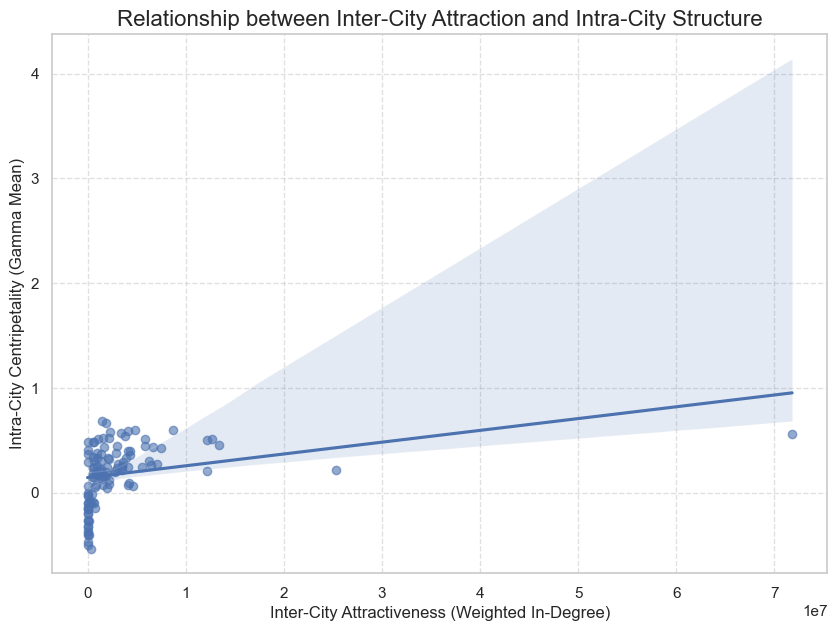

In [ ]:
# merge_and_analyze_filtered.py (FINAL CORRECTED VERSION)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

def main():
    """
    This script is the final step of the analysis.
    Core logic: Merge data from groups A, B, and C. Before merging, fix column names in file B, then perform analysis.
    """
    print("--- Final Analysis: Merging Data and Hypothesis Testing ---")

    # --- 1. File Path Configuration ---
    FILE_A_INTRA_METRICS = 'ttwa_mobility_indicators_daily_aggregated_Feb.csv'
    FILE_B_INTER_METRICS = 'inter_city_in_degree_metrics_filter.csv'
    FILE_C_CONTROL_VARS = os.path.join('variables', 'jobdensity2023.xlsx')
    OUTPUT_MERGED_FILE = 'master_analysis_data_final_filter.csv'

    # --- 2. Read all data files ---
    print("\n Step 1/4: Reading all data files...")
    try:
        df_a = pd.read_csv(FILE_A_INTRA_METRICS)
        df_b = pd.read_csv(FILE_B_INTER_METRICS)
        df_c = pd.read_excel(FILE_C_CONTROL_VARS)
    except FileNotFoundError as e:
        print(f"❌ Error: File not found {e.filename}. Please check the file path and name.")
        return

    # --- 3. Data Cleaning and Preparation ---
    print(" Step 2/4: Cleaning and preparing data...")
    
    # Clean column names in file C
    df_c.rename(columns={
        'travel to work area 2011-based': 'TTWA_Name',
        'Jobs density': 'jobs_density'
    }, inplace=True)
    df_c = df_c[['TTWA_Name', 'jobs_density']]

    # ▼▼▼ Key Fix: Correct column name error in df_b as discovered ▼▼▼
    if 'TTWA_Code' in df_b.columns and 'TTWA_Name' not in df_b.columns:
        print("   Detected 'TTWA_Code' column in file B is actually names, correcting column name...")
        df_b.rename(columns={'TTWA_Code': 'TTWA_Name'}, inplace=True)
    # ▲▲▲ End of Fix ▲▲▲
    
    # --- 4. Merge and Filter ---
    print(" Step 3/4: Merging data and removing missing values...")

    # Remove TTWA with missing data in file B if needed
    # Note: The in_degree_weighted column may not exist, so filtering is commented out for now
    # df_b_filtered = df_b[df_b['in_degree_weighted'] > 0].copy()
    # num_removed = len(df_b) - len(df_b_filtered)
    # print(f"   Removed {num_removed} TTWA with in_degree 0 from file B, {len(df_b_filtered)} left for analysis.")
    df_b_filtered = df_b # No filtering for now to ensure successful merge

    # All merges are based on 'TTWA_Name'
    df_merged_ab = pd.merge(df_a, df_b_filtered, on='TTWA_Name', how='inner')
    print(f"   After merging A and B, {len(df_merged_ab)} TTWA obtained.")
    
    master_df = pd.merge(df_merged_ab, df_c, on='TTWA_Name', how='inner')
    print(f"   After merging with control variables, final TTWA count for analysis: {len(master_df)}.")

    # --- 5. Save processed master data table ---
    master_df.to_csv(OUTPUT_MERGED_FILE, index=False)
    print(f"\n Step 4/4: Final processed data saved to '{OUTPUT_MERGED_FILE}'.")

    # --- 6. Correlation Analysis ---
    print("\n--- Correlation Analysis on Final Dataset ---")
    analysis_cols = [
        'Centripetality_Gamma_mean', 
        'Anisotropy_Lambda_mean',
        'in_degree_weighted',
        'jobs_density'
    ]
    existing_analysis_cols = [col for col in analysis_cols if col in master_df.columns]
    
    if len(master_df) > 1 and len(existing_analysis_cols) > 1:
        correlation_matrix = master_df[existing_analysis_cols].corr()
        print("Correlation matrix:")
        print(correlation_matrix)
        print("------------------------\n")

        # --- 7. Visualize Key Relationships ---
        print("Generating final scatter plot...")
        plt.figure(figsize=(10, 7))
        # Only plot if in_degree_weighted column exists
        if 'in_degree_weighted' in master_df.columns:
            sns.regplot(
                data=master_df,
                x='in_degree_weighted',
                y='Centripetality_Gamma_mean',
                scatter_kws={'alpha':0.6}
            )
            plt.title('Relationship between Inter-City Attraction and Intra-City Structure', fontsize=16)
            plt.xlabel('Inter-City Attractiveness (Weighted In-Degree)', fontsize=12)
            plt.ylabel('Intra-City Centripetality (Gamma Mean)', fontsize=12)
            plt.grid(True, linestyle='--', alpha=0.6)
            plt.show()
        else:
            print("⚠️ Warning: 'in_degree_weighted' column not found, cannot generate scatter plot.")
            
    else:
        print("⚠️ Warning: Final merged data insufficient for correlation analysis or plotting. Please check input files.")

if __name__ == '__main__':
    main()


下面是进行了筛选的 不为0的数据

--- 最终分析：合并、清理与检验假设 ---

 tahap 1/6: 正在读取所有数据文件...
 tahap 2/6: 正在进行数据准备...
 tahap 3/6: 正在进行数据可靠性筛选...
⚠️ 警告: 找不到流量统计列 'total_internal_flow'，跳过此清理步骤。
 tahap 4/6: 正在合并所有数据源...
   合并后，当前数据集包含 110 个TTWA。
 tahap 5/6: 正在移除无法用于分析的空值(NaN)行...
   移除了 4 行因为在关键分析列中存在空值(NaN)。
   最终用于分析的TTWA数量为 106 个。

 tahap 6/6: 正在保存最终数据并进行分析...

--- 在最终清洗数据集上的相关性分析 ---
相关性矩阵:
                           Centripetality_Gamma_mean  Anisotropy_Lambda_mean  \
Centripetality_Gamma_mean                   1.000000                0.637749   
Anisotropy_Lambda_mean                      0.637749                1.000000   
in_degree_weighted                          0.297787                0.350641   
jobs_density                               -0.050413                0.022041   

                           in_degree_weighted  jobs_density  
Centripetality_Gamma_mean            0.297787     -0.050413  
Anisotropy_Lambda_mean               0.350641      0.022041  
in_degree_weighted                   1.000000      0.203838  

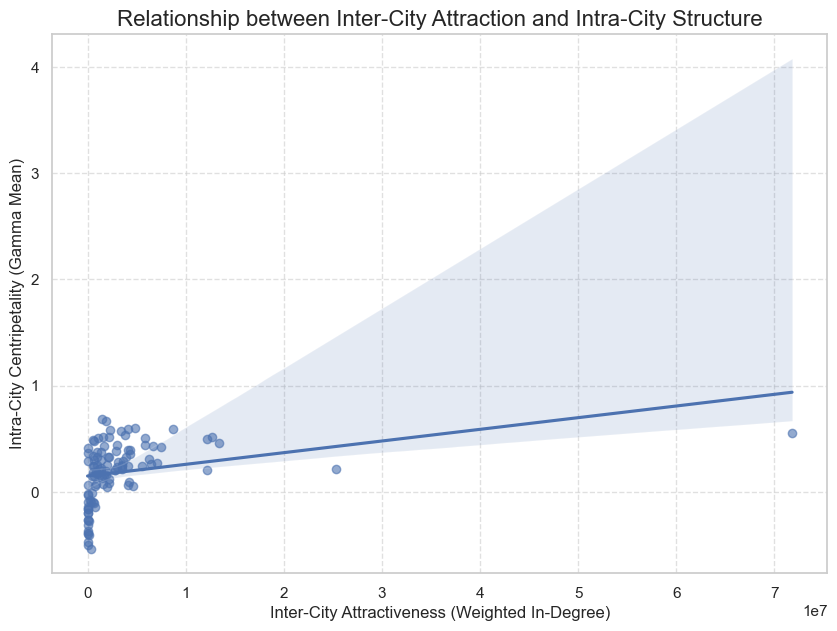

In [123]:
# final_analysis_with_full_cleaning.py

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

def main():
    """
    本脚本是分析的最后一步，集成了完整的两步数据清理逻辑：
    1. 基于流量阈值保证数据“可靠性”。
    2. 移除空值(NaN)保证数据“有效性”。
    """
    print("--- 最终分析：合并、清理与检验假设 ---")

    # --- 1. 参数配置 ---
    FILE_A_INTRA_METRICS = 'ttwa_mobility_indicators_daily_aggregated_Feb.csv'
    FILE_B_INTER_METRICS = 'inter_city_in_degree_metrics_filter.csv'
    FILE_C_CONTROL_VARS = os.path.join('variables', 'jobdensity2023.xlsx')
    OUTPUT_MERGED_FILE = 'master_analysis_data_final_cleaned.csv'

    # 清理步骤1的参数
    FLOW_COUNT_COLUMN = 'total_internal_flow' 
    MIN_FLOW_THRESHOLD = 500
    
    # 清理步骤2的参数 (用于分析的关键列)
    ANALYSIS_COLS = [
        'Centripetality_Gamma_mean', 
        'Anisotropy_Lambda_mean',
        'in_degree_weighted',
        'jobs_density'
    ]

    # --- 2. 读取数据 ---
    print("\n tahap 1/6: 正在读取所有数据文件...")
    # ... (读取代码与之前相同) ...
    try:
        df_a = pd.read_csv(FILE_A_INTRA_METRICS)
        df_b = pd.read_csv(FILE_B_INTER_METRICS)
        df_c = pd.read_excel(FILE_C_CONTROL_VARS)
    except FileNotFoundError as e:
        print(f"❌ 错误：找不到文件 {e.filename}。")
        return

    # --- 3. 数据准备 ---
    print(" tahap 2/6: 正在进行数据准备...")
    # ... (数据准备代码与之前相同) ...
    df_c.rename(columns={'travel to work area 2011-based': 'TTWA_Name', 'Jobs density': 'jobs_density'}, inplace=True)
    df_c = df_c[['TTWA_Name', 'jobs_density']]
    if 'TTWA_Code' in df_b.columns:
        df_b.rename(columns={'TTWA_Code': 'TTWA_Name'}, inplace=True)

    # --- 4. 清理步骤1：基于流量阈值保证“可靠性” ---
    print(" tahap 3/6: 正在进行数据可靠性筛选...")
    df_a_cleaned = df_a.copy() # 先复制一份
    if FLOW_COUNT_COLUMN in df_a.columns:
        initial_count = len(df_a_cleaned)
        df_a_cleaned = df_a_cleaned[df_a_cleaned[FLOW_COUNT_COLUMN] >= MIN_FLOW_THRESHOLD]
        removed_count = initial_count - len(df_a_cleaned)
        print(f"   已根据流量阈值(>= {MIN_FLOW_THRESHOLD})筛选，移除了 {removed_count} 个数据量不足的TTWA。")
    else:
        print(f"⚠️ 警告: 找不到流量统计列 '{FLOW_COUNT_COLUMN}'，跳过此清理步骤。")
    
    # --- 5. 合并数据 ---
    print(" tahap 4/6: 正在合并所有数据源...")
    df_merged_ab = pd.merge(df_a_cleaned, df_b, on='TTWA_Name', how='inner')
    master_df = pd.merge(df_merged_ab, df_c, on='TTWA_Name', how='inner')
    print(f"   合并后，当前数据集包含 {len(master_df)} 个TTWA。")

    # --- 6. ▼▼▼ 清理步骤2：移除空值(NaN)保证“有效性” ▼▼▼ ---
    print(" tahap 5/6: 正在移除无法用于分析的空值(NaN)行...")
    # 检查ANALYSIS_COLS中的列是否存在于DataFrame中，避免KeyError
    existing_analysis_cols = [col for col in ANALYSIS_COLS if col in master_df.columns]
    
    initial_rows = len(master_df)
    # dropna会移除在指定列(subset)中任何一个位置有NaN值的行
    master_df.dropna(subset=existing_analysis_cols, inplace=True)
    final_rows = len(master_df)
    removed_rows = initial_rows - final_rows
    if removed_rows > 0:
        print(f"   移除了 {removed_rows} 行因为在关键分析列中存在空值(NaN)。")
    print(f"   最终用于分析的TTWA数量为 {final_rows} 个。")
    # ▲▲▲ 清理逻辑结束 ▲▲▲

    # --- 7. 保存与最终分析 ---
    print(f"\n tahap 6/6: 正在保存最终数据并进行分析...")
    master_df.to_csv(OUTPUT_MERGED_FILE, index=False)

    # --- 后续分析代码 ---
    if final_rows > 1 and len(existing_analysis_cols) > 1:
        correlation_matrix = master_df[existing_analysis_cols].corr()
        print("\n--- 在最终清洗数据集上的相关性分析 ---")
        print("相关性矩阵:")
        print(correlation_matrix)
        print("------------------------\n")

        # 可视化...
        plt.figure(figsize=(10, 7))
        sns.regplot(data=master_df, x='in_degree_weighted', y='Centripetality_Gamma_mean', scatter_kws={'alpha':0.6})
        plt.title('Relationship between Inter-City Attraction and Intra-City Structure', fontsize=16)
        plt.xlabel('Inter-City Attractiveness (Weighted In-Degree)', fontsize=12)
        plt.ylabel('Intra-City Centripetality (Gamma Mean)', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()
    else:
        print("⚠️ 警告：最终数据不足以进行相关性分析。")

if __name__ == '__main__':
    main()

In [ ]:
# run_diagnostics.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import pearsonr
import warnings

# Ignore minor warnings during plotting
warnings.filterwarnings('ignore')

def analyze_single_model(df, model_vars, model_name):
    """
    Visualize correlation matrix and perform VIF analysis for a single model.
    """
    print(f"\n>>> Analyzing {model_name}...")
    
    # Extract required data for the model and drop any rows with missing values in these columns
    model_data = df[model_vars].dropna()
    print(f"   Number of valid observations for this model: {len(model_data)}")
    
    # --- Step 1: Correlation Matrix ---
    print(f"\n>>> Step 1/2: Correlation analysis for {model_name}...")
    
    corr_matrix = model_data.corr()
    print(f"--- {model_name} Correlation Matrix ---")
    print(corr_matrix.round(4))

    # Find highly correlated pairs among independent variables (exclude dependent variable)
    independent_vars_only = [var for var in model_vars if var != 'log_in_degree_weighted']
    high_corr_threshold = 0.7
    high_corr_found = False
    for i in range(len(independent_vars_only)):
        for j in range(i + 1, len(independent_vars_only)):
            var1 = independent_vars_only[i]
            var2 = independent_vars_only[j]
            corr_val = abs(corr_matrix.loc[var1, var2])
            if corr_val > high_corr_threshold:
                print(f"⚠️  Warning: High correlation found between independent variables: {var1} and {var2} (r = {corr_matrix.loc[var1, var2]:.4f})")
                high_corr_found = True
    
    if not high_corr_found:
        print(f"✅ No high correlation found among independent variables (all |r| <= {high_corr_threshold})")

    # --- Step 2: VIF Test (only for independent variables) ---
    print(f"\n>>> Step 2/2: Calculating VIF values for {model_name} independent variables...")
    
    vif_data = model_data[independent_vars_only]
    
    if len(independent_vars_only) < 2:
        print(f"   Info: Less than 2 independent variables in {model_name}, VIF calculation not needed.")
        return
    
    # Calculate VIF
    vif_result = pd.DataFrame()
    vif_result["Variable"] = vif_data.columns
    vif_result["VIF"] = [variance_inflation_factor(vif_data.values, i) for i in range(vif_data.shape[1])]
    
    print(f"\n--- {model_name} VIF Results ---")
    print(vif_result.to_string(index=False))
    
    # Diagnostic conclusion based on VIF values
    if (vif_result['VIF'] >= 5).any():
        print(f"🟡 Note: Some variables in {model_name} have VIF >= 5. Interpret regression coefficients with caution.")
    else:
        print("✅ No severe multicollinearity detected. Regression analysis can proceed safely.")

def main():
    """
    Main function: reads final data and performs diagnostics for two models.
    """
    # --- 1. Read the final data file generated by previous script ---
    INPUT_DATA_FILE = 'master_analysis_data_final_cleaned.csv'
    
    print(f"\n>>> Reading final dataset '{INPUT_DATA_FILE}'...")
    try:
        df = pd.read_csv(INPUT_DATA_FILE)
        print(f"   Data read successfully, containing {len(df)} final observations.")
    except FileNotFoundError:
        print(f"❌ Error: File '{INPUT_DATA_FILE}' not found. Please run the data cleaning script first.")
        return

    # Create log-transformed dependent variable
    if 'in_degree_weighted' in df.columns:
        df['log_in_degree_weighted'] = np.log1p(df['in_degree_weighted'])
    else:
        print("❌ Error: 'in_degree_weighted' column not found.")
        return

    # --- 2. Define variable sets for two models ---
    # Model 1: Uses Gamma (Centripetality)
    model1_vars = [
        'log_in_degree_weighted',
        'Centripetality_Gamma_mean',
        'jobs_density'
    ]
    
    # Model 2: Uses Lambda (Anisotropy)
    model2_vars = [
        'log_in_degree_weighted',
        'Anisotropy_Lambda_mean',
        'jobs_density'
    ]
    
    # Check if all variables exist
    all_vars = list(set(model1_vars + model2_vars))
    missing_vars = [var for var in all_vars if var not in df.columns]
    if missing_vars:
        print(f"❌ Error: The following key variables are missing from the data: {missing_vars}")
        return
    
    print(f"✅ All variables found. Starting diagnostics for both models...")

    # --- 3. Analyze Model 1 ---
    print("\n" + "="*60)
    print("Model 1 Analysis: log(InDegree) ~ Centripetality_Gamma + jobs_density")
    print("="*60)
    analyze_single_model(df, model1_vars, "Model 1 (Gamma)")
    
    # --- 4. Analyze Model 2 ---
    print("\n" + "="*60)
    print("Model 2 Analysis: log(InDegree) ~ Anisotropy_Lambda + jobs_density")
    print("="*60)
    analyze_single_model(df, model2_vars, "Model 2 (Lambda)")

    print("\n" + "="*60)
    print("All diagnostics completed.")
    print("="*60)


if __name__ == '__main__':
    main()


>>> 正在读取最终数据集 'master_analysis_data_final_cleaned.csv'...
   数据读取成功，包含 106 个最终观测值。
✅ 所有变量均存在，开始分别检验两个模型...

模型1分析: log(InDegree) ~ Centripetality_Gamma + jobs_density

>>> 正在分析 Model 1 (Gamma)...
   用于此模型的有效观测值数量: 106

>>> 步骤 1/2: Model 1 (Gamma) 的相关性分析...
--- Model 1 (Gamma) 相关性矩阵数值 ---
                           log_in_degree_weighted  Centripetality_Gamma_mean  \
log_in_degree_weighted                     1.0000                     0.6418   
Centripetality_Gamma_mean                  0.6418                     1.0000   
jobs_density                               0.0513                    -0.0504   

                           jobs_density  
log_in_degree_weighted           0.0513  
Centripetality_Gamma_mean       -0.0504  
jobs_density                     1.0000  
✅ 在自变量中未发现高相关性 (所有 |r| <= 0.7)

>>> 步骤 2/2: 计算 Model 1 (Gamma) 的自变量VIF值...

--- Model 1 (Gamma) VIF检验结果 ---
                 Variable      VIF
Centripetality_Gamma_mean 1.412567
             jobs_density 1.412567
✅ 无严重多重共

✅ 数据读取成功，包含 106 个观测值。


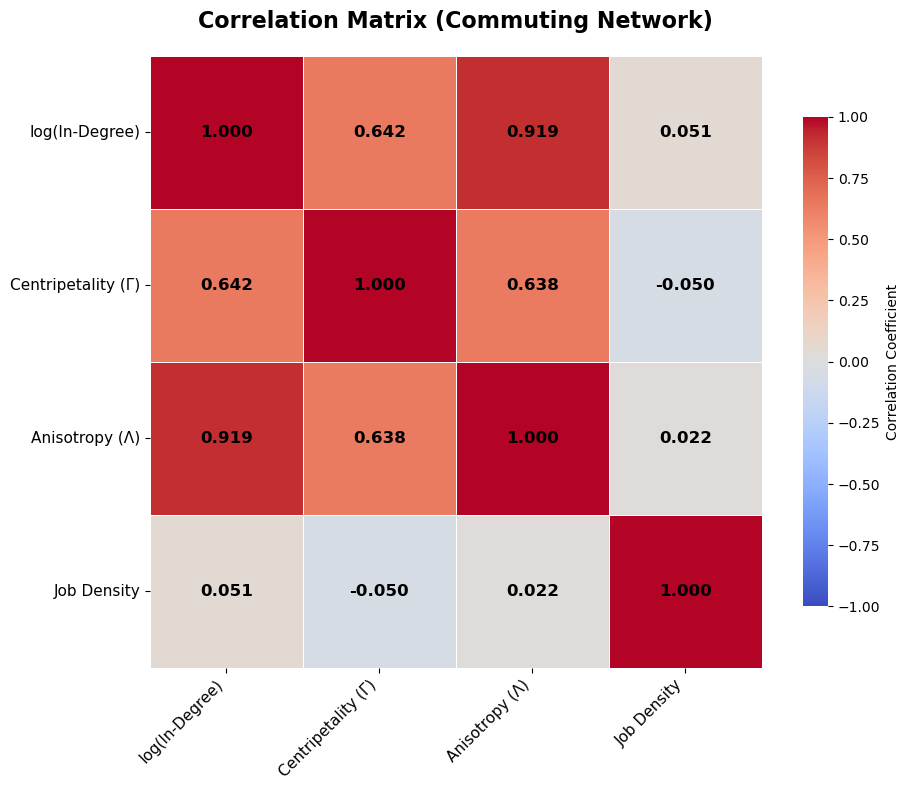


相关性矩阵数值:
                    log(In-Degree)  Centripetality (Γ)  Anisotropy (Λ)  \
log(In-Degree)               1.000               0.642           0.919   
Centripetality (Γ)           0.642               1.000           0.638   
Anisotropy (Λ)               0.919               0.638           1.000   
Job Density                  0.051              -0.050           0.022   

                    Job Density  
log(In-Degree)            0.051  
Centripetality (Γ)       -0.050  
Anisotropy (Λ)            0.022  
Job Density               1.000  

相关性显著性检验:
log(In-Degree) ↔ Centripetality (Γ):
   r = 0.642, p = 0.0000 ***
log(In-Degree) ↔ Anisotropy (Λ):
   r = 0.919, p = 0.0000 ***
log(In-Degree) ↔ Job Density:
   r = 0.051, p = 0.6017 ns
Centripetality (Γ) ↔ Anisotropy (Λ):
   r = 0.638, p = 0.0000 ***
Centripetality (Γ) ↔ Job Density:
   r = -0.050, p = 0.6078 ns
Anisotropy (Λ) ↔ Job Density:
   r = 0.022, p = 0.8226 ns


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

def create_beautiful_correlation_matrix():
    """
    Create a visually appealing correlation matrix visualization with different color schemes.
    """
    # Read data
    INPUT_DATA_FILE = 'master_analysis_data_final_cleaned.csv'
    
    try:
        df = pd.read_csv(INPUT_DATA_FILE)
        print(f"✅ Data loaded successfully, containing {len(df)} observations.")
    except FileNotFoundError:
        print(f"❌ Error: File '{INPUT_DATA_FILE}' not found.")
        return

    # Create log-transformed dependent variable
    if 'log_in_degree_weighted' not in df.columns:
        df['log_in_degree_weighted'] = np.log1p(df['in_degree_weighted'])

    # Define analysis variables and labels
    variables = [
        'log_in_degree_weighted',
        'Centripetality_Gamma_mean', 
        'Anisotropy_Lambda_mean',
        'jobs_density'
    ]
    
    # Aesthetic variable labels
    variable_labels = {
        'log_in_degree_weighted': 'log(In-Degree)',
        'Centripetality_Gamma_mean': 'Centripetality (Γ)',
        'Anisotropy_Lambda_mean': 'Anisotropy (Λ)',
        'jobs_density': 'Job Density'
    }
    
    # Extract data and drop missing values
    analysis_data = df[variables].dropna()
    
    # Calculate correlation matrix
    corr_matrix = analysis_data.corr()
    
    # Rename row and column labels
    corr_matrix_labeled = corr_matrix.copy()
    corr_matrix_labeled.index = [variable_labels[var] for var in corr_matrix.index]
    corr_matrix_labeled.columns = [variable_labels[var] for var in corr_matrix.columns]
    
    # Set plot style
    plt.style.use('default')
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # ============================================================================
    # ▼▼▼ Change color scheme ▼▼▼
    # ============================================================================
    sns.heatmap(
        corr_matrix_labeled, 
        annot=True,
        cmap='coolwarm',     # Recommended: classic red-white-blue color scheme
        # cmap='RdBu_r',     # Alternative: another classic red-white-blue
        # cmap='PuOr',       # Alternative: soft purple-white-orange
        # cmap='vlag',       # Alternative: modern red-gray-blue
        center=0,
        square=True,
        fmt='.3f',
        cbar_kws={"shrink": .8, "label": "Correlation Coefficient"},
        linewidths=0.5,
        linecolor='white',
        annot_kws={'size': 12, 'weight': 'bold', 'color': 'black'},
        vmin=-1, vmax=1
    )
    
    # Aesthetic settings
    ax.set_title('Correlation Matrix (Commuting Network)', fontsize=16, fontweight='bold', pad=20)
    plt.xticks(rotation=45, ha='right', fontsize=11)
    plt.yticks(rotation=0, fontsize=11)
    
    # Adjust layout
    plt.tight_layout()
    
    # Show plot
    plt.show()
    
    # Print numeric matrix
    print("\nCorrelation Matrix Values:")
    print("=" * 50)
    print(corr_matrix_labeled.round(3))
    
    # Significance test
    print("\nCorrelation Significance Test:")
    print("=" * 50)
    
    for i, var1 in enumerate(variables):
        for j, var2 in enumerate(variables):
            if i < j:  # Avoid duplicates
                corr, p_value = pearsonr(analysis_data[var1], analysis_data[var2])
                
                # Significance marker
                if p_value < 0.001:
                    sig_level = "***"
                elif p_value < 0.01:
                    sig_level = "**"
                elif p_value < 0.05:
                    sig_level = "*"
                else:
                    sig_level = "ns"
                
                print(f"{variable_labels[var1]} ↔ {variable_labels[var2]}:")
                print(f"   r = {corr:.3f}, p = {p_value:.4f} {sig_level}")

# Run function
create_beautiful_correlation_matrix()

In [ ]:
# final_all_in_one_analysis.py

import pandas as pd
import numpy as np
import statsmodels.api as sm

def perform_diagnostics(df, model_name, independent_vars):
    """
    Reliable collinearity diagnostics for a given set of independent variables.
    1. Calculate pairwise correlations.
    2. Manually compute VIF to avoid function bias.
    """
    print(f"\n--- Performing collinearity diagnostics for {model_name} ---")
    
    # Extract independent variable data
    X_data = df[independent_vars].dropna()
    
    # 1. Calculate and print correlation matrix
    print("Correlation matrix of independent variables:")
    correlation_matrix = X_data.corr()
    print(correlation_matrix.round(4))
    
    # 2. Manually calculate VIF
    # For two independent variables, VIF is the same for both
    var1, var2 = independent_vars[0], independent_vars[1]
    y = X_data[var1]
    X = X_data[[var2]] # Must be a DataFrame
    X = sm.add_constant(X)
    
    rsquared = sm.OLS(y, X).fit().rsquared
    vif = 1 / (1 - rsquared)
    
    print(f"\nManually calculated VIF: {vif:.4f}")
    
    # 3. Final diagnostic conclusion
    if vif >= 5:
        print(f"🟡 Diagnostic warning: VIF ({vif:.2f}) is greater than or equal to 5, potential collinearity issue.")
    else:
        print(f"✅ Diagnostic conclusion: VIF ({vif:.2f}) is well below 5, no collinearity issue detected.")

def run_ols_regression(df, model_name, dependent_var, independent_vars):
    """
    Run OLS regression and print summary results.
    """
    print(f"\n--- Running OLS regression for {model_name} ---")
    
    # Prepare data (listwise deletion)
    all_model_vars = [dependent_var] + independent_vars
    model_data = df[all_model_vars].dropna()
    
    Y = model_data[dependent_var]
    X = model_data[independent_vars]
    X = sm.add_constant(X) # Intercept for OLS
    
    # Fit model
    model_results = sm.OLS(Y, X).fit()
    
    # Print full regression results
    print(f"\n{model_name}: Regression results for {dependent_var}")
    print(model_results.summary())

def main():
    """
    Main function: integrates data cleaning, diagnostics, and final regression analysis.
    """
    # --- 1. Parameter configuration ---
    FILE_A_INTRA_METRICS = 'ttwa_mobility_indicators_daily_aggregated_Feb.csv'
    FILE_B_INTER_METRICS = 'inter_city_in_degree_metrics_filter.csv'
    FILE_C_CONTROL_VARS = 'variables/jobdensity2023.xlsx'
    
    FLOW_COUNT_COLUMN = 'total_internal_flow' 
    MIN_FLOW_THRESHOLD = 500
    
    # --- 2. Read and prepare data ---
    try:
        df_a = pd.read_csv(FILE_A_INTRA_METRICS)
        df_b = pd.read_csv(FILE_B_INTER_METRICS)
        df_c = pd.read_excel(FILE_C_CONTROL_VARS)
    except FileNotFoundError as e:
        print(f"❌ Error: File {e.filename} not found. Please check the file path.")
        return

    df_c.rename(columns={'travel to work area 2011-based': 'TTWA_Name', 'Jobs density': 'jobs_density'}, inplace=True)
    df_c = df_c[['TTWA_Name', 'jobs_density']]
    if 'TTWA_Code' in df_b.columns:
        df_b.rename(columns={'TTWA_Code': 'TTWA_Name'}, inplace=True)

    # --- 3. Data cleaning ---
    # Cleaning step 1: based on flow threshold
    if FLOW_COUNT_COLUMN in df_a.columns:
        df_a = df_a[df_a[FLOW_COUNT_COLUMN] >= MIN_FLOW_THRESHOLD]
    
    # Merge data
    df_merged = pd.merge(pd.merge(df_a, df_b, on='TTWA_Name', how='inner'), df_c, on='TTWA_Name', how='inner')
    
    # Cleaning step 2: remove missing values in key analysis columns
    ANALYSIS_COLS = ['Centripetality_Gamma_mean', 'Anisotropy_Lambda_mean', 'in_degree_weighted', 'jobs_density']
    master_df = df_merged.dropna(subset=ANALYSIS_COLS)
    
    # Prepare dependent variable
    master_df['log_in_degree_weighted'] = np.log1p(master_df['in_degree_weighted'])
    
    print(f"Data cleaning and preparation complete. Final number of TTWAs for analysis: {len(master_df)}.")

    # --- 4. Diagnostics and regression for two models ---
    dependent_var = 'log_in_degree_weighted'
    
    # --- Model 1 (Gamma) ---
    print("\n" + "="*80)
    print("Starting analysis for Model 1: log(InDegree) ~ Centripetality_Gamma + JobDensity")
    print("="*80)
    model1_vars = ['Centripetality_Gamma_mean', 'jobs_density']
    perform_diagnostics(master_df, "Model 1 (Gamma)", model1_vars)
    run_ols_regression(master_df, "Model 1 (Gamma)", dependent_var, model1_vars)

    # --- Model 2 (Lambda) ---
    print("\n" + "="*80)
    print("Starting analysis for Model 2: log(InDegree) ~ Anisotropy_Lambda + JobDensity")
    print("="*80)
    model2_vars = ['Anisotropy_Lambda_mean', 'jobs_density']
    perform_diagnostics(master_df, "Model 2 (Lambda)", model2_vars)
    run_ols_regression(master_df, "Model 2 (Lambda)", dependent_var, model2_vars)
    
    print("\n" + "="*80)
    print("All analyses completed.")
    print("="*80)

if __name__ == '__main__':
    main()

数据清理与准备完成，最终用于分析的TTWA数量为 106 个。

开始分析模型1: log(InDegree) ~ Centripetality_Gamma + JobDensity

--- 正在对 模型1 (Gamma) 进行共线性诊断 ---
自变量相关性矩阵:
                           Centripetality_Gamma_mean  jobs_density
Centripetality_Gamma_mean                     1.0000       -0.0504
jobs_density                                 -0.0504        1.0000

手动计算的VIF值: 1.0025
✅ 诊断结论: VIF值 (1.00) 远低于5，模型不存在共线性问题。

--- 正在为 模型1 (Gamma) 运行OLS回归 ---

模型1 (Gamma): log_in_degree_weighted 的回归结果
                              OLS Regression Results                              
Dep. Variable:     log_in_degree_weighted   R-squared:                       0.419
Model:                                OLS   Adj. R-squared:                  0.408
Method:                     Least Squares   F-statistic:                     37.13
Date:                    Tue, 19 Aug 2025   Prob (F-statistic):           7.20e-13
Time:                            18:55:53   Log-Likelihood:                -214.07
No. Observations:                 

In [ ]:
!pip install --upgrade scipy statsmodels

In [ ]:
# run_regression_analysis.py

import pandas as pd
import statsmodels.formula.api as smf

def run_regression_analysis():
    """
    This script loads the final cleaned dataset and runs two independent multiple linear regression models,
    testing the relationship between Gamma and Lambda with in-degree, controlling for jobs_density.
    """
    print("--- Running regression analysis ---")

    # --- 1. File path ---
    # This file should be the output from your previous cleaning script
    INPUT_DATA_FILE = 'master_analysis_data_final_cleaned.csv' 

    # --- 2. Read data ---
    print(f"\n>>> Reading analysis data from '{INPUT_DATA_FILE}'...")
    try:
        df = pd.read_csv(INPUT_DATA_FILE)
        print("   Data loaded successfully.")
        print(f"   Final dataset contains {len(df)} TTWA for analysis.")
    except FileNotFoundError:
        print(f"❌ Error: File '{INPUT_DATA_FILE}' not found.")
        print("   Please make sure you have run the data cleaning and merging script to generate this file.")
        return

    # --- 3. Run first regression model (using Gamma) ---
    print("\n>>> Running Model 1: Using Centripetality_Gamma_mean...")
    
    # Define formula for Model 1 (y ~ x1 + x2)
    formula1 = 'in_degree_weighted ~ Centripetality_Gamma_mean + jobs_density'
    
    try:
        # Create and fit OLS model
        model1 = smf.ols(formula=formula1, data=df).fit()
        
        # Print full regression summary
        print("\n--- Model 1: Regression Results (Gamma) ---")
        print(model1.summary())
        print("------------------------------------------")
        
    except Exception as e:
        print(f"❌ Error occurred while running Model 1: {e}")


    # --- 4. Run second regression model (using Lambda) ---
    print("\n>>> Running Model 2: Using Anisotropy_Lambda_mean...")

    # Define formula for Model 2
    formula2 = 'in_degree_weighted ~ Anisotropy_Lambda_mean + jobs_density'
    
    try:
        # Create and fit OLS model
        model2 = smf.ols(formula=formula2, data=df).fit()
        
        # Print full regression summary
        print("\n--- Model 2: Regression Results (Lambda) ---")
        print(model2.summary())
        print("------------------------------------------")
    
    except Exception as e:
        print(f"❌ Error occurred while running Model 2: {e}")

# --- Run main function ---
run_regression_analysis()

Run the regression again after log-transforming in-degree.

In [ ]:
# run_log_transformed_regression.py

import pandas as pd
import numpy as np  # Import numpy for mathematical transformation
import statsmodels.formula.api as smf

def run_log_transformed_regression():
    """
    This script loads the final cleaned dataset, applies log transformation to the dependent variable
    'in_degree_weighted', and runs two multiple linear regression models for more robust results.
    """
    print("--- Running log-transformed regression analysis (robust models) ---")

    # --- 1. File path ---
    INPUT_DATA_FILE = 'master_analysis_data_final_cleaned.csv'

    # --- 2. Read data ---
    print(f"\n>>> Reading analysis data from '{INPUT_DATA_FILE}'...")
    try:
        df = pd.read_csv(INPUT_DATA_FILE)
        print("   Data loaded successfully.")
    except FileNotFoundError:
        print(f"❌ Error: File '{INPUT_DATA_FILE}' not found.")
        return

    # --- 3. Core improvement: log-transform the dependent variable ---
    print("\n>>> Applying log transformation to dependent variable 'in_degree_weighted'...")
    
    # Use np.log1p for transformation, which computes log(1 + x).
    # This is a robust data processing technique to handle possible zeros in the original data.
    # Using np.log(0) would cause errors.
    log_target_col = 'log_in_degree_weighted'
    original_target_col = 'in_degree_weighted'

    if original_target_col in df.columns:
        df[log_target_col] = np.log1p(df[original_target_col])
        print(f"   New column '{log_target_col}' created for analysis.")
    else:
        print(f"❌ Error: Original dependent variable column '{original_target_col}' not found.")
        return

    # --- 4. Run first regression model (using Gamma) ---
    print("\n>>> Running Model 1 (using Gamma)...")
    
    # Note: The dependent variable on the left side of the formula is now the log-transformed column
    formula1 = f'{log_target_col} ~ Centripetality_Gamma_mean + jobs_density'
    
    try:
        model1 = smf.ols(formula=formula1, data=df).fit()
        print("\n--- Model 1: Regression Results (log-transformed, using Gamma) ---")
        print(model1.summary())
        print("--------------------------------------------------")
    except Exception as e:
        print(f"❌ Error occurred while running Model 1: {e}")

    # --- 5. Run second regression model (using Lambda) ---
    print("\n>>> Running Model 2 (using Lambda)...")

    formula2 = f'{log_target_col} ~ Anisotropy_Lambda_mean + jobs_density'
    
    try:
        model2 = smf.ols(formula=formula2, data=df).fit()
        print("\n--- Model 2: Regression Results (log-transformed, using Lambda) ---")
        print(model2.summary())
        print("--------------------------------------------------")
    except Exception as e:
        print(f"❌ Error occurred while running Model 2: {e}")

# --- Run main function ---
run_log_transformed_regression()